In [254]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [312]:
import pandas as pd
import cudf
import cupy as cp
import cupyx
import json

import numpy as np 
import os
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib as mpl
import seaborn as sns 
import xgboost
# import mlflow
from sklearn.model_selection import train_test_split
# from cuml.model_selection import train_test_split

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import roc_auc_score, matthews_corrcoef, precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold 
from tqdm import tqdm

from scipy.sparse import hstack, csr_matrix
import spacy

import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from transformers import AutoModel, AutoConfig, AutoTokenizer, get_linear_schedule_with_warmup

from xgboost import XGBClassifier

from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler

from cuml.ensemble import RandomForestClassifier as cuRandomForestClassifier
# from cuml.neighbors import KNeighborsClassifier as cuKNeighbors
from cuml import LogisticRegression
# from cuml import Ridge
# from cuml.svm import SVC as cuSVC

from sklearn.neighbors import KNeighborsClassifier
# from sklearn.linear_model import LogisticRegression

from collections import Counter
import cudf, cuml, cupy
# from cuml.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
import spacy_transformers

In [256]:
tqdm.pandas()

In [257]:
RANDOM_SEED = 921

In [258]:
# mlflow.autolog()

In [259]:
plot_params = {
    'font.family': 'Ubuntu',
    'font.weight': 'light',
    
    'figure.figsize': (15,5),
    'figure.frameon': False, 
    'figure.titlesize': 'xx-large',
    'figure.titleweight': 'normal',
    
    'axes.titlesize': 'x-large',
    'axes.titlecolor': 'black',
    'axes.titleweight': 'normal',
    'axes.titlelocation': 'center',
    'axes.labelsize': 'x-large',

    'grid.alpha': .25, 
    'legend.frameon':False,
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large',
}

In [260]:
pylab.rcParams.update(plot_params)
sns.set_palette('mako')

In [261]:
np.random.seed(RANDOM_SEED)

In [262]:
os.listdir('data')

['Lyrics-Genre-Test-GroundTruth.csv', 'Lyrics-Genre-Train.csv']

In [263]:
TRAIN_PATH = 'data/Lyrics-Genre-Train.csv'
TEST_PATH = 'data/Lyrics-Genre-Test-GroundTruth.csv'

In [264]:
train_data = pd.read_csv(TRAIN_PATH)
test_data = pd.read_csv(TEST_PATH)

In [265]:
# Define metrics
def calculate_metrics(Y_true, Y_pred, log = True, verbose = True):
    """ Logging custom metrics of interest to the mlflow server"""
    
    # Metrics
    acc = accuracy_score(Y_true, Y_pred)
    f1 = f1_score(Y_true, Y_pred, average = 'weighted')
    precision = precision_score(Y_true, Y_pred, average= 'weighted')
    recall = recall_score(Y_true, Y_pred, average = 'weighted')
    mcc = matthews_corrcoef(Y_true, Y_pred)
    cls_report = classification_report(Y_true, Y_pred, target_names=label_encoder.classes_.tolist())
    
    # Logging 
    if log:
        mlflow.log_metric(key = 'accuracy', value = acc )
        mlflow.log_metric(key = 'f1_score', value = f1  )
        mlflow.log_metric(key = 'precision', value = precision)
        mlflow.log_metric(key = 'recall', value = recall)
        mlflow.log_metric(key = 'matthews', value = mcc)
    
    # Display results in notebook
    if verbose:
        print('Metrics:')
        print(f'\t Accuracy \t\t{acc}')
        print(f'\t F-Score \t\t{f1 }')
        print(f'\t Precision \t\t{precision}')
        print(f'\t Recall \t\t{recall}')
        print(f"\t Matthew's cc \t\t{mcc}")
        print(f'\n{cls_report}')

    return (acc, f1, precision, recall, mcc)
    

#### EDA

In [186]:
train_data.shape

(18513, 6)

In [187]:
train_data.head()

,Song,Song year,Artist,Genre,Lyrics,Track_id
0,forest-enthroned,2007,catamenia,Metal,"I am a night in to the darkness, only soul lost with me, I walk throught the\nnight in to the forest and everything stays behind me, i`m waiting f...",18096
1,superhero,2010,aaron-smith,Hip-Hop,"Yeah\nSometimes, i just wanna fly away.\nThey say i can't.\nI can't skate, i can't surf. I ain't from the streets the beach is my turf.\nI can't s...",22724
2,chicago-now,2007,fall,Metal,"Do you work hard?\nDo you work hard?\nYou don't!\nYou don't!\nYou don't! Chicago, now!\nDo you work hard?\nDo you try hard?\nYou don't. Chicago, n...",24760
3,the-secret,2007,geto-boys,Hip-Hop,"You know what? I'm destined to be the last man standin\nCarefully mappin my escape through plannin\nCome in and get it, and leave here with it\nMa...",24176
4,be-the-lake,2011,brad-paisley,Country,"There ain't nothing that I would rather see\nThan you drying off on this dock\nI've been thinking, it's so good to be me\nBut girl, on second thou...",17260


In [188]:
test_data.shape

(7935, 6)

In [189]:
test_data.head()

,Song,Song year,Artist,Genre,Lyrics,Track_id
0,craftsmanship,2005,buck-65,Hip-Hop,Most folks spend their days daydreaming of finding clues\nMy whole life I've been here at the train station shining shoes\nI started when I was ni...,8294
1,come-on-out,2012,the-elwins,Indie,Take your cold hands and put them on my face\nSharpen your axe and your criminal ways\nLet's go to town\nand do what we did before\nIt's gonna hur...,21621
2,riot,2013,bullet-for-my-valentine,Metal,"Are you ready it's time for war\nWe'll break down these fucking doors\nSmash the windows, tear down the walls\nWe won't stop 'til it's all destroy...",3301
3,that-s-what-girls-do,2007,dream-street,Pop,You ask me why I change the color of my hair\n(Yeah)\nYou ask me why I need thirty two pairs of shoes\n(To wear)\nYou seem to ask me why I got a l...,2773
4,believe-in-a-dollar,2012,cassidy,Hip-Hop,"Do you believe in magic in a young girl's heart\nHow the music can free her whenever it starts\nAnd it's magic, if the music is groovy\nIt makes y...",16797


In [190]:
fig_idx = 0

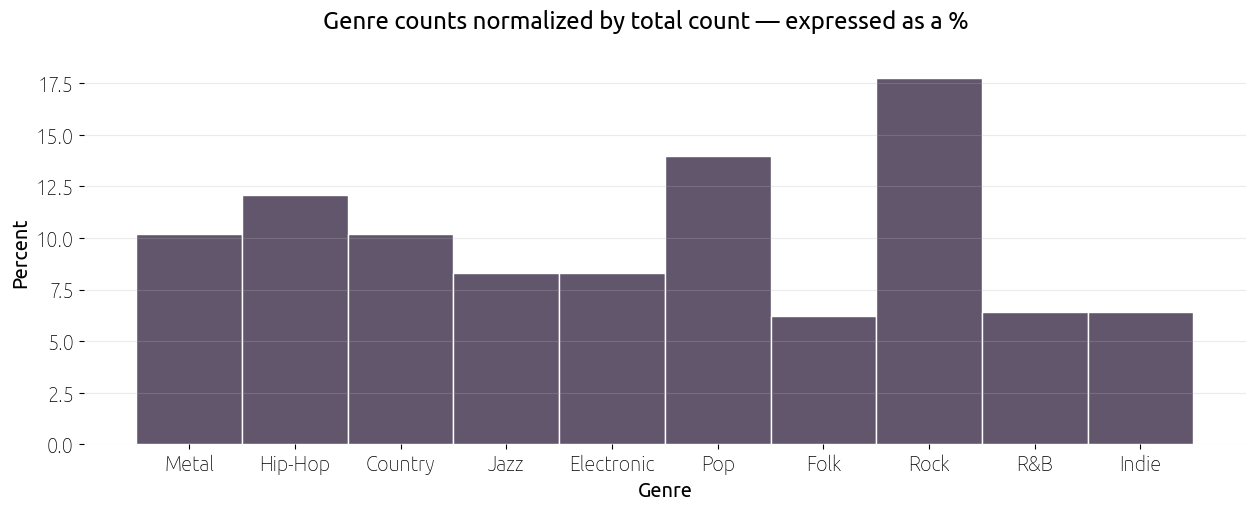

In [191]:
sns.histplot(train_data['Genre'], edgecolor = 'white', stat = 'percent')
plt.box(False)
plt.suptitle('Genre counts normalized by total count \u2015 expressed as a %')
plt.grid(axis = 'y')
plt.savefig(f"figures/figure{fig_idx}.png")
fig_idx += 1
plt.show()


In [192]:
train_data['Genre'].nunique()

10

There are 10 classes. A somewhat unbalanced dataset. Three classes with less than 5% samples. The majority class being Rock w/ approximately 18% of the entries.

In [193]:
pd.options.display.max_colwidth = 150

Checking samples.

In [194]:
train_data.groupby('Genre').head(5).sort_values(by = 'Genre')[['Genre','Lyrics']]

,Genre,Lyrics
49,Country,Ashes of love cold as ice you made the debt I'll pay the price\nOur love is gone there's no doubt ashes of love the flames burned out\nThe love li...
42,Country,"Well I married me a wife\nShe gave me trouble all my life\nShe ran me out in the cold rain and snow\nRain and snow, rain and snow\nShe ran me out ..."
30,Country,Your hunger after money\nYour parents agree\nThe things you don't require\nYou kid yourself you need\nNeglect the flower of love\nGive your worshi...
4,Country,"There ain't nothing that I would rather see\nThan you drying off on this dock\nI've been thinking, it's so good to be me\nBut girl, on second thou..."
15,Country,"I stay out late most every night until closing time\nTryin' to find a way to drink your mem'ry off my mind\nAnd even if it goes just right, I'd ne..."
32,Electronic,ounce for ounce\nblood for blood\nyou get a taste\nand it's never enough\npound for pound\neye for an eye\nyou get the thirst\nand it never runs d...
14,Electronic,"Every time I leave you, girl\nHe's the one that's near you, girl, oh I\nEven as I drive away\nI can hear the words he'll say, oh I\nI guess I don'..."
12,Electronic,Rock your body\nFeel the flow\nMind machine flashing\nThe green light to go\nBeat box drummer\nAnd a microphone\nThat's all we need to\nMake the s...
20,Electronic,"We got the green to the paper\nAnd enough green in the face, yeah\nJump up, put ya hand in the party\nJump up, 4:30 in the morning\nI'm gone when ..."
8,Electronic,"Well, don't get on the wrong train\nDon't fly in an old plane\nDon't go out in the p0uring rain\nYou might get wet I'd be upset\nYou're bound to g..."


Newline counts --- Basically the verses --- Also, possible lengths

In [195]:
subset = train_data[[ 'Genre', 'Lyrics']]

In [196]:
subset['newlines'] = subset['Lyrics'].str.count('\n')

/tmp/ipykernel_1316027/3103477309.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['newlines'] = subset['Lyrics'].str.count('\n')


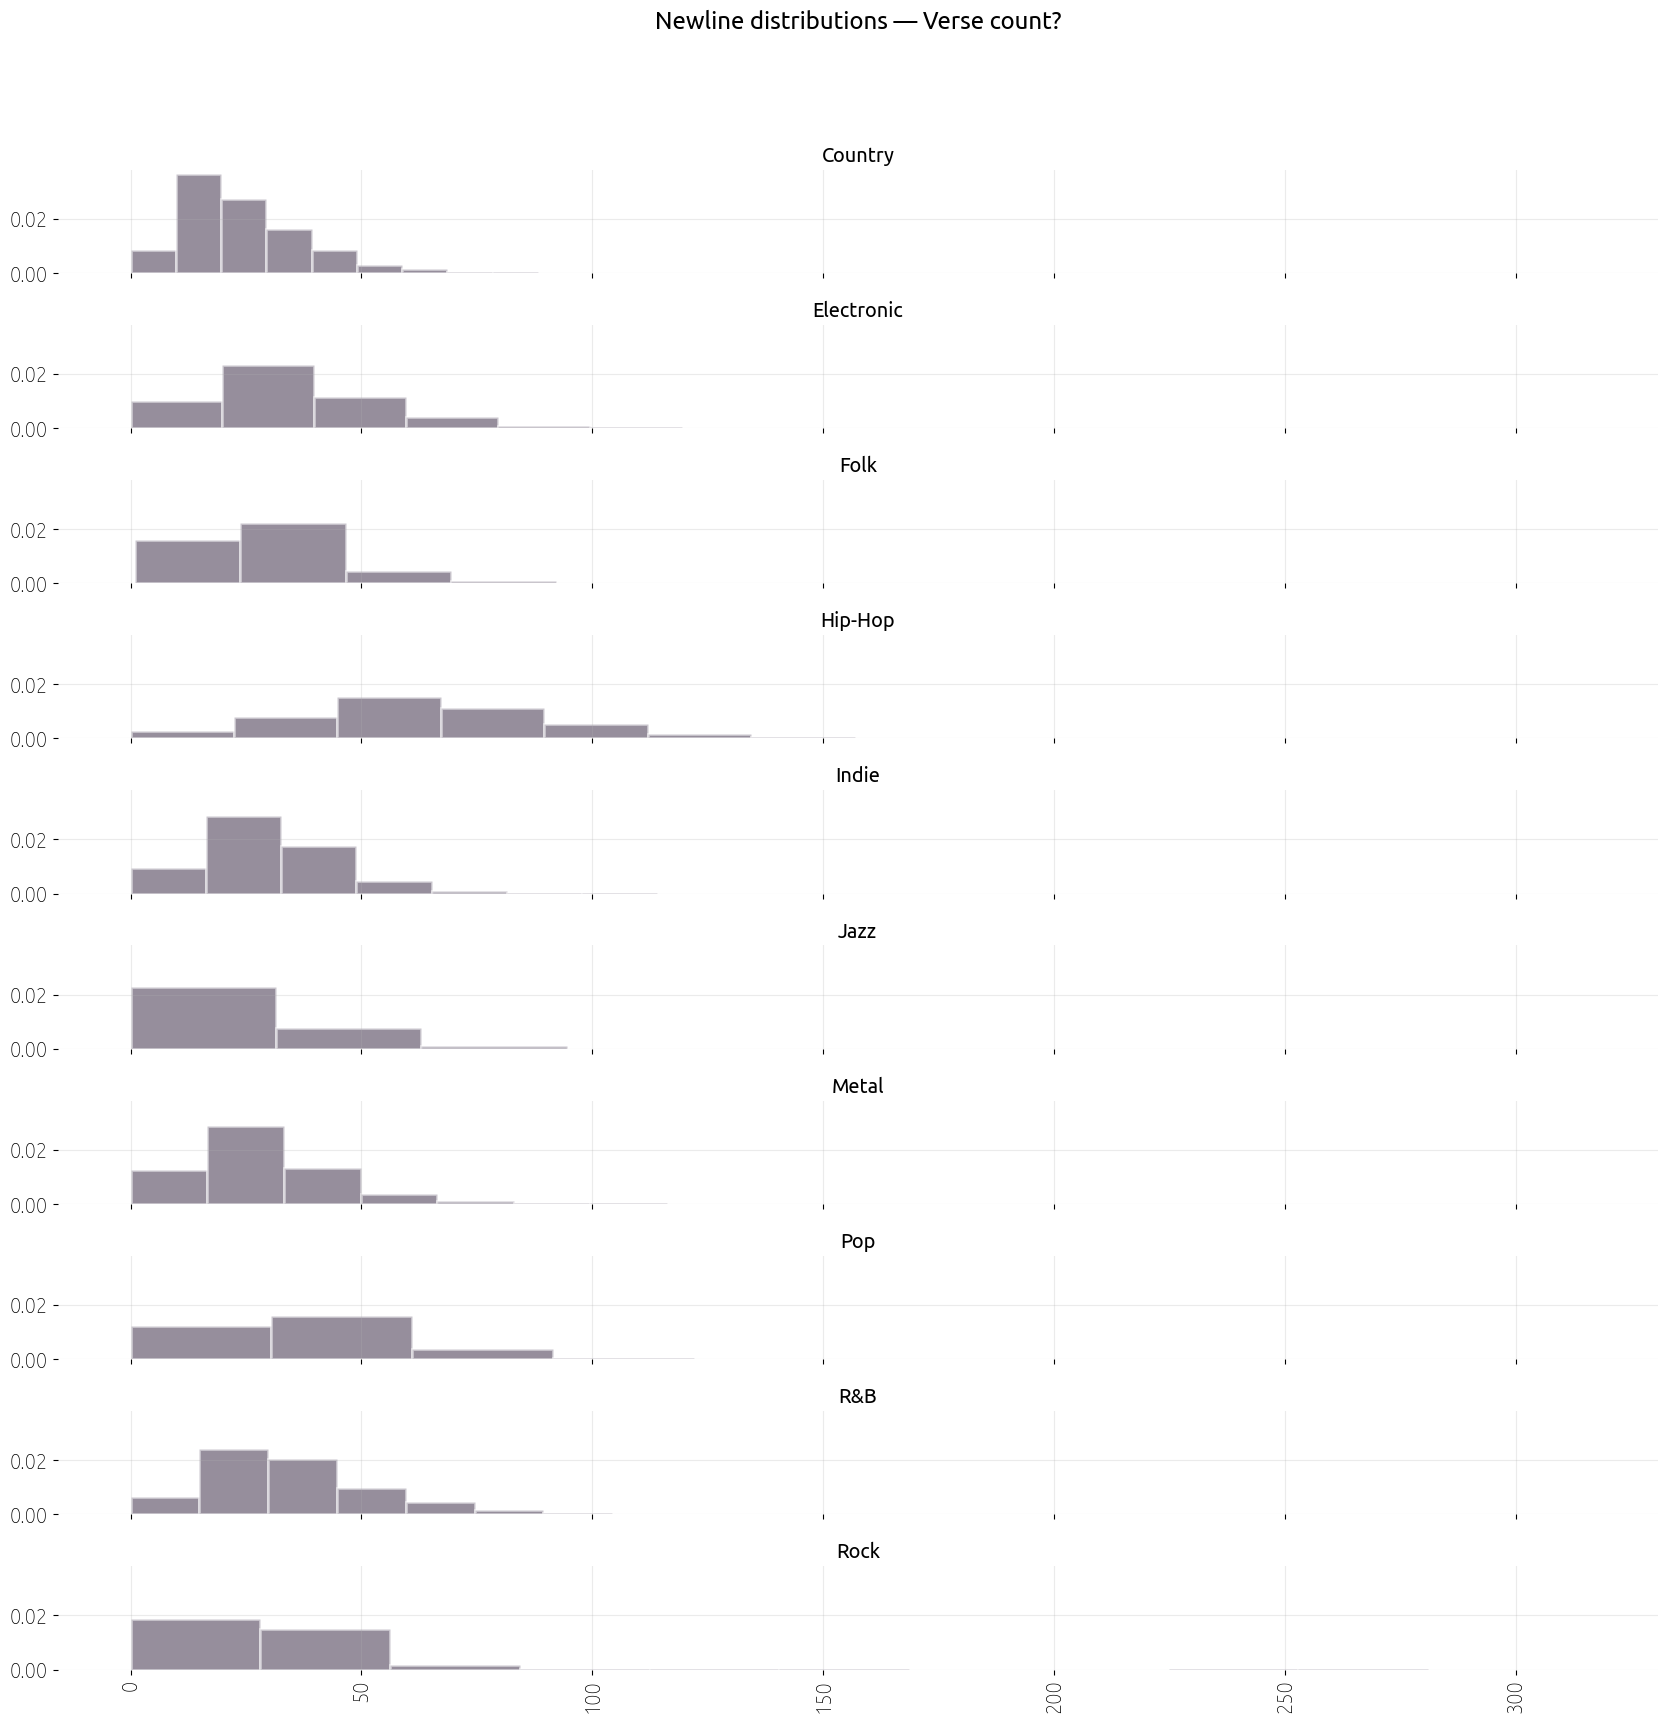

In [197]:
fig, axs = plt.subplots(10, 1, figsize = (20,20), sharex=True, sharey=True)
subset['newlines'].hist(by = subset['Genre'], legend = False, alpha = .5, histtype = 'bar', edgecolor = 'white', linewidth = 2, density = True, ax = axs)
for ax in axs.flatten():
    ax.set_frame_on(False)
    ax.grid(.25)
fig.suptitle("Newline distributions \u2014 Verse count?")

plt.savefig(f"figures/figure{fig_idx}.png")
fig_idx += 1
plt.show()

What about the average verse length?

In [198]:
subset['verses'] = subset['Lyrics'].str.split('\n')

/tmp/ipykernel_1316027/407760592.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['verses'] = subset['Lyrics'].str.split('\n')


In [199]:
subset

,Genre,Lyrics,newlines,verses
0,Metal,"I am a night in to the darkness, only soul lost with me, I walk throught the\nnight in to the forest and everything stays behind me, i`m waiting f...",9,"[I am a night in to the darkness, only soul lost with me, I walk throught the, night in to the forest and everything stays behind me, i`m waiting ..."
1,Hip-Hop,"Yeah\nSometimes, i just wanna fly away.\nThey say i can't.\nI can't skate, i can't surf. I ain't from the streets the beach is my turf.\nI can't s...",18,"[Yeah, Sometimes, i just wanna fly away., They say i can't., I can't skate, i can't surf. I ain't from the streets the beach is my turf., I can't ..."
2,Metal,"Do you work hard?\nDo you work hard?\nYou don't!\nYou don't!\nYou don't! Chicago, now!\nDo you work hard?\nDo you try hard?\nYou don't. Chicago, n...",28,"[Do you work hard?, Do you work hard?, You don't!, You don't!, You don't! Chicago, now!, Do you work hard?, Do you try hard?, You don't. Chicago, ..."
3,Hip-Hop,"You know what? I'm destined to be the last man standin\nCarefully mappin my escape through plannin\nCome in and get it, and leave here with it\nMa...",53,"[You know what? I'm destined to be the last man standin, Carefully mappin my escape through plannin, Come in and get it, and leave here with it, M..."
4,Country,"There ain't nothing that I would rather see\nThan you drying off on this dock\nI've been thinking, it's so good to be me\nBut girl, on second thou...",24,"[There ain't nothing that I would rather see, Than you drying off on this dock, I've been thinking, it's so good to be me, But girl, on second tho..."
...,...,...,...,...
18508,R&B,I'm the best friend he's got\nI'd give him the shirt off my back\nHe knows he can trust me with his life\nBut he's tryin' to leave me alone\nLeave...,46,"[I'm the best friend he's got, I'd give him the shirt off my back, He knows he can trust me with his life, But he's tryin' to leave me alone, Leav..."
18509,Pop,"Bad Boys Blue\n""I Totally Miss You""\nI did you wrong,\nMy foolish heart went out to play.\nAnd then I lost you,\nOh What a price for me to pay.\nW...",47,"[Bad Boys Blue, ""I Totally Miss You"", I did you wrong,, My foolish heart went out to play., And then I lost you,, Oh What a price for me to pay., ..."
18510,Pop,"Forgive me for the things\nThat I never said to you\nForgive me for not knowing\nThe right words to say, to prove\nThat I will always be\nDevoted ...",55,"[Forgive me for the things, That I never said to you, Forgive me for not knowing, The right words to say, to prove, That I will always be, Devoted..."
18511,Indie,The day they found a cure for AIDS\nThe day they found a cure for AIDS\nEverybody took one little pill and was okay\nThe day they found a cure\nTh...,23,"[The day they found a cure for AIDS, The day they found a cure for AIDS, Everybody took one little pill and was okay, The day they found a cure, T..."


In [200]:
def get_mean_verse_length(verses):
    return np.mean([len(verse) for verse in verses], dtype = np.float16)

In [201]:
subset['mean_verse_length'] = subset.verses.map(get_mean_verse_length)

/tmp/ipykernel_1316027/2089163761.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['mean_verse_length'] = subset.verses.map(get_mean_verse_length)


In [202]:
subset

,Genre,Lyrics,newlines,verses,mean_verse_length
0,Metal,"I am a night in to the darkness, only soul lost with me, I walk throught the\nnight in to the forest and everything stays behind me, i`m waiting f...",9,"[I am a night in to the darkness, only soul lost with me, I walk throught the, night in to the forest and everything stays behind me, i`m waiting ...",62.406250
1,Hip-Hop,"Yeah\nSometimes, i just wanna fly away.\nThey say i can't.\nI can't skate, i can't surf. I ain't from the streets the beach is my turf.\nI can't s...",18,"[Yeah, Sometimes, i just wanna fly away., They say i can't., I can't skate, i can't surf. I ain't from the streets the beach is my turf., I can't ...",115.562500
2,Metal,"Do you work hard?\nDo you work hard?\nYou don't!\nYou don't!\nYou don't! Chicago, now!\nDo you work hard?\nDo you try hard?\nYou don't. Chicago, n...",28,"[Do you work hard?, Do you work hard?, You don't!, You don't!, You don't! Chicago, now!, Do you work hard?, Do you try hard?, You don't. Chicago, ...",17.171875
3,Hip-Hop,"You know what? I'm destined to be the last man standin\nCarefully mappin my escape through plannin\nCome in and get it, and leave here with it\nMa...",53,"[You know what? I'm destined to be the last man standin, Carefully mappin my escape through plannin, Come in and get it, and leave here with it, M...",43.875000
4,Country,"There ain't nothing that I would rather see\nThan you drying off on this dock\nI've been thinking, it's so good to be me\nBut girl, on second thou...",24,"[There ain't nothing that I would rather see, Than you drying off on this dock, I've been thinking, it's so good to be me, But girl, on second tho...",41.562500
...,...,...,...,...,...
18508,R&B,I'm the best friend he's got\nI'd give him the shirt off my back\nHe knows he can trust me with his life\nBut he's tryin' to leave me alone\nLeave...,46,"[I'm the best friend he's got, I'd give him the shirt off my back, He knows he can trust me with his life, But he's tryin' to leave me alone, Leav...",30.875000
18509,Pop,"Bad Boys Blue\n""I Totally Miss You""\nI did you wrong,\nMy foolish heart went out to play.\nAnd then I lost you,\nOh What a price for me to pay.\nW...",47,"[Bad Boys Blue, ""I Totally Miss You"", I did you wrong,, My foolish heart went out to play., And then I lost you,, Oh What a price for me to pay., ...",26.609375
18510,Pop,"Forgive me for the things\nThat I never said to you\nForgive me for not knowing\nThe right words to say, to prove\nThat I will always be\nDevoted ...",55,"[Forgive me for the things, That I never said to you, Forgive me for not knowing, The right words to say, to prove, That I will always be, Devoted...",23.734375
18511,Indie,The day they found a cure for AIDS\nThe day they found a cure for AIDS\nEverybody took one little pill and was okay\nThe day they found a cure\nTh...,23,"[The day they found a cure for AIDS, The day they found a cure for AIDS, Everybody took one little pill and was okay, The day they found a cure, T...",40.531250


In [203]:
subset.Genre.unique().tolist()

['Metal',
 'Hip-Hop',
 'Country',
 'Jazz',
 'Electronic',
 'Pop',
 'Folk',
 'Rock',
 'R&B',
 'Indie']

In [204]:
subset.loc[(subset.Genre == 'Metal')]

,Genre,Lyrics,newlines,verses,mean_verse_length
0,Metal,"I am a night in to the darkness, only soul lost with me, I walk throught the\nnight in to the forest and everything stays behind me, i`m waiting f...",9,"[I am a night in to the darkness, only soul lost with me, I walk throught the, night in to the forest and everything stays behind me, i`m waiting ...",62.406250
2,Metal,"Do you work hard?\nDo you work hard?\nYou don't!\nYou don't!\nYou don't! Chicago, now!\nDo you work hard?\nDo you try hard?\nYou don't. Chicago, n...",28,"[Do you work hard?, Do you work hard?, You don't!, You don't!, You don't! Chicago, now!, Do you work hard?, Do you try hard?, You don't. Chicago, ...",17.171875
11,Metal,I'm a sacred king in a sacred kingdom\nYou know me just as a royality\nLooking kind so you don't see\nI'd like to steal your virginity\nI was born...,42,"[I'm a sacred king in a sacred kingdom, You know me just as a royality, Looking kind so you don't see, I'd like to steal your virginity, I was bor...",29.812500
17,Metal,Deep into the darkness peering\nLong I stood there fearing\nDreaming dreams no mortal ever dared to dream before...\nBut the silence was unbroken\...,23,"[Deep into the darkness peering, Long I stood there fearing, Dreaming dreams no mortal ever dared to dream before..., But the silence was unbroken...",32.531250
19,Metal,Lying awake in the dead of night\nListening to my heart beat away\nWishing I wasn't alone here tonight\nBut wishing just gets in the way\nI just w...,16,"[Lying awake in the dead of night, Listening to my heart beat away, Wishing I wasn't alone here tonight, But wishing just gets in the way, I just ...",33.718750
...,...,...,...,...,...
18447,Metal,"Wrong, all that we are\nLiving, breathing lies\nWrong, all that I feel\nAll compassion dies\n[Chorus:]\nOnce hand in hand\nAnd now detached\nBefri...",34,"[Wrong, all that we are, Living, breathing lies, Wrong, all that I feel, All compassion dies, [Chorus:], Once hand in hand, And now detached, Befr...",22.234375
18460,Metal,To much of this force!\nThe lack of structure!\nMy life burnt\nReflecting a forest in flames!\nTime withdraws\nHard times ahead\nThe rules are bro...,30,"[To much of this force!, The lack of structure!, My life burnt, Reflecting a forest in flames!, Time withdraws, Hard times ahead, The rules are br...",20.093750
18488,Metal,[1.]\nI am the one that makes you weak\nI am the one that makes you feel like a spineless creep\nI am the one without no heart\nI am the one that ...,33,"[[1.], I am the one that makes you weak, I am the one that makes you feel like a spineless creep, I am the one without no heart, I am the one that...",25.296875
18495,Metal,I used to be blind\nLiving inside a dream someone had created\nWithout knowing where I really was\nSearching my mind for the answer\nMy hands was ...,28,"[I used to be blind, Living inside a dream someone had created, Without knowing where I really was, Searching my mind for the answer, My hands was...",32.062500


In [205]:
subset.loc[(subset.Genre == 'Metal')]['mean_verse_length'].reset_index(drop=True)

0       62.406250
1       17.171875
2       29.812500
3       32.531250
4       33.718750
          ...    
1885    22.234375
1886    20.093750
1887    25.296875
1888    32.062500
1889    36.156250
Name: mean_verse_length, Length: 1890, dtype: float16

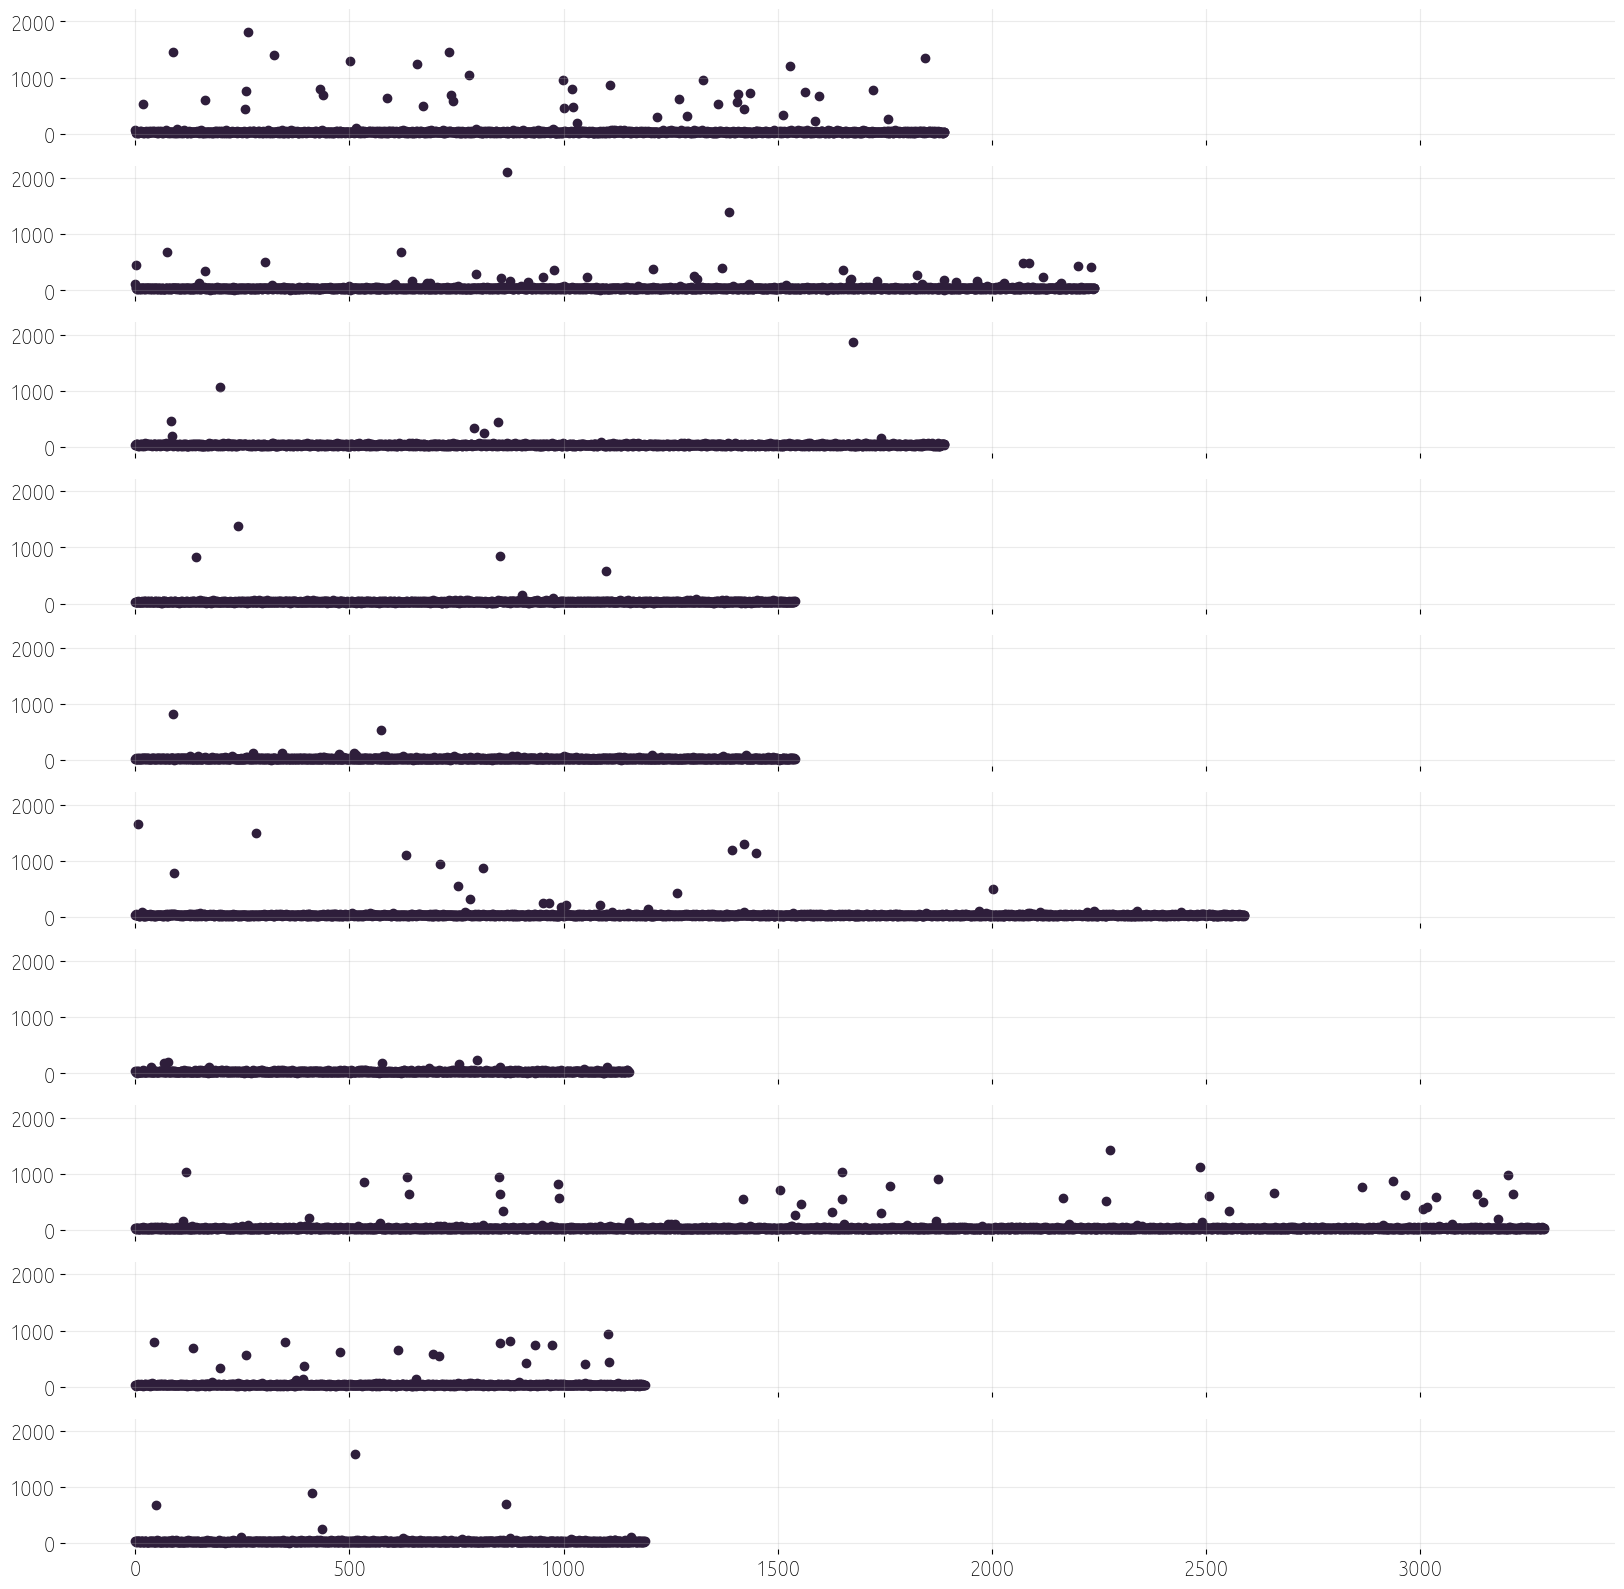

In [206]:

fig, axs = plt.subplots(10, 1, figsize = (20,20), sharex=True, sharey=True)
axs_idx = 0
axs = axs.flatten()
for genre in subset.Genre.unique().tolist():

    subs = subset.loc[(subset.Genre == genre)]['mean_verse_length'].reset_index(drop=True)
    axs[axs_idx].scatter(subs.index, subs.values)
    axs[axs_idx].set_frame_on(False)
    axs[axs_idx].grid(.25)
    axs_idx += 1
plt.savefig(f"figures/figure{fig_idx}.png")
fig_idx += 1
plt.show()

In [207]:
subset.loc[(subset.mean_verse_length > 100)]

,Genre,Lyrics,newlines,verses,mean_verse_length
1,Hip-Hop,"Yeah\nSometimes, i just wanna fly away.\nThey say i can't.\nI can't skate, i can't surf. I ain't from the streets the beach is my turf.\nI can't s...",18,"[Yeah, Sometimes, i just wanna fly away., They say i can't., I can't skate, i can't surf. I ain't from the streets the beach is my turf., I can't ...",115.5625
5,Hip-Hop,"(Mr. Gene Poole)\nLovin' this sound comin out to yo system\nI spark to get yall off to a good start. Show me some heart, walk through my hood afte...",6,"[(Mr. Gene Poole), Lovin' this sound comin out to yo system, I spark to get yall off to a good start. Show me some heart, walk through my hood aft...",458.2500
61,Pop,Maybe it's time to compromise Stop moving your mouth and use your eyes But I don't think so You think you know what people like Why don't you try ...,0,[Maybe it's time to compromise Stop moving your mouth and use your eyes But I don't think so You think you know what people like Why don't you try...,1648.0000
227,Metal,for all the thousands i've killed for all the children i've tortured for all the souls i've burned hear a demons cry you carved into me the darken...,0,[for all the thousands i've killed for all the children i've tortured for all the souls i've burned hear a demons cry you carved into me the darke...,522.0000
568,Folk,I thought you were the only one that I'd ever see. But you weren't the one to show me what it meant to believe.\nI thought that we had found a hom...,4,"[I thought you were the only one that I'd ever see. But you weren't the one to show me what it meant to believe., I thought that we had found a ho...",118.0000
...,...,...,...,...,...
18044,Indie,*Don't player hate on me. play- player hate on somebody else*\nYo. yo yo. I'm-i'm a gangster. where're my dogs at? bark with me if you're my dog.y...,18,"[*Don't player hate on me. play- player hate on somebody else*, Yo. yo yo. I'm-i'm a gangster. where're my dogs at? bark with me if you're my dog....",120.6250
18081,Rock,baby I don't practice sangria | maybe what he had was just green horn | every fucking day a thousand pools are being born | do you have the time t...,0,[baby I don't practice sangria | maybe what he had was just green horn | every fucking day a thousand pools are being born | do you have the time ...,975.0000
18152,Rock,"You're led to think we're free, a democratic race Told of equal rights well that's just not the case It couldn't happen to a democratic nation Afr...",0,"[You're led to think we're free, a democratic race Told of equal rights well that's just not the case It couldn't happen to a democratic nation Af...",640.0000
18178,Hip-Hop,"I was a dark dumb student, no hokey rookie daytrippin on visions of chickens that looked like R Crumb drew em. They grew em in the royal dirt of S...",7,"[I was a dark dumb student, no hokey rookie daytrippin on visions of chickens that looked like R Crumb drew em. They grew em in the royal dirt of ...",441.2500


Basically, relying on newline segmentation is not the best, but only ~200 samples have a mean verse length greater than 100. 

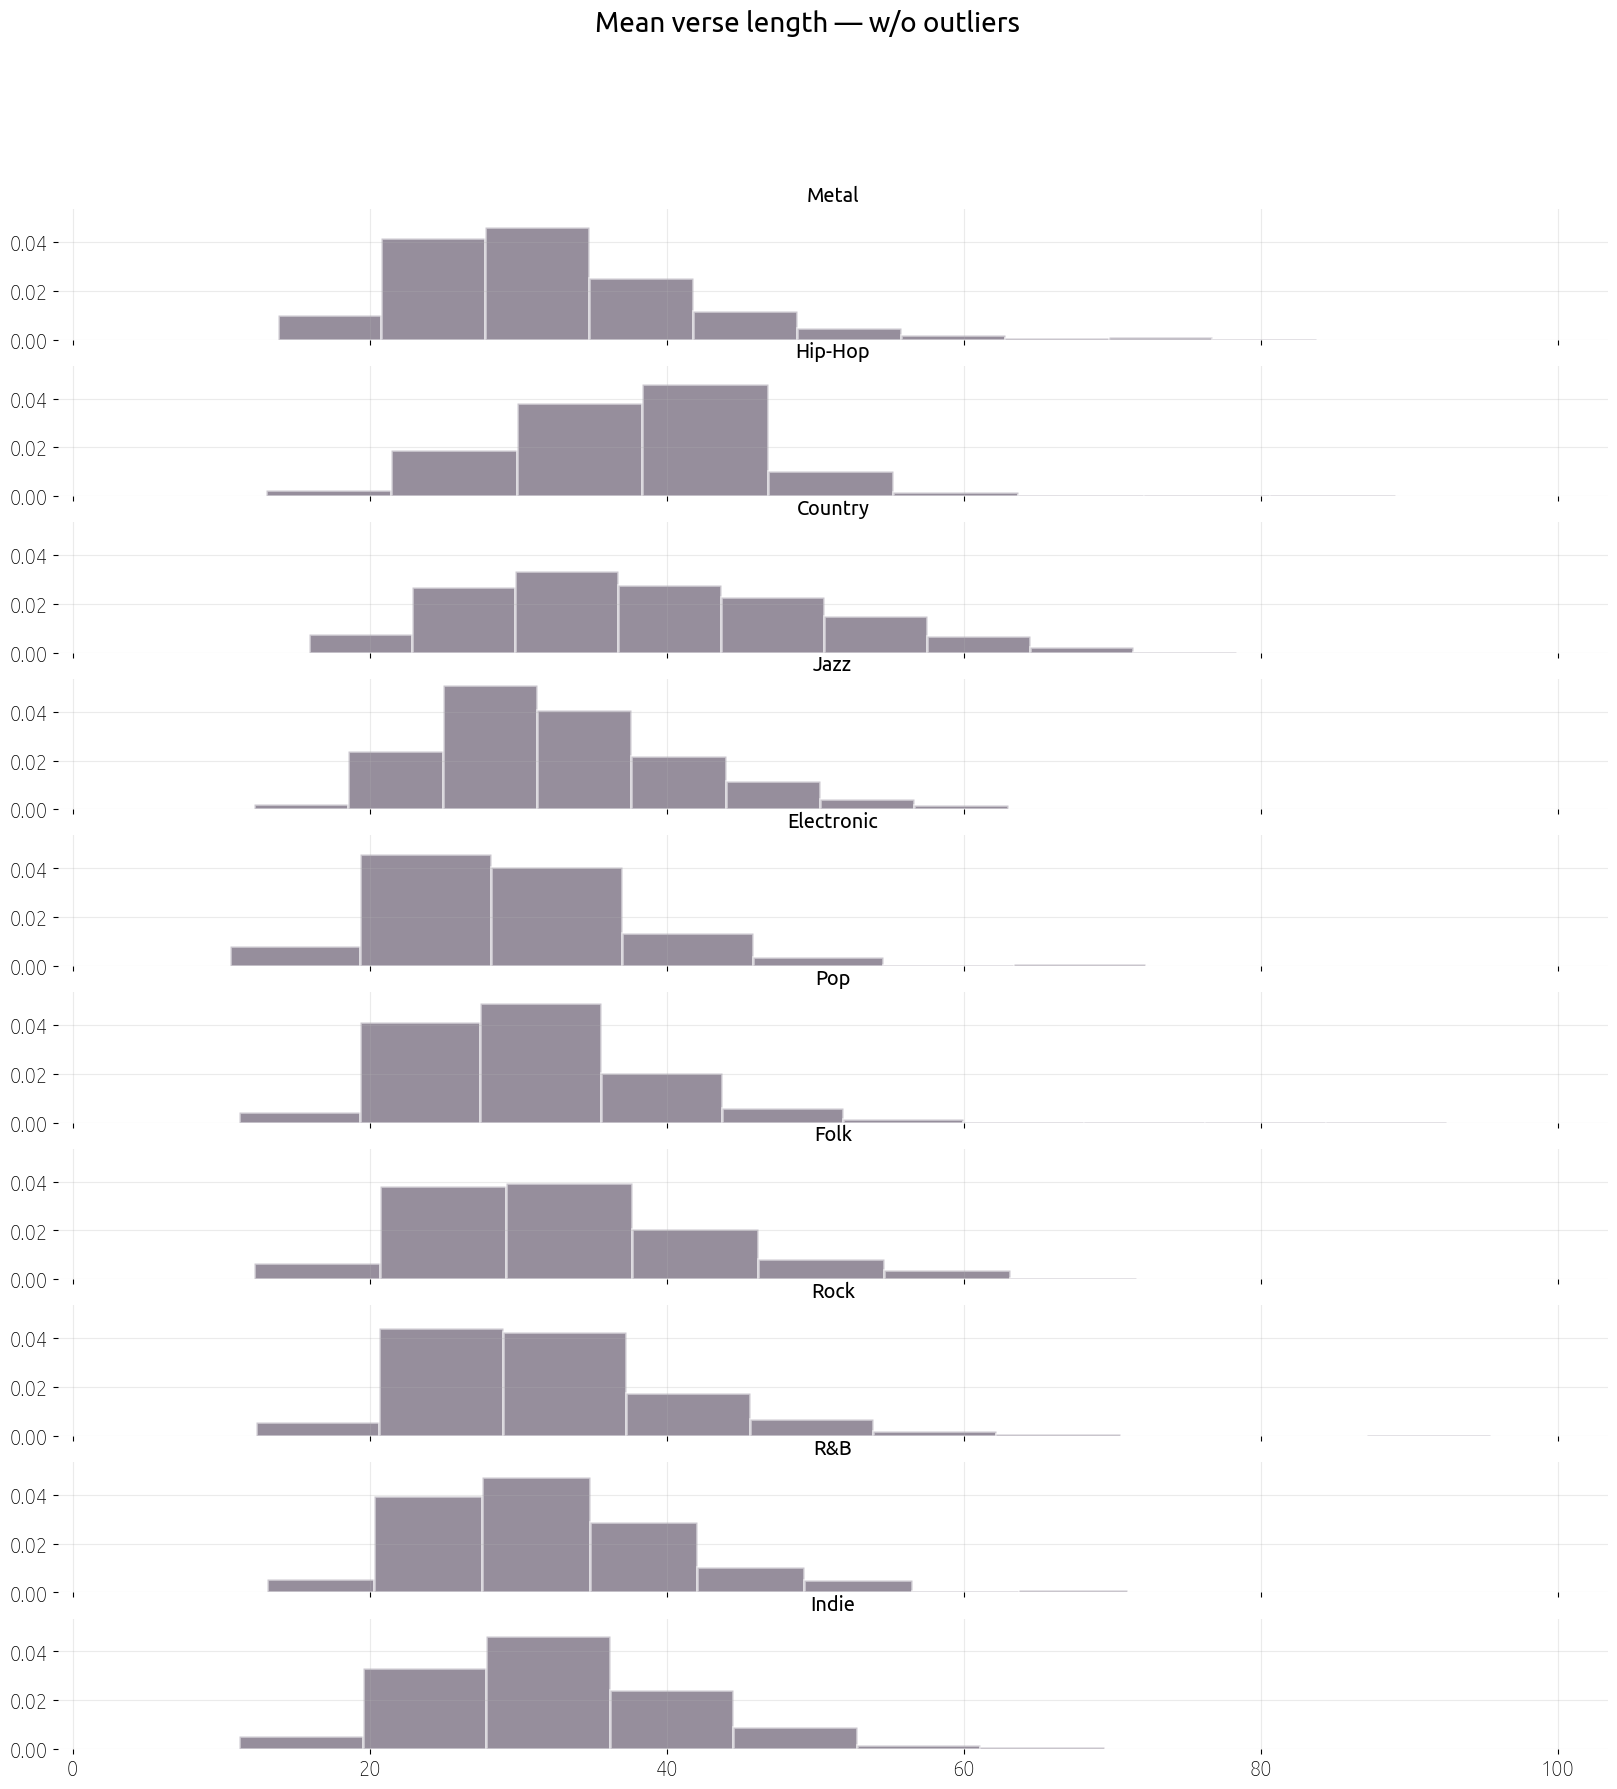

In [208]:

fig, axs = plt.subplots(10, 1, figsize = (20,20), sharex=True, sharey=True)
axs_idx = 0
axs = axs.flatten()
for genre in subset.Genre.unique().tolist():

    subs = subset.loc[(subset.Genre == genre)].loc[(subset.mean_verse_length < 100)]['mean_verse_length'].reset_index(drop=True)

    axs[axs_idx].hist(subs, alpha = .5, histtype = 'bar', edgecolor = 'white', linewidth = 2, density = True )
    axs[axs_idx].set_frame_on(False)
    axs[axs_idx].grid(.25)
    axs[axs_idx].set_title(genre)
    axs_idx += 1
plt.suptitle('Mean verse length \u2014 w/o outliers', fontsize = 20)
plt.savefig(f"figures/figure{fig_idx}.png")
fig_idx += 1
plt.show()


What about verse repetition?

In [209]:
subset['unique_verses'] = subset.verses.map(set)
subset['unique_verses_count'] = subset.unique_verses.map(len)

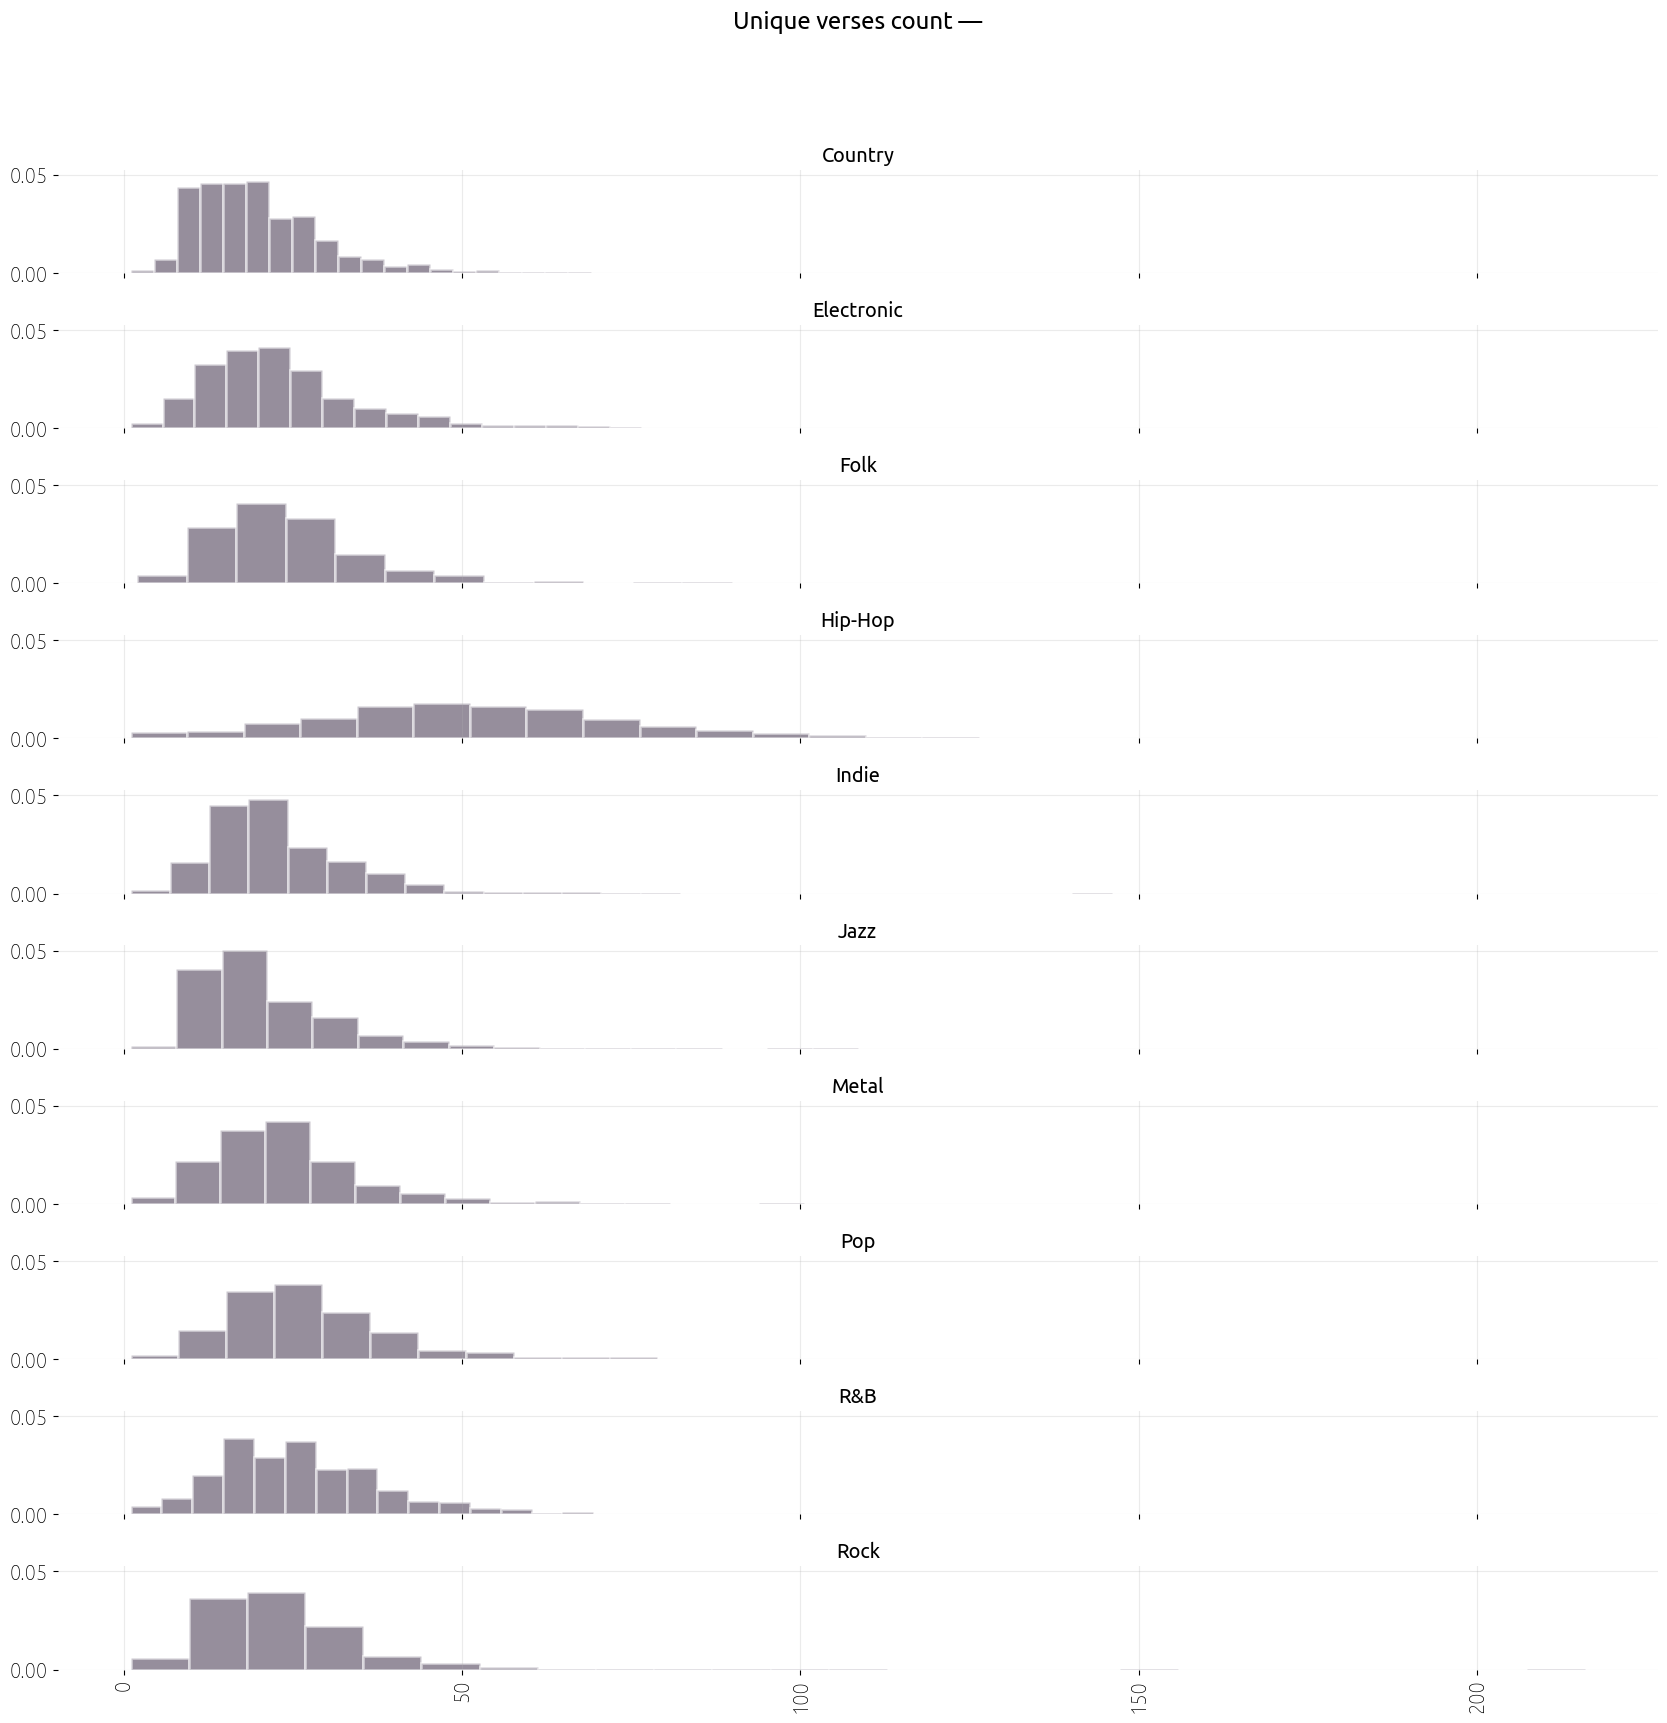

In [210]:
fig, axs = plt.subplots(10, 1, figsize = (20,20), sharex=True, sharey=True)
subset['unique_verses_count'].hist(by = subset['Genre'], bins = 25, legend = False, alpha = .5, histtype = 'bar', edgecolor = 'white', linewidth = 2, density = True, ax = axs)
for ax in axs.flatten():
    ax.set_frame_on(False)
    ax.grid(.25)
fig.suptitle("Unique verses count \u2014")

plt.savefig(f"figures/figure{fig_idx}.png")
fig_idx += 1
plt.show()

In [211]:
# Difference between verses count and unique verses count
subset.verses.map(len) - subset.verses.map(set).map(len) 

0         0
1         4
2         8
3         1
4         8
         ..
18508    10
18509    22
18510    15
18511    10
18512     5
Name: verses, Length: 18513, dtype: int64

In [212]:
subset['verse_counts'] = subset.verses.map(Counter)

In [213]:
# Disregarding single verses
subset['filtered_verse_counts'] = subset.verse_counts.map(lambda counts: {x: count for x, count in counts.items() if count > 1})

In [214]:
subset['repeated_verses_num'] = subset.filtered_verse_counts.map(len)

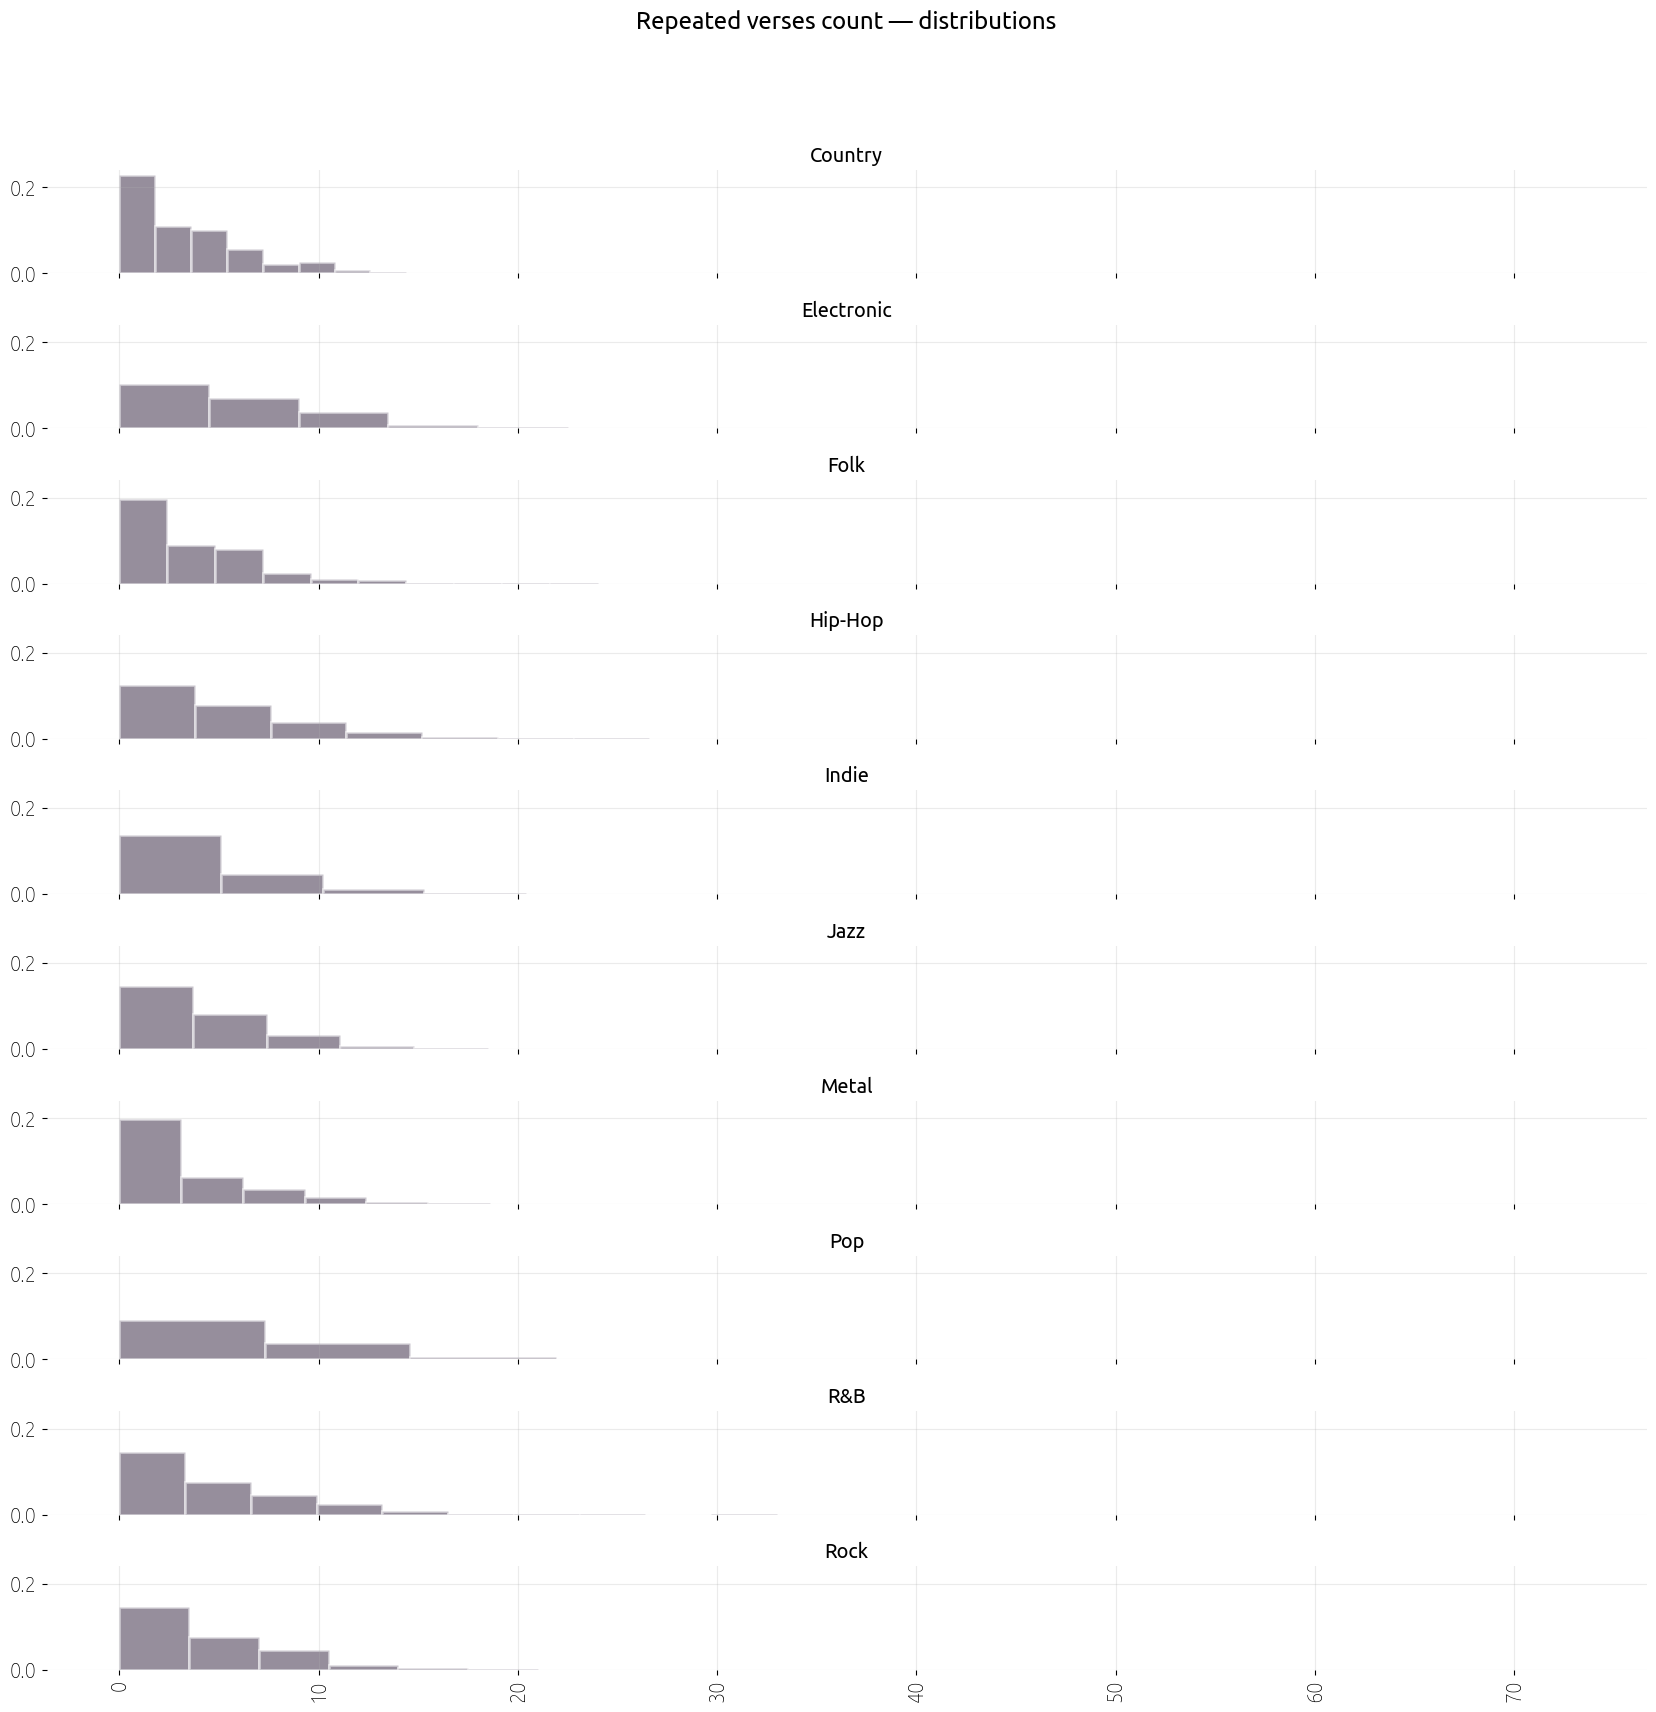

In [215]:
fig, axs = plt.subplots(10, 1, figsize = (20,20), sharex=True, sharey=True)
subset['repeated_verses_num'].hist(by = subset['Genre'], legend = False, alpha = .5, histtype = 'bar', edgecolor = 'white', linewidth = 2, density = True, ax = axs)
for ax in axs.flatten():
    ax.set_frame_on(False)
    ax.grid(.25)
fig.suptitle("Repeated verses count \u2014 distributions")

plt.savefig(f"figures/figure{fig_idx}.png")
fig_idx += 1
plt.show()

In [216]:
subset['filtered_verse_counts_mean_repetition_count'] = subset['filtered_verse_counts'].apply(lambda x: np.mean(list(x.values()))).fillna(0)

/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


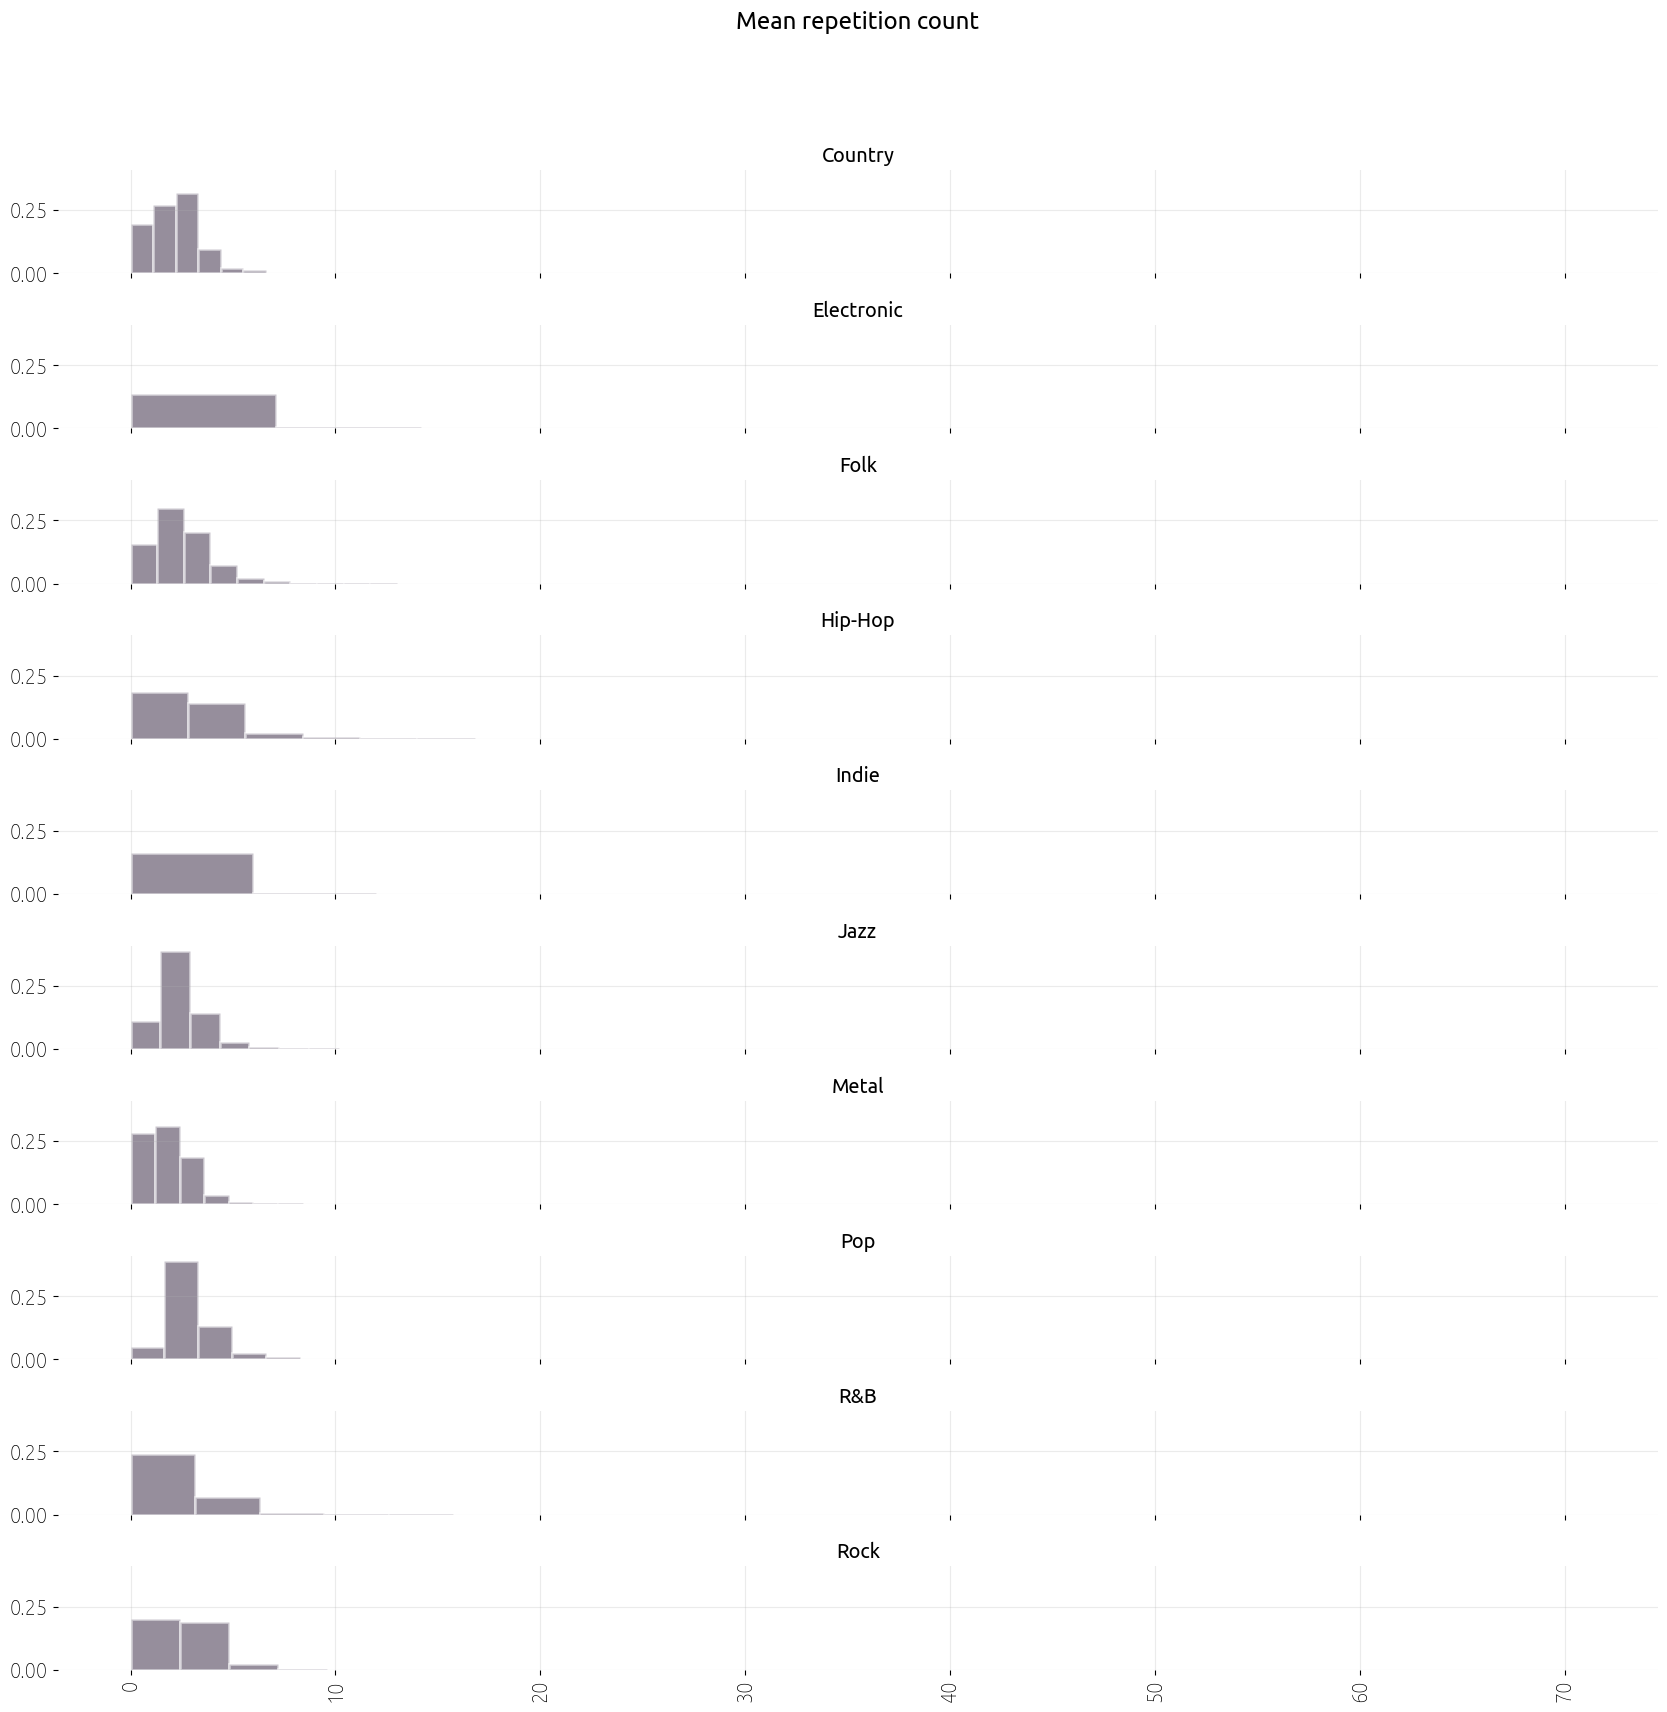

In [217]:
fig, axs = plt.subplots(10, 1, figsize = (20,20), sharex=True, sharey=True)
subset['filtered_verse_counts_mean_repetition_count'].hist(by = subset['Genre'], bins = 10, legend = False, alpha = .5, histtype = 'bar', edgecolor = 'white', linewidth = 2, density = True, ax = axs)
for ax in axs.flatten():
    ax.set_frame_on(False)
    ax.grid(.25)
fig.suptitle("Mean repetition count")

plt.savefig(f"figures/figure{fig_idx}.png")
fig_idx += 1
plt.show()

Contains chorus

In [218]:
subset['contains_chorus'] = subset.Lyrics.str.contains('chorus', case = False)

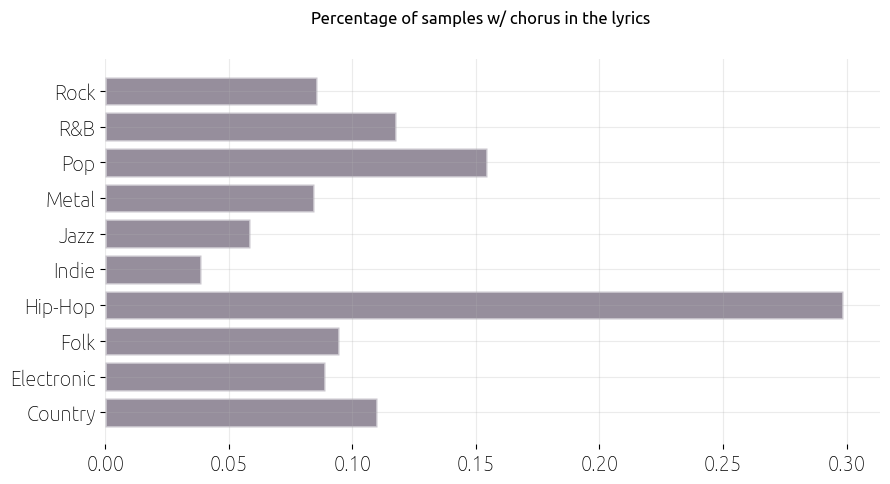

In [219]:
fig, axs = plt.subplots(1, 1, figsize = (10,5), sharex=True, sharey=True)
axs_idx = 0

chorus_true = subset.loc[subset['contains_chorus']].Genre.value_counts() / subset.Genre.value_counts()

plt.barh(chorus_true.index, chorus_true.values,  alpha = .5,  edgecolor = 'white', linewidth = 2,)
plt.box(False)
plt.suptitle('Percentage of samples w/ chorus in the lyrics', fontsize = 12)
plt.grid(.25)
plt.savefig(f"figures/figure{fig_idx}.png")
fig_idx += 1
plt.show()

I counts

In [220]:
subset['contains_I'] = subset.Lyrics.str.contains('I |I[^a-zA-Z\d\s:]').astype(int)

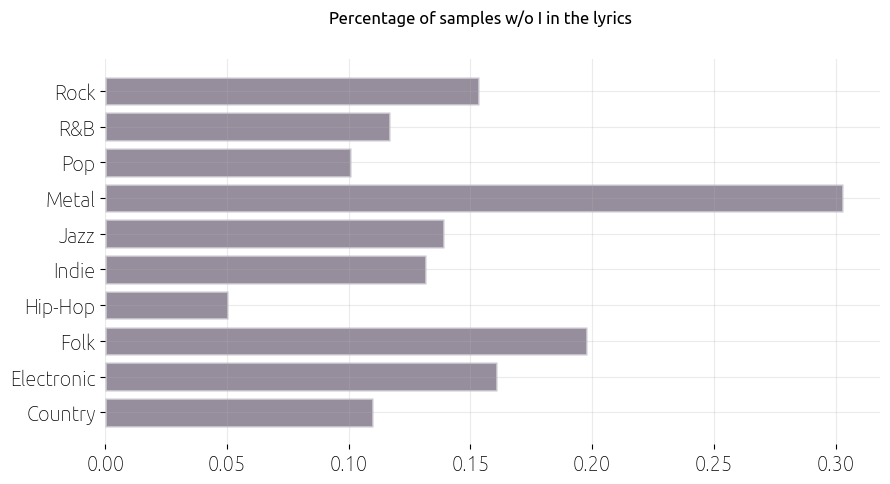

In [221]:

fig, axs = plt.subplots(1, 1, figsize = (10,5), sharex=True, sharey=True)
axs_idx = 0

contains_I = subset.loc[subset['contains_I'] == False].Genre.value_counts() / subset.Genre.value_counts()

plt.barh(contains_I.index, contains_I.values,  alpha = .5,  edgecolor = 'white', linewidth = 2,)
plt.box(False)
plt.suptitle('Percentage of samples w/o I in the lyrics', fontsize = 12)
plt.grid(.25)
plt.savefig(f"figures/figure{fig_idx}.png")
fig_idx += 1
plt.show()

Year references - four subsequent digits

In [222]:
subset.loc[subset.Lyrics.str.contains('^\d{4}')].Lyrics

825      1991 grilled cgeese goes on it's way to different cities\nRocking for the kiddies\nTo do shows for rows, no foes, dough in escrow\nAll the money w...
2697     1996, it began. Spawning a king, dawning a reign. Learn to live with pain and you won't complain. That which doesn't kill you, only makes you stro...
9720     1974\nSweet voices calling wild, echoing around this child\nSweet Faith I'll be joining you, when my story's over\nDee doo doo doo dah dee doo doo...
13988    1986 Version\nSuicide rate going up\nHomicide cases piling up\nRape and killing even with innocent little children\nTo those that can really see\n...
16252    5000 letters I keep in my bedroom\n5000 people who open their hearts\nOnce they were strangers today, we are family\nMountains won't keep us apart...
16625    2000 and beyond\n2000 and beyond\n2000 and beyond\nTricks and hoes, bitches and stripper poles\nshake it for dollar signs, let me see from behind\...
17071    2000, 2000, this is not ours anymore,

Quotes and references

For double quotes it is easier to find them.

In [223]:
subset['double_quotes'] = subset.Lyrics.str.contains('"').astype(int)

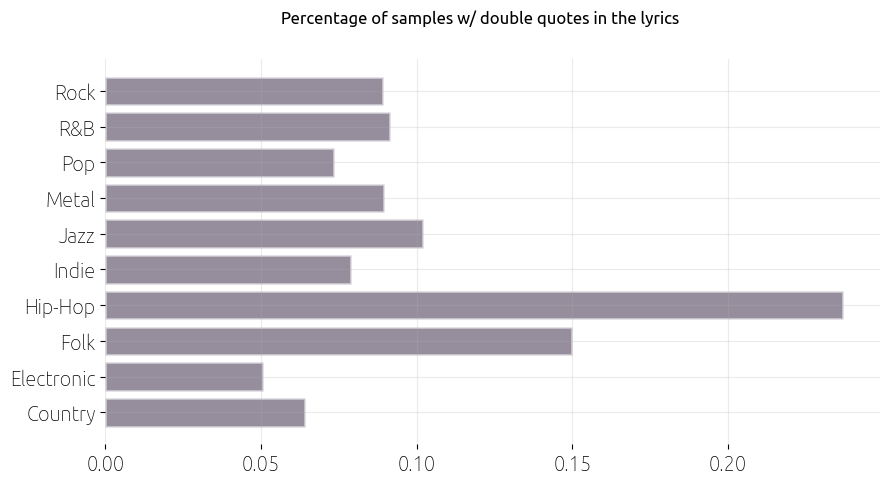

In [224]:

fig, axs = plt.subplots(1, 1, figsize = (10,5), sharex=True, sharey=True)
axs_idx = 0

contains_I = subset.loc[subset['double_quotes'] == True].Genre.value_counts() / subset.Genre.value_counts()

plt.barh(contains_I.index, contains_I.values,  alpha = .5,  edgecolor = 'white', linewidth = 2,)
plt.box(False)
plt.suptitle('Percentage of samples w/ double quotes in the lyrics', fontsize = 12)
plt.grid(.25)
plt.savefig(f"figures/figure{fig_idx}.png")
fig_idx += 1
plt.show()

What about containing a question?

In [225]:
subset['contains_question'] = subset.Lyrics.str.contains('\?').astype(int)

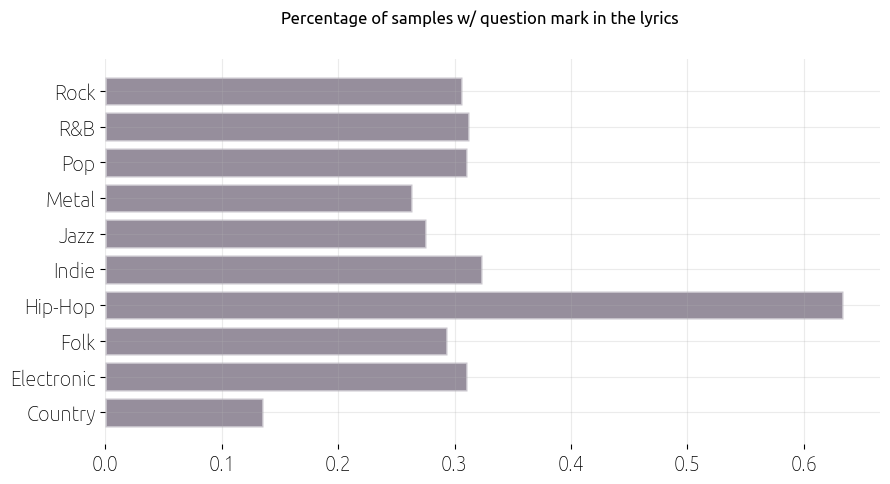

In [226]:
fig, axs = plt.subplots(1, 1, figsize = (10,5), sharex=True, sharey=True)
axs_idx = 0

contains_q = subset.loc[subset['contains_question'] == True].Genre.value_counts() / subset.Genre.value_counts()

plt.barh(contains_q.index, contains_q.values,  alpha = .5,  edgecolor = 'white', linewidth = 2,)
plt.box(False)
plt.suptitle('Percentage of samples w/ question mark in the lyrics', fontsize = 12)
plt.grid(.25)
plt.savefig(f"figures/figure{fig_idx}.png")
fig_idx += 1
plt.show()

In [227]:
subset['question_count'] = subset.Lyrics.str.count('\?').astype(int)

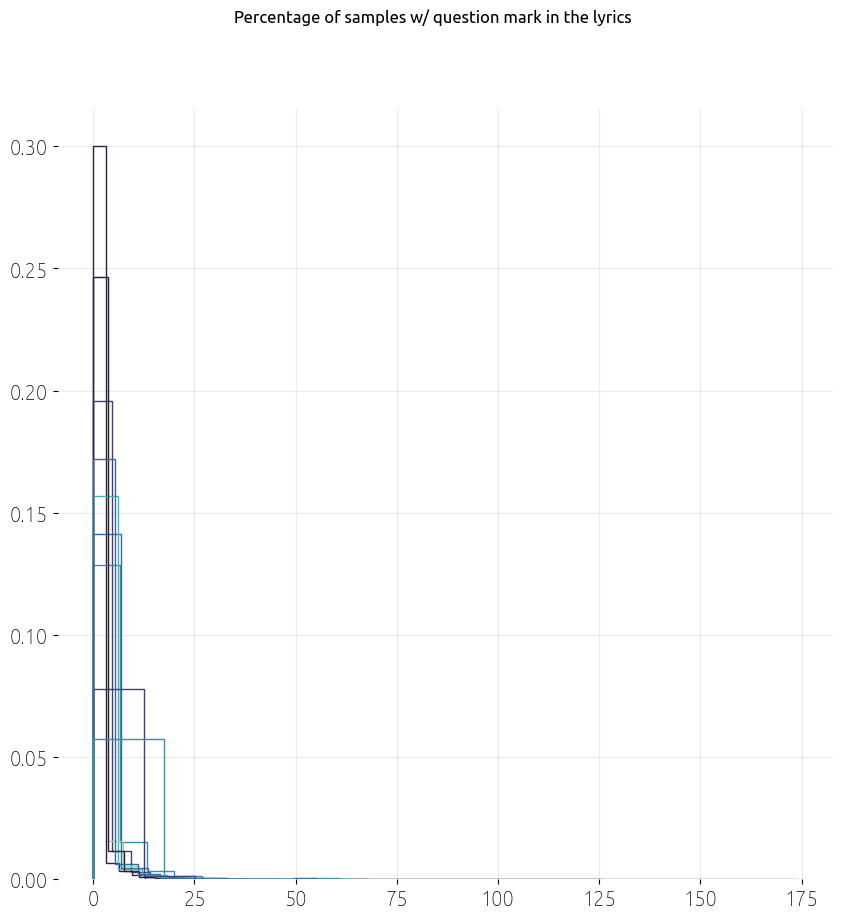

In [228]:
fig = plt.figure(figsize = (10, 10))
axs_idx = 0

subset.groupby('Genre')['question_count'].hist(density = True, histtype = 'step')

plt.box(False)
plt.suptitle('Percentage of samples w/ question mark in the lyrics', fontsize = 12)
plt.grid(.25)
plt.savefig(f"figures/figure{fig_idx}.png")
fig_idx += 1
plt.show()

In [229]:
subset['contains_exclamation'] = subset.Lyrics.str.contains('!').astype(int)

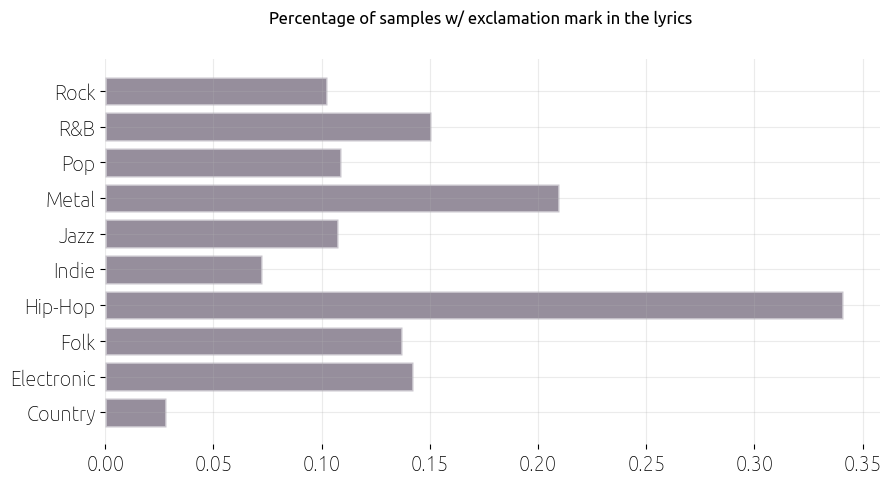

In [230]:

fig, axs = plt.subplots(1, 1, figsize = (10,5), sharex=True, sharey=True)
axs_idx = 0

contains_e = subset.loc[subset['contains_exclamation'] == True].Genre.value_counts() / subset.Genre.value_counts()

plt.barh(contains_e.index, contains_e.values,  alpha = .5,  edgecolor = 'white', linewidth = 2,)
plt.box(False)
plt.suptitle('Percentage of samples w/ exclamation mark in the lyrics', fontsize = 12)
plt.grid(.25)
plt.savefig(f"figures/figure{fig_idx}.png") 
fig_idx += 1
plt.show()

In [231]:
subset['contains_profanity_1'] = subset.Lyrics.str.contains("bitch|fuck")

subset['contains_profanity_2'] = subset.Lyrics.str.contains("shit")
subset['profanity_count'] = subset.Lyrics.str.count('shit|bitch|fuck')

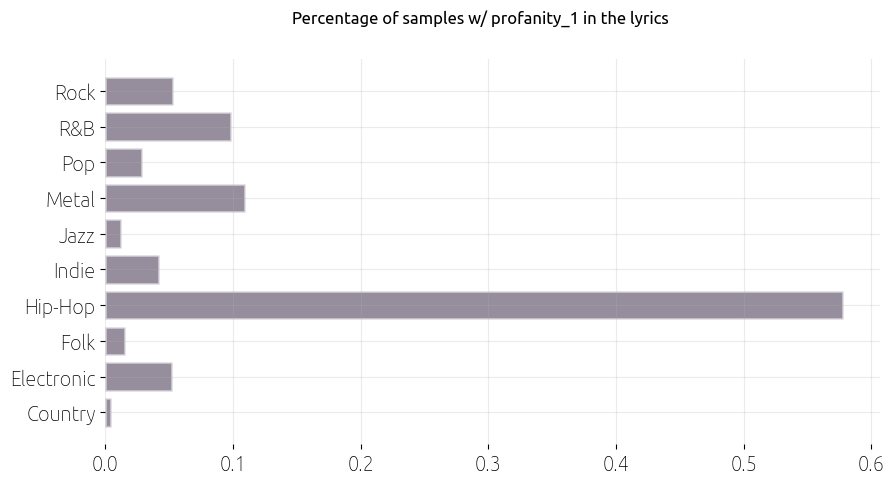

In [232]:


fig, axs = plt.subplots(1, 1, figsize = (10,5), sharex=True, sharey=True)
axs_idx = 0

contains_p = subset.loc[subset['contains_profanity_1'] == True].Genre.value_counts() / subset.Genre.value_counts()

plt.barh(contains_p.index, contains_p.values,  alpha = .5,  edgecolor = 'white', linewidth = 2,)
plt.box(False)
plt.suptitle('Percentage of samples w/ profanity_1 in the lyrics', fontsize = 12)
plt.grid(.25)
plt.savefig(f"figures/figure{fig_idx}.png")
fig_idx += 1
plt.show()

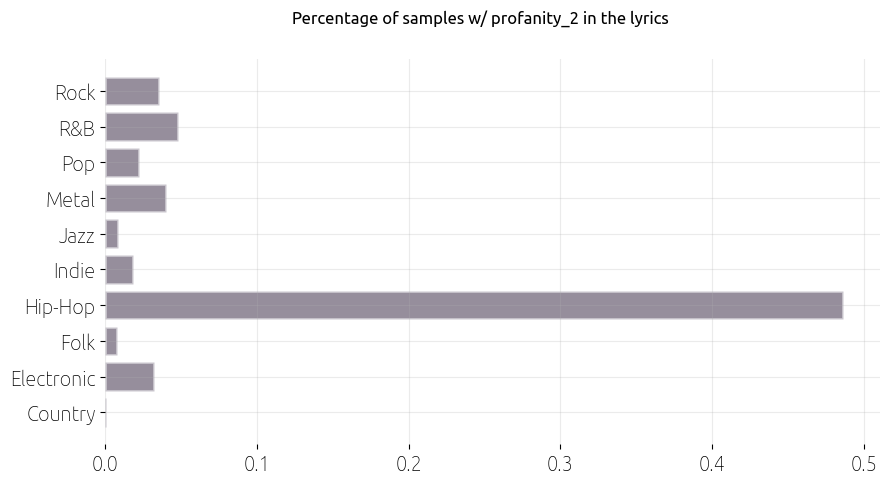

In [233]:


fig, axs = plt.subplots(1, 1, figsize = (10,5), sharex=True, sharey=True)
axs_idx = 0

contains_p = subset.loc[subset['contains_profanity_2'] == True].Genre.value_counts() / subset.Genre.value_counts()

plt.barh(contains_p.index, contains_p.values,  alpha = .5,  edgecolor = 'white', linewidth = 2,)
plt.box(False)
plt.suptitle('Percentage of samples w/ profanity_2 in the lyrics', fontsize = 12)
plt.grid(.25)
plt.savefig(f"figures/figure{fig_idx}.png")
fig_idx += 1
plt.show()

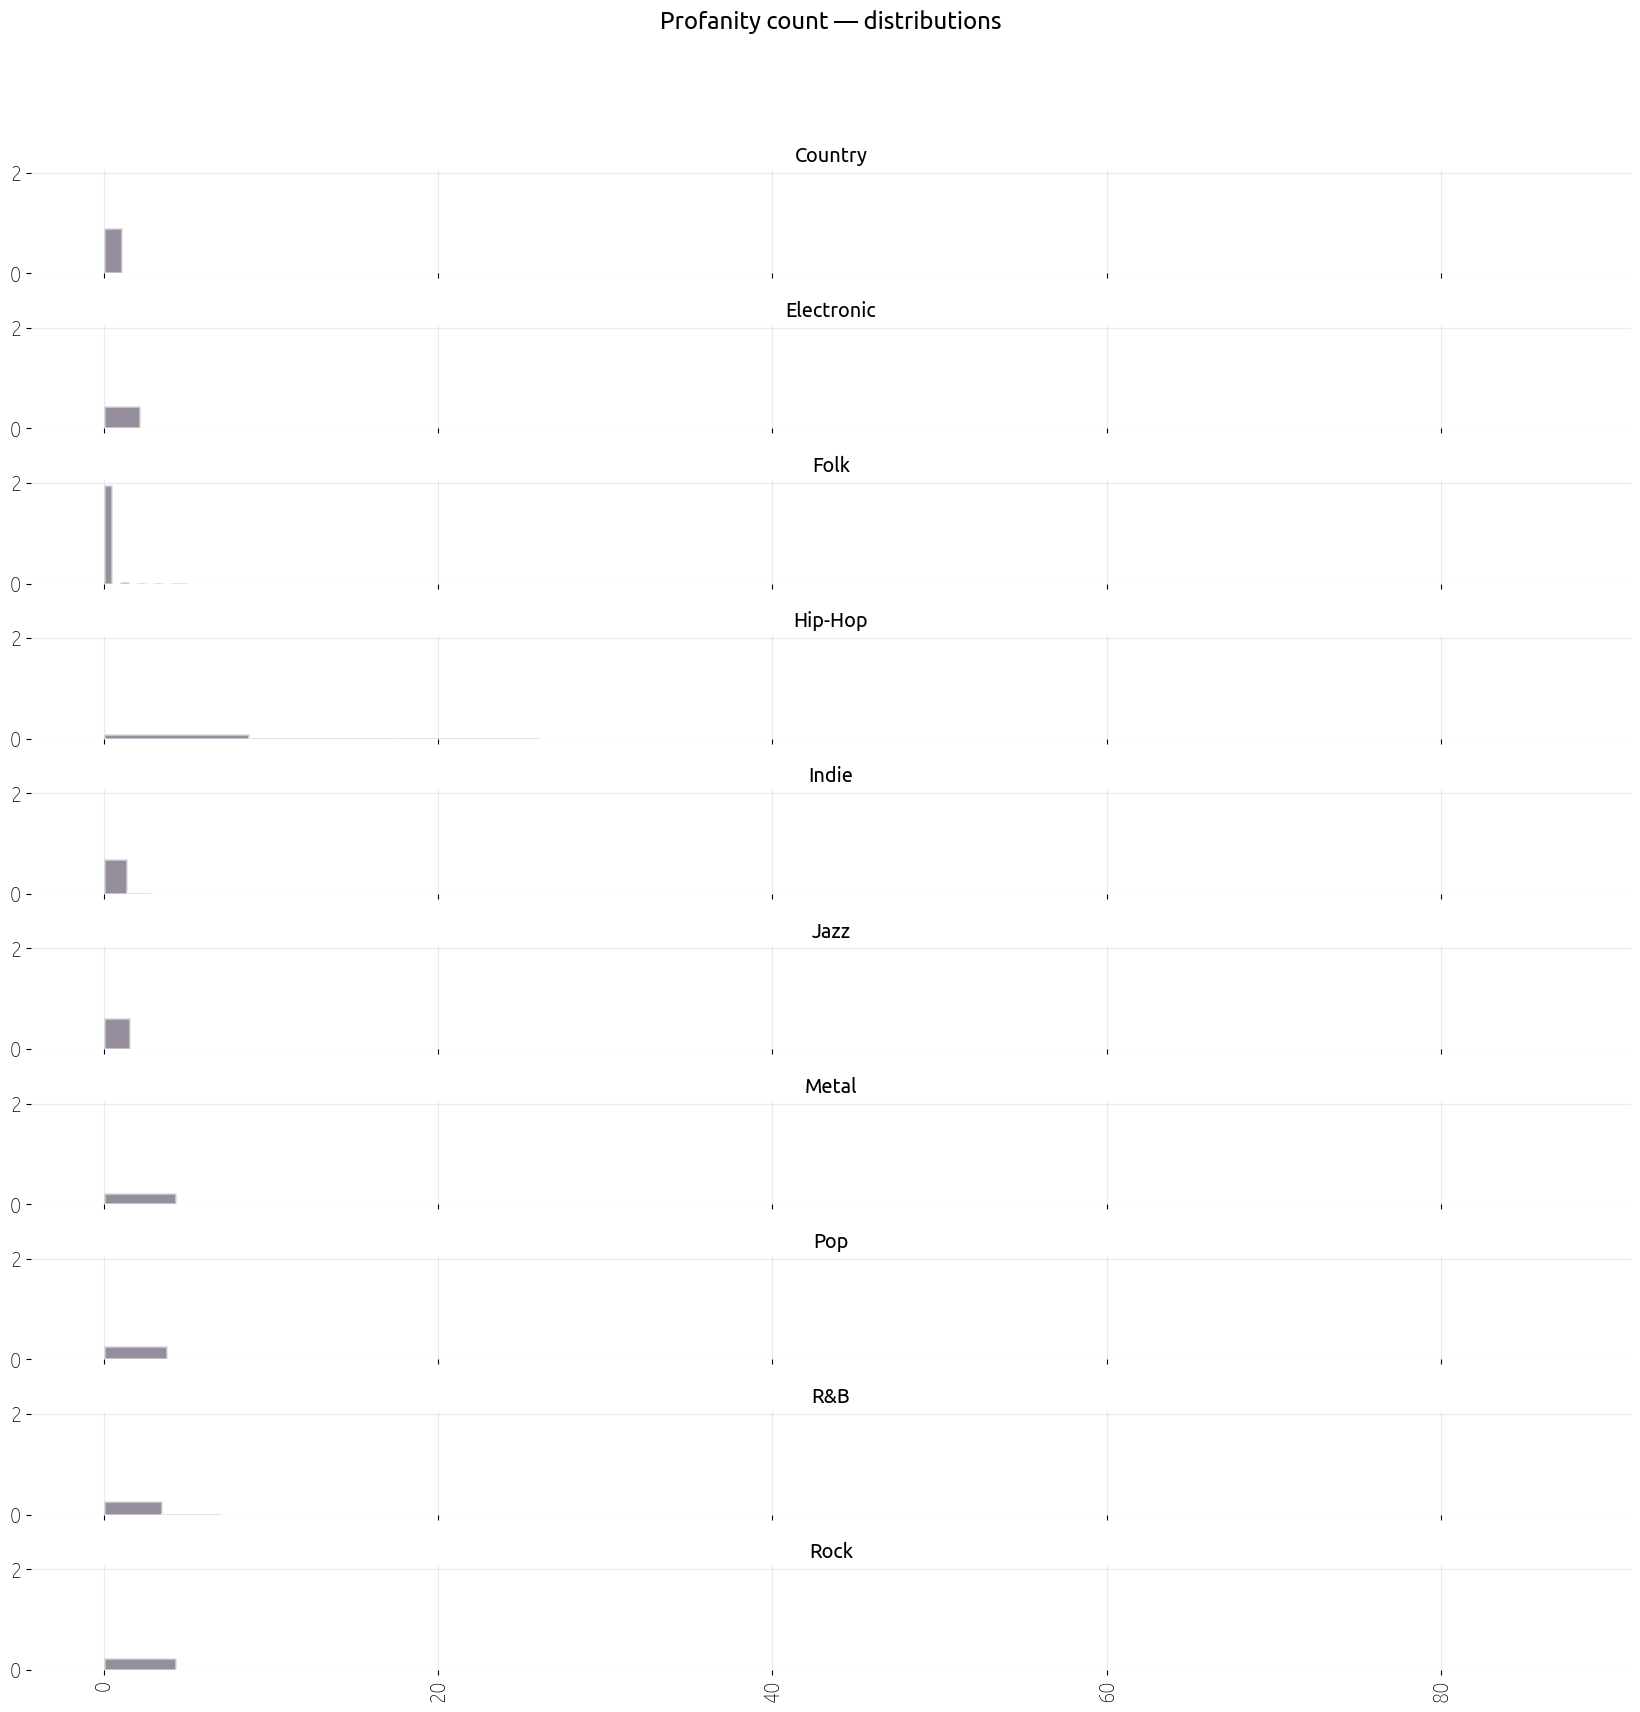

In [234]:
fig, axs = plt.subplots(10, 1, figsize = (20,20), sharex=True, sharey=True)
subset['profanity_count'].hist(by = subset['Genre'],  legend = False, alpha = .5, histtype = 'bar', edgecolor = 'white', linewidth = 2, density = True, ax = axs)
for ax in axs.flatten():
    ax.set_frame_on(False)
    ax.grid(.25)
fig.suptitle("Profanity count \u2014 distributions")

plt.savefig(f"figures/figure{fig_idx}.png")
fig_idx += 1
plt.show()

Interestingly, country music almost never contains one of these.

What about topic describing words?


In [235]:
subset['topic_1'] = subset.Lyrics.str.contains("baby")

A common theme in pop songs.

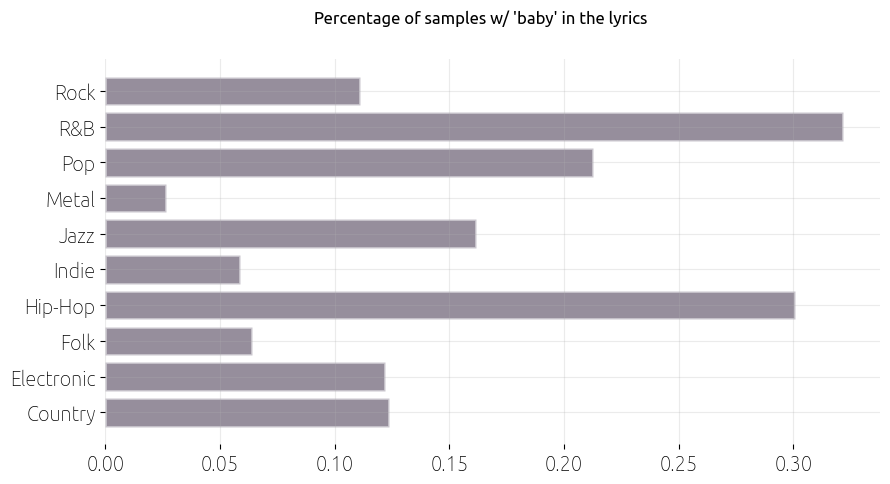

In [236]:
fig, axs = plt.subplots(1, 1, figsize = (10,5), sharex=True, sharey=True)
axs_idx = 0

contains_p = subset.loc[subset['topic_1'] == True].Genre.value_counts() / subset.Genre.value_counts()

plt.barh(contains_p.index, contains_p.values,  alpha = .5,  edgecolor = 'white', linewidth = 2,)
plt.box(False)
plt.suptitle('Percentage of samples w/ \'baby\' in the lyrics', fontsize = 12)
plt.grid(.25)
plt.savefig(f"figures/figure{fig_idx}.png")
fig_idx += 1
plt.show()

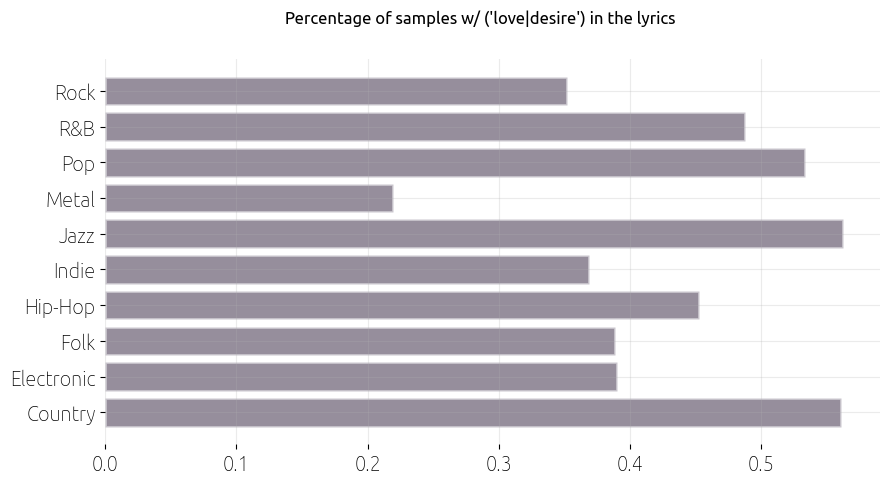

In [237]:

subset['topic_2'] = subset.Lyrics.str.contains("love|desire")
fig, axs = plt.subplots(1, 1, figsize = (10,5), sharex=True, sharey=True)
axs_idx = 0

contains_p = subset.loc[subset['topic_2'] == True].Genre.value_counts() / subset.Genre.value_counts()

plt.barh(contains_p.index, contains_p.values,  alpha = .5,  edgecolor = 'white', linewidth = 2,)
plt.box(False)
plt.suptitle('Percentage of samples w/ (\'love|desire\') in the lyrics', fontsize = 12)
plt.grid(.25)
plt.savefig(f"figures/figure{fig_idx}.png")
fig_idx += 1
plt.show()

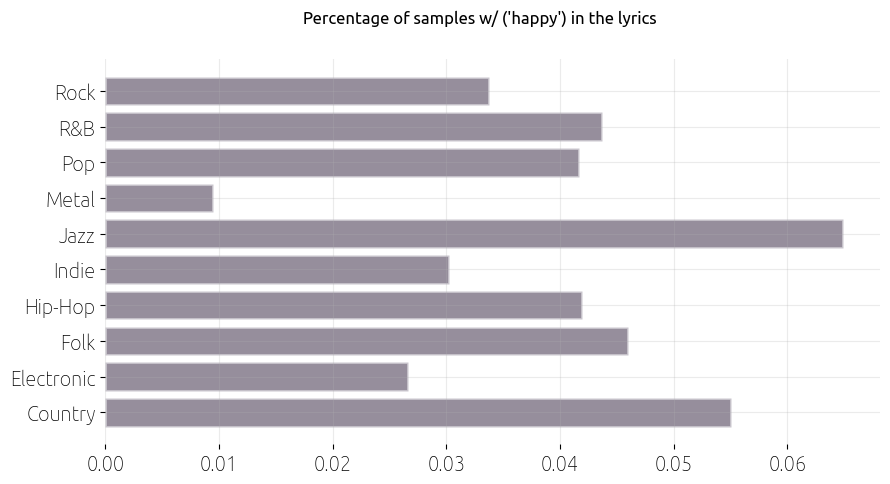

In [238]:


subset['topic_3'] = subset.Lyrics.str.contains("happy")
fig, axs = plt.subplots(1, 1, figsize = (10,5), sharex=True, sharey=True)
axs_idx = 0

contains_p = subset.loc[subset['topic_3'] == True].Genre.value_counts() / subset.Genre.value_counts()

plt.barh(contains_p.index, contains_p.values,  alpha = .5,  edgecolor = 'white', linewidth = 2,)
plt.box(False)
plt.suptitle('Percentage of samples w/ (\'happy\') in the lyrics', fontsize = 12)
plt.grid(.25)
plt.savefig(f"figures/figure{fig_idx}.png")
fig_idx += 1
plt.show()

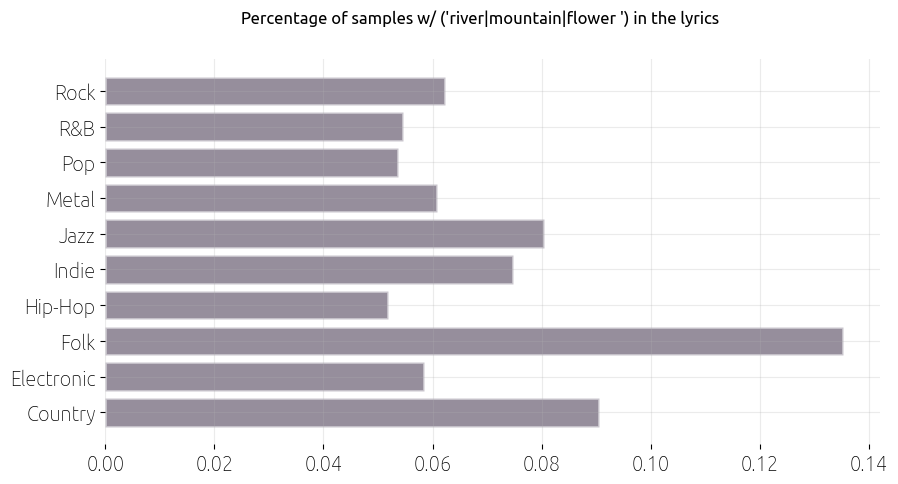

In [239]:
subset['topic_4'] = subset.Lyrics.str.contains("river|mountain|flower")
fig, axs = plt.subplots(1, 1, figsize = (10,5), sharex=True, sharey=True)
axs_idx = 0

contains_p = subset.loc[subset['topic_4'] == True].Genre.value_counts() / subset.Genre.value_counts()

plt.barh(contains_p.index, contains_p.values,  alpha = .5,  edgecolor = 'white', linewidth = 2,)
plt.box(False)
plt.suptitle('Percentage of samples w/ (\'river|mountain|flower \') in the lyrics', fontsize = 12)
plt.grid(.25)
plt.savefig(f"figures/figure{fig_idx}.png")
fig_idx += 1
plt.show()

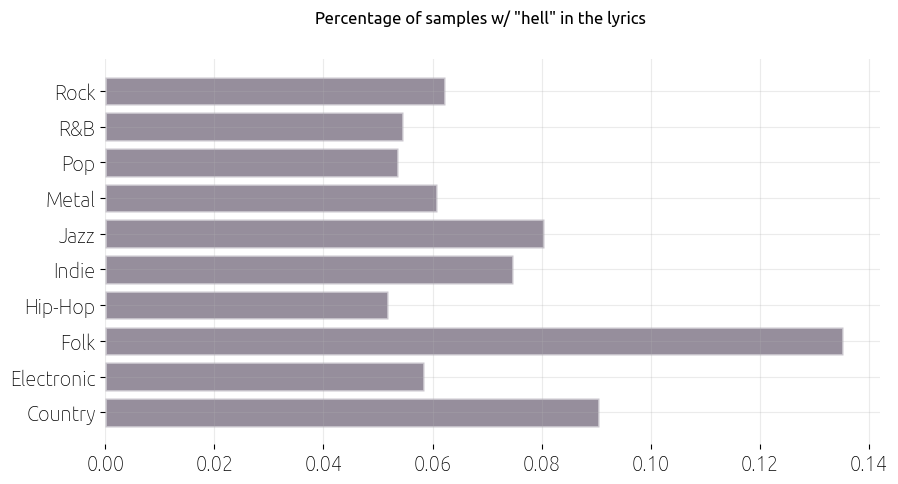

In [240]:
subset['topic_5'] = subset.Lyrics.str.contains("hell")
fig, axs = plt.subplots(1, 1, figsize = (10,5), sharex=True, sharey=True)
axs_idx = 0

contains_p = subset.loc[subset['topic_4'] == True].Genre.value_counts() / subset.Genre.value_counts()

plt.barh(contains_p.index, contains_p.values,  alpha = .5,  edgecolor = 'white', linewidth = 2,)
plt.box(False)
plt.suptitle('Percentage of samples w/ "hell" in the lyrics', fontsize = 12)
plt.grid(.25)
plt.savefig(f"figures/figure{fig_idx}.png")
fig_idx += 1
plt.show()

In [128]:
subset.Lyrics.duplicated().value_counts()

False    18513
Name: Lyrics, dtype: int64

#### Modeling

In [278]:
def add_custom_features(dataframe):
    dataframe['verses'] = dataframe['Lyrics'].str.split('\n')
    dataframe['mean_verse_length'] = dataframe.verses.map(get_mean_verse_length)
    dataframe['unique_verses'] = dataframe.verses.map(set)
    dataframe['unique_verses_count'] = dataframe.unique_verses.map(len)
    dataframe['verse_counts'] = dataframe.verses.map(Counter)
    dataframe['filtered_verse_counts'] = dataframe.verse_counts.map(lambda counts: {x: count for x, count in counts.items() if count > 1})
    dataframe['repeated_verses_num'] = dataframe.filtered_verse_counts.map(len)
    dataframe['filtered_verse_counts_mean_repetition_count'] = dataframe['filtered_verse_counts'].apply(lambda x: np.mean(list(x.values()))).fillna(0)
    dataframe['contains_chorus'] = dataframe.Lyrics.str.contains('chorus', case = False).astype(int)
    dataframe['contains_I'] = dataframe.Lyrics.str.contains('I |I[^a-zA-Z\d\s:]').astype(int)
    dataframe['double_quotes'] = dataframe.Lyrics.str.contains('"').astype(int)
    dataframe['contains_question'] = dataframe.Lyrics.str.contains('\?').astype(int)
    dataframe['contains_exclamation'] = dataframe.Lyrics.str.contains('!').astype(int)

    dataframe['question_count'] = dataframe.Lyrics.str.count('\?').astype(int)
    dataframe['contains_profanity_1'] = dataframe.Lyrics.str.contains("bitch|fuck", case = False).astype(int)

    dataframe['contains_profanity_2'] = dataframe.Lyrics.str.contains("shit", case = False).astype(int)
    dataframe['profanity_count'] = dataframe.Lyrics.str.count('shit|bitch|fuck').astype(int)
    dataframe['random_words_1'] = dataframe.Lyrics.str.contains("baby", case = False).astype(int)
    dataframe['random_words_2'] = dataframe.Lyrics.str.contains("love", case = False).astype(int)
    dataframe['random_words_3'] = dataframe.Lyrics.str.contains("happy", case = False).astype(int)
    dataframe['random_words_4'] = dataframe.Lyrics.str.contains("river|mountain", case = False).astype(int)
    dataframe['random_words_5'] = dataframe.Lyrics.str.contains("hell", case = False).astype(int)
    
    return dataframe

In [267]:
def get_mean_verse_length(verses):
    return np.mean([len(verse) for verse in verses], dtype = np.float16)

In [243]:
X_train, Y_train = train_data['Lyrics'], train_data['Genre']
X_test, Y_test = test_data['Lyrics'], test_data['Genre']

In [244]:
label_encoder = LabelEncoder()
label_encoder.fit(Y_train)
Y_train = label_encoder.transform(Y_train)
Y_test = label_encoder.transform(Y_test)

In [245]:
# Y_train = Y_train.astype('category').cat.codes
# Y_test = Y_test.astype('category').cat.codes

In [246]:
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(18513,) (18513,) (7935,) (7935,)


In [247]:
# train, valid = train_test_split(train_data, test_size= .15, random_state = SEED, stratify = train_data['Genre'])

In [248]:

# train.loc[:,'Genre'] = label_encoder.transform(train.loc[:,'Genre'])
# valid.loc[:,'Genre'] = label_encoder.transform(valid.loc[:,'Genre'])

In [249]:
# X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size= .15, random_state = SEED, stratify = Y_train)

In [250]:
# # Cudf series
# X_train_ = cudf.Series(X_train)
# X_valid_ = cudf.Series(X_valid)
# Y_train_ = cudf.Series(Y_train)
# Y_valid_ = cudf.Series(Y_valid)

In [326]:
# Tracking
# mlflow.get_tracking_uri()

In [252]:
label_encoder.classes_.tolist()

['Country',
 'Electronic',
 'Folk',
 'Hip-Hop',
 'Indie',
 'Jazz',
 'Metal',
 'Pop',
 'R&B',
 'Rock']

In [ ]:
# mlflow.set_experiment(experiment_name='base-models-comparison')

In [31]:
stratified_k = StratifiedKFold(n_splits = 3, shuffle=True, random_state = RANDOM_SEED)

#### Base models comparison

In [249]:
metrics = []
vectorizer_1 = CountVectorizer(ngram_range=(1,1))
vectorizer_2 = CountVectorizer(ngram_range=(1,2))
vectorizer_3 = CountVectorizer(ngram_range=(1,3))

vectorizer_4 = TfidfVectorizer(ngram_range=(1,1))
vectorizer_5 = TfidfVectorizer(ngram_range=(1,2))
vectorizer_6 = TfidfVectorizer(ngram_range=(1,3))
models = [
    # LogisticRegression(),
    # KNeighborsClassifier(),
    # RandomForestClassifier(n_jobs=-1),
    # XGBClassifier(tree_method = 'gpu_hist'),
    # LGBMClassifier(),
    SVC(decision_function_shape = 'ovo', class_weight='balanced')  
]
vectorizers = [
    vectorizer_1,
    vectorizer_2,
    # vectorizer_3,
    vectorizer_4,
    vectorizer_5,
    # vectorizer_6,

]

In [250]:
vectorizer_1 = CountVectorizer(stop_words='english')
x_train = vectorizer_1.fit_transform(X_train)
x_train.shape

(18513, 61405)

In [36]:
vectorizer_1 = CountVectorizer(stop_words='english')
x_train = vectorizer_1.fit_transform(X_train)
x_train.shape

(18513, 61405)

In [37]:
vectorizer_1 = CountVectorizer(min_df=5)

x_train = vectorizer_1.fit_transform(X_train)
x_train.shape

(18513, 15939)

In [38]:
vectorizer_1 = CountVectorizer(min_df=5, max_df=.75)
x_train = vectorizer_1.fit_transform(X_train)
x_train.shape

(18513, 15933)

In [42]:
vectorizer_1 = CountVectorizer(min_df=5, max_df=.3)
x_train = vectorizer_1.fit_transform(X_train)
x_train.shape

(18513, 15885)

In [ ]:
vectorizer_1 = CountVectorizer(min_df=5, stop_words='english', )
x_train = vectorizer_1.fit_transform(X_train)
x_train.shape

In [40]:
vectorizer_1.vocabulary_

{'am': 476,
 'night': 9401,
 'darkness': 3603,
 'only': 9651,
 'soul': 12985,
 'lost': 8267,
 'walk': 15245,
 'throught': 14212,
 'forest': 5545,
 'everything': 4880,
 'stays': 13318,
 'behind': 1244,
 'waiting': 15238,
 'another': 582,
 'chance': 2361,
 'calls': 2083,
 'capture': 2154,
 'eyes': 5014,
 'wait': 15234,
 'end': 4694,
 'see': 12139,
 'today': 14333,
 'carry': 2207,
 'shadow': 12287,
 'call': 2076,
 'name': 9236,
 'light': 8080,
 'mind': 8840,
 'touch': 14419,
 'final': 5295,
 'thoughts': 14180,
 'hearing': 6542,
 'whispering': 15501,
 'from': 5699,
 'cold': 2822,
 'inside': 7256,
 'still': 13372,
 'truth': 14651,
 'dreaming': 4359,
 'enchanting': 4686,
 'woods': 15690,
 'dream': 4354,
 'feel': 5194,
 'sun': 13653,
 'will': 15564,
 'burn': 1968,
 'anything': 613,
 'yeah': 15824,
 'sometimes': 12943,
 'just': 7645,
 'wanna': 15276,
 'fly': 5480,
 'away': 909,
 'they': 14138,
 'say': 11963,
 'skate': 12628,
 'surf': 13702,
 'ain': 375,
 'streets': 13466,
 'beach': 1145,
 'tur

In [251]:
vectorizer_1.fit(X_train)
x_train = vectorizer_1.fit_transform(X_train)
x_train.dtype


dtype('int64')

In [252]:

x_train = x_train.astype(np.float32)
y_train = Y_train.astype(np.float32)

In [253]:
x_train.shape, x_train.dtype, y_train.shape, y_train.dtype

((18513, 61405), dtype('float32'), (18513,), dtype('float32'))

In [254]:

model = MultinomialNB()
model.fit(x_train, y_train)

MultinomialNB()

In [33]:
type(model).__name__

'HistGradientBoostingClassifier'

In [48]:
logs = {}
for model in models:

    model_name = type(model).__name__

    print(f"{model_name}")

    model_metrics = {

    }

    for vectorizer in vectorizers:
        print(f"\t{vectorizer}")
        collector_acc, collector_f1, collector_precision, collector_recall, collector_mcc = [], [], [], [], []
        for idx, (train_idxs, valid_idxs) in enumerate(stratified_k.split(X_train, Y_train)):
            
            x_train, y_train = X_train.iloc[train_idxs], Y_train[train_idxs]
            x_valid, y_valid = X_train.iloc[valid_idxs], Y_train[valid_idxs]
            
            vectorizer.fit(x_train)
            x_train = vectorizer.transform(x_train)
            x_valid = vectorizer.transform(x_valid)

            x_train = x_train.astype(np.float32)
            x_valid = x_valid.astype(np.float32)

            if model_name == 'HistGradientBoostingClassifier':
                x_train = x_train.toarray()
                x_valid = x_valid.toarray()
                

            try:

                model.fit(x_train, y_train)

                y_pred = model.predict(x_valid)

                (acc, f1, precision, recall, mcc) = calculate_metrics(y_valid, y_pred, log = True, verbose=True)
            
                collector_acc.append(acc)
                collector_f1.append(f1)
                collector_precision.append(precision)
                collector_recall.append(recall)
                collector_mcc.append(mcc)
            except:
                print(f"{model_name}_{vectorizer} --- failed")
                collector_acc.append(0)
                collector_f1.append(0)
                collector_precision.append(0)
                collector_recall.append(0)
                collector_mcc.append(0)

            
        mean_acc = np.mean(collector_acc)
        mean_f1 = np.mean(collector_f1)
        mean_precision = np.mean(collector_precision)
        mean_recall = np.mean(collector_recall)
        mean_mcc = np.mean(collector_mcc)
        logs[f'{model_name}_{vectorizer}'] = [
            mean_acc, mean_f1, mean_precision, mean_recall, mean_mcc
        ] 
        

        

        

SVC
	CountVectorizer()


2023/01/18 15:32:59 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '767d35e7eaee43bb995b29845484440c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/01/18 15:33:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The configured tracking uri scheme: 'file' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'https', 'http'}


Metrics:
	 Accuracy 		0.37254901960784315
	 F-Score 		0.3578422603321788
	 Precision 		0.35730866240016235
	 Recall 		0.37254901960784315
	 Matthew's cc 		0.29864184903429725

              precision    recall  f1-score   support

     Country       0.36      0.39      0.37       630
  Electronic       0.24      0.18      0.20       514
        Folk       0.26      0.33      0.29       384
     Hip-Hop       0.63      0.81      0.71       747
       Indie       0.20      0.21      0.21       396
        Jazz       0.26      0.33      0.29       513
       Metal       0.48      0.69      0.57       630
         Pop       0.34      0.24      0.28       863
         R&B       0.21      0.19      0.20       397
        Rock       0.35      0.25      0.29      1097

    accuracy                           0.37      6171
   macro avg       0.33      0.36      0.34      6171
weighted avg       0.36      0.37      0.36      6171



2023/01/18 15:33:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The configured tracking uri scheme: 'file' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'https', 'http'}


Metrics:
	 Accuracy 		0.36379841192675416
	 F-Score 		0.3479909681395951
	 Precision 		0.3500340883792219
	 Recall 		0.36379841192675416
	 Matthew's cc 		0.2899401953330769

              precision    recall  f1-score   support

     Country       0.33      0.37      0.35       630
  Electronic       0.19      0.13      0.15       513
        Folk       0.22      0.28      0.24       384
     Hip-Hop       0.63      0.79      0.70       747
       Indie       0.16      0.17      0.17       397
        Jazz       0.27      0.36      0.31       513
       Metal       0.49      0.72      0.58       630
         Pop       0.32      0.25      0.28       864
         R&B       0.26      0.19      0.22       396
        Rock       0.37      0.22      0.28      1097

    accuracy                           0.36      6171
   macro avg       0.32      0.35      0.33      6171
weighted avg       0.35      0.36      0.35      6171



2023/01/18 15:33:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The configured tracking uri scheme: 'file' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'https', 'http'}


Metrics:
	 Accuracy 		0.36412250850753525
	 F-Score 		0.3502278770292426
	 Precision 		0.3512126928339732
	 Recall 		0.36412250850753525
	 Matthew's cc 		0.2899335061693168

              precision    recall  f1-score   support

     Country       0.35      0.40      0.37       630
  Electronic       0.23      0.15      0.18       513
        Folk       0.24      0.34      0.28       385
     Hip-Hop       0.64      0.75      0.69       746
       Indie       0.19      0.20      0.19       397
        Jazz       0.28      0.36      0.31       514
       Metal       0.47      0.69      0.56       630
         Pop       0.35      0.25      0.29       863
         R&B       0.24      0.20      0.21       397
        Rock       0.32      0.22      0.26      1096

    accuracy                           0.36      6171
   macro avg       0.33      0.36      0.34      6171
weighted avg       0.35      0.36      0.35      6171

	CountVectorizer(ngram_range=(1, 2))


2023/01/18 15:35:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The configured tracking uri scheme: 'file' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'https', 'http'}


Metrics:
	 Accuracy 		0.3741695025117485
	 F-Score 		0.3547363494966787
	 Precision 		0.35311977434992176
	 Recall 		0.3741695025117485
	 Matthew's cc 		0.29829363533111064

              precision    recall  f1-score   support

     Country       0.35      0.40      0.37       630
  Electronic       0.28      0.14      0.19       514
        Folk       0.28      0.33      0.30       384
     Hip-Hop       0.60      0.80      0.68       747
       Indie       0.22      0.17      0.19       396
        Jazz       0.26      0.34      0.29       513
       Metal       0.47      0.70      0.56       630
         Pop       0.33      0.25      0.28       863
         R&B       0.24      0.18      0.21       397
        Rock       0.34      0.27      0.30      1097

    accuracy                           0.37      6171
   macro avg       0.34      0.36      0.34      6171
weighted avg       0.35      0.37      0.35      6171



2023/01/18 15:39:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The configured tracking uri scheme: 'file' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'https', 'http'}


Metrics:
	 Accuracy 		0.3590990115054286
	 F-Score 		0.33685923173744026
	 Precision 		0.3358347006951207
	 Recall 		0.3590990115054286
	 Matthew's cc 		0.28337837481420525

              precision    recall  f1-score   support

     Country       0.32      0.39      0.35       630
  Electronic       0.16      0.08      0.11       513
        Folk       0.23      0.27      0.25       384
     Hip-Hop       0.61      0.79      0.68       747
       Indie       0.19      0.16      0.17       397
        Jazz       0.26      0.37      0.31       513
       Metal       0.45      0.73      0.56       630
         Pop       0.30      0.25      0.27       864
         R&B       0.29      0.19      0.23       396
        Rock       0.34      0.22      0.27      1097

    accuracy                           0.36      6171
   macro avg       0.32      0.34      0.32      6171
weighted avg       0.34      0.36      0.34      6171



2023/01/18 15:42:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The configured tracking uri scheme: 'file' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'https', 'http'}


Metrics:
	 Accuracy 		0.3678496191865176
	 F-Score 		0.3483921768019392
	 Precision 		0.3462249184765615
	 Recall 		0.3678496191865176
	 Matthew's cc 		0.29166543567885883

              precision    recall  f1-score   support

     Country       0.35      0.41      0.38       630
  Electronic       0.23      0.11      0.14       513
        Folk       0.26      0.32      0.29       385
     Hip-Hop       0.62      0.76      0.68       746
       Indie       0.21      0.18      0.19       397
        Jazz       0.29      0.38      0.33       514
       Metal       0.46      0.71      0.56       630
         Pop       0.32      0.27      0.29       863
         R&B       0.28      0.18      0.22       397
        Rock       0.30      0.22      0.26      1096

    accuracy                           0.37      6171
   macro avg       0.33      0.35      0.33      6171
weighted avg       0.35      0.37      0.35      6171

	TfidfVectorizer()


2023/01/18 15:43:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The configured tracking uri scheme: 'file' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'https', 'http'}


Metrics:
	 Accuracy 		0.39750445632798576
	 F-Score 		0.3919566188223996
	 Precision 		0.3916812398051456
	 Recall 		0.39750445632798576
	 Matthew's cc 		0.3200258740662185

              precision    recall  f1-score   support

     Country       0.41      0.49      0.45       630
  Electronic       0.22      0.25      0.24       514
        Folk       0.33      0.26      0.29       384
     Hip-Hop       0.78      0.74      0.76       747
       Indie       0.24      0.18      0.20       396
        Jazz       0.35      0.33      0.34       513
       Metal       0.56      0.70      0.62       630
         Pop       0.30      0.25      0.27       863
         R&B       0.24      0.20      0.22       397
        Rock       0.31      0.35      0.33      1097

    accuracy                           0.40      6171
   macro avg       0.38      0.38      0.37      6171
weighted avg       0.39      0.40      0.39      6171



2023/01/18 15:43:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The configured tracking uri scheme: 'file' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'https', 'http'}


Metrics:
	 Accuracy 		0.4017177118781397
	 F-Score 		0.3982702661256684
	 Precision 		0.399351621810335
	 Recall 		0.4017177118781397
	 Matthew's cc 		0.3243813959447506

              precision    recall  f1-score   support

     Country       0.38      0.45      0.41       630
  Electronic       0.24      0.25      0.24       513
        Folk       0.35      0.29      0.31       384
     Hip-Hop       0.81      0.71      0.76       747
       Indie       0.22      0.16      0.19       397
        Jazz       0.36      0.37      0.36       513
       Metal       0.58      0.71      0.64       630
         Pop       0.31      0.30      0.31       864
         R&B       0.26      0.19      0.22       396
        Rock       0.32      0.35      0.34      1097

    accuracy                           0.40      6171
   macro avg       0.38      0.38      0.38      6171
weighted avg       0.40      0.40      0.40      6171



2023/01/18 15:43:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The configured tracking uri scheme: 'file' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'https', 'http'}


Metrics:
	 Accuracy 		0.40609301571868417
	 F-Score 		0.40465170632053116
	 Precision 		0.40748198720240947
	 Recall 		0.40609301571868417
	 Matthew's cc 		0.32991404944155384

              precision    recall  f1-score   support

     Country       0.39      0.45      0.41       630
  Electronic       0.24      0.27      0.25       513
        Folk       0.34      0.32      0.33       385
     Hip-Hop       0.81      0.70      0.75       746
       Indie       0.26      0.20      0.23       397
        Jazz       0.39      0.35      0.37       514
       Metal       0.57      0.70      0.62       630
         Pop       0.32      0.29      0.30       863
         R&B       0.28      0.23      0.25       397
        Rock       0.33      0.37      0.35      1096

    accuracy                           0.41      6171
   macro avg       0.39      0.39      0.39      6171
weighted avg       0.41      0.41      0.40      6171

	TfidfVectorizer(ngram_range=(1, 2))


2023/01/18 15:46:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The configured tracking uri scheme: 'file' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'https', 'http'}


Metrics:
	 Accuracy 		0.4038243396532167
	 F-Score 		0.38185043979874533
	 Precision 		0.41364796469344883
	 Recall 		0.4038243396532167
	 Matthew's cc 		0.32028529906517605

              precision    recall  f1-score   support

     Country       0.39      0.47      0.43       630
  Electronic       0.33      0.13      0.18       514
        Folk       0.49      0.20      0.28       384
     Hip-Hop       0.77      0.76      0.77       747
       Indie       0.31      0.04      0.06       396
        Jazz       0.43      0.24      0.31       513
       Metal       0.54      0.68      0.61       630
         Pop       0.29      0.33      0.31       863
         R&B       0.31      0.14      0.19       397
        Rock       0.28      0.53      0.37      1097

    accuracy                           0.40      6171
   macro avg       0.42      0.35      0.35      6171
weighted avg       0.41      0.40      0.38      6171



2023/01/18 15:50:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The configured tracking uri scheme: 'file' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'https', 'http'}


Metrics:
	 Accuracy 		0.4017177118781397
	 F-Score 		0.38145381447792653
	 Precision 		0.41406574532416235
	 Recall 		0.4017177118781397
	 Matthew's cc 		0.3175041811482538

              precision    recall  f1-score   support

     Country       0.37      0.43      0.40       630
  Electronic       0.28      0.09      0.14       513
        Folk       0.47      0.19      0.27       384
     Hip-Hop       0.81      0.75      0.78       747
       Indie       0.27      0.04      0.07       397
        Jazz       0.44      0.26      0.33       513
       Metal       0.55      0.70      0.62       630
         Pop       0.28      0.35      0.32       864
         R&B       0.40      0.15      0.22       396
        Rock       0.28      0.52      0.36      1097

    accuracy                           0.40      6171
   macro avg       0.42      0.35      0.35      6171
weighted avg       0.41      0.40      0.38      6171



2023/01/18 15:54:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The configured tracking uri scheme: 'file' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'https', 'http'}


Metrics:
	 Accuracy 		0.4039863879436072
	 F-Score 		0.3850596125458119
	 Precision 		0.4309002836630664
	 Recall 		0.4039863879436072
	 Matthew's cc 		0.3202812857622196

              precision    recall  f1-score   support

     Country       0.38      0.44      0.41       630
  Electronic       0.33      0.14      0.19       513
        Folk       0.50      0.23      0.31       385
     Hip-Hop       0.80      0.71      0.75       746
       Indie       0.44      0.04      0.08       397
        Jazz       0.42      0.23      0.29       514
       Metal       0.55      0.69      0.61       630
         Pop       0.30      0.37      0.33       863
         R&B       0.40      0.14      0.20       397
        Rock       0.29      0.53      0.37      1096

    accuracy                           0.40      6171
   macro avg       0.44      0.35      0.36      6171
weighted avg       0.43      0.40      0.39      6171



In [49]:
with open('logs_2', 'w') as f:
    json.dump(logs, f, indent=4)

In [52]:
logs_1 = pd.read_json('logs_', orient = 'index')
logs_2 = pd.read_json('logs_2', orient = 'index')

In [53]:
base_experiments = pd.concat([logs_1, logs_2])

In [55]:
base_experiments.columns = ['acc', 'f1', 'precision', 'recall', 'mcc']

In [59]:
# Top 10 experiments by accuracy
base_experiments.sort_values(by = 'acc', ascending = False).head(10)

,acc,f1,precision,recall,mcc
LogisticRegression_TfidfVectorizer(),0.413763,0.390894,0.424037,0.413763,0.331354
XGBClassifier_CountVectorizer(),0.404040,0.390110,0.419491,0.404040,0.320505
"XGBClassifier_CountVectorizer(ngram_range=(1, 2))",0.403500,0.387210,0.420640,0.403500,0.319944
"LogisticRegression_TfidfVectorizer(ngram_range=(1, 2))",0.403230,0.363405,0.463827,0.403230,0.319278
"SVC_TfidfVectorizer(ngram_range=(1, 2))",0.403176,0.382788,0.419538,0.403176,0.319357
"XGBClassifier_CountVectorizer(ngram_range=(1, 3))",0.403176,0.387427,0.420560,0.403176,0.319590
SVC_TfidfVectorizer(),0.401772,0.398293,0.399505,0.401772,0.324774
"LogisticRegression_TfidfVectorizer(ngram_range=(1, 3))",0.389618,0.337124,0.466893,0.389618,0.302512
RandomForestClassifier_CountVectorizer(),0.375088,0.330059,0.487176,0.375088,0.292575
RandomForestClassifier_TfidfVectorizer(),0.371037,0.327259,0.463703,0.371037,0.285891


In [60]:
# Top 10 experiments by f1
base_experiments.sort_values(by = 'f1', ascending = False).head(10)

,acc,f1,precision,recall,mcc
SVC_TfidfVectorizer(),0.401772,0.398293,0.399505,0.401772,0.324774
LogisticRegression_TfidfVectorizer(),0.413763,0.390894,0.424037,0.413763,0.331354
XGBClassifier_CountVectorizer(),0.404040,0.390110,0.419491,0.404040,0.320505
"XGBClassifier_CountVectorizer(ngram_range=(1, 3))",0.403176,0.387427,0.420560,0.403176,0.319590
"XGBClassifier_CountVectorizer(ngram_range=(1, 2))",0.403500,0.387210,0.420640,0.403500,0.319944
"SVC_TfidfVectorizer(ngram_range=(1, 2))",0.403176,0.382788,0.419538,0.403176,0.319357
"LogisticRegression_TfidfVectorizer(ngram_range=(1, 2))",0.403230,0.363405,0.463827,0.403230,0.319278
SVC_CountVectorizer(),0.366823,0.352020,0.352852,0.366823,0.292839
"SVC_CountVectorizer(ngram_range=(1, 2))",0.367039,0.346663,0.345060,0.367039,0.291112
"LogisticRegression_TfidfVectorizer(ngram_range=(1, 3))",0.389618,0.337124,0.466893,0.389618,0.302512


In [61]:
# Top 10 experiments by precision
base_experiments.sort_values(by = 'precision', ascending = False).head(10)

,acc,f1,precision,recall,mcc
"RandomForestClassifier_CountVectorizer(ngram_range=(1, 3))",0.351537,0.291584,0.551521,0.351537,0.290768
"RandomForestClassifier_CountVectorizer(ngram_range=(1, 2))",0.357316,0.303806,0.524268,0.357316,0.286661
"RandomForestClassifier_TfidfVectorizer(ngram_range=(1, 3))",0.356020,0.300793,0.513781,0.356020,0.285255
"RandomForestClassifier_TfidfVectorizer(ngram_range=(1, 2))",0.363528,0.314689,0.504575,0.363528,0.287518
RandomForestClassifier_CountVectorizer(),0.375088,0.330059,0.487176,0.375088,0.292575
"LogisticRegression_TfidfVectorizer(ngram_range=(1, 3))",0.389618,0.337124,0.466893,0.389618,0.302512
"LogisticRegression_TfidfVectorizer(ngram_range=(1, 2))",0.403230,0.363405,0.463827,0.403230,0.319278
RandomForestClassifier_TfidfVectorizer(),0.371037,0.327259,0.463703,0.371037,0.285891
LogisticRegression_TfidfVectorizer(),0.413763,0.390894,0.424037,0.413763,0.331354
"XGBClassifier_CountVectorizer(ngram_range=(1, 2))",0.403500,0.387210,0.420640,0.403500,0.319944


In [62]:
# Top 10 experiments by recall
base_experiments.sort_values(by = 'recall', ascending = False).head(10)

,acc,f1,precision,recall,mcc
LogisticRegression_TfidfVectorizer(),0.413763,0.390894,0.424037,0.413763,0.331354
XGBClassifier_CountVectorizer(),0.404040,0.390110,0.419491,0.404040,0.320505
"XGBClassifier_CountVectorizer(ngram_range=(1, 2))",0.403500,0.387210,0.420640,0.403500,0.319944
"LogisticRegression_TfidfVectorizer(ngram_range=(1, 2))",0.403230,0.363405,0.463827,0.403230,0.319278
"SVC_TfidfVectorizer(ngram_range=(1, 2))",0.403176,0.382788,0.419538,0.403176,0.319357
"XGBClassifier_CountVectorizer(ngram_range=(1, 3))",0.403176,0.387427,0.420560,0.403176,0.319590
SVC_TfidfVectorizer(),0.401772,0.398293,0.399505,0.401772,0.324774
"LogisticRegression_TfidfVectorizer(ngram_range=(1, 3))",0.389618,0.337124,0.466893,0.389618,0.302512
RandomForestClassifier_CountVectorizer(),0.375088,0.330059,0.487176,0.375088,0.292575
RandomForestClassifier_TfidfVectorizer(),0.371037,0.327259,0.463703,0.371037,0.285891


In [63]:
# Top 10 experiments by matthews correlation coefficient
base_experiments.sort_values(by = 'mcc', ascending = False).head(10)

,acc,f1,precision,recall,mcc
LogisticRegression_TfidfVectorizer(),0.413763,0.390894,0.424037,0.413763,0.331354
SVC_TfidfVectorizer(),0.401772,0.398293,0.399505,0.401772,0.324774
XGBClassifier_CountVectorizer(),0.404040,0.390110,0.419491,0.404040,0.320505
"XGBClassifier_CountVectorizer(ngram_range=(1, 2))",0.403500,0.387210,0.420640,0.403500,0.319944
"XGBClassifier_CountVectorizer(ngram_range=(1, 3))",0.403176,0.387427,0.420560,0.403176,0.319590
"SVC_TfidfVectorizer(ngram_range=(1, 2))",0.403176,0.382788,0.419538,0.403176,0.319357
"LogisticRegression_TfidfVectorizer(ngram_range=(1, 2))",0.403230,0.363405,0.463827,0.403230,0.319278
"LogisticRegression_TfidfVectorizer(ngram_range=(1, 3))",0.389618,0.337124,0.466893,0.389618,0.302512
SVC_CountVectorizer(),0.366823,0.352020,0.352852,0.366823,0.292839
RandomForestClassifier_CountVectorizer(),0.375088,0.330059,0.487176,0.375088,0.292575


#### Restricting vocabulary size

In [27]:
metrics = []
vectorizer_1 = CountVectorizer(ngram_range=(1,1))
vectorizer_2 = CountVectorizer(ngram_range=(1,2))
# vectorizer_3 = CountVectorizer(ngram_range=(1,3))

vectorizer_4 = TfidfVectorizer(ngram_range=(1,1))
vectorizer_5 = TfidfVectorizer(ngram_range=(1,2))
# vectorizer_6 = TfidfVectorizer(ngram_range=(1,3))

models = [
    LogisticRegression(),
    # KNeighborsClassifier(),
    RandomForestClassifier(n_jobs=-1),
    XGBClassifier(tree_method = 'gpu_hist'),
    LGBMClassifier(),
    SVC(decision_function_shape = 'ovo', class_weight='balanced')  
]
vectorizers = [
    vectorizer_1,
    vectorizer_2,
    # vectorizer_3,
    vectorizer_4,
    vectorizer_5,
    # vectorizer_6,

]

In [28]:
logs = {}
for model in models:

    model_name = type(model).__name__

    print(f"{model_name}")

    model_metrics = {

    }

    for vectorizer in vectorizers:
        collector_acc, collector_f1, collector_precision, collector_recall, collector_mcc = [], [], [], [], []


        vectorizer.min_df = 5
        vectorizer.max_df = 0.75

        print(f"\t{vectorizer}")
        
        for idx, (train_idxs, valid_idxs) in enumerate(stratified_k.split(X_train, Y_train)):
            
            x_train, y_train = X_train.iloc[train_idxs], Y_train[train_idxs]
            x_valid, y_valid = X_train.iloc[valid_idxs], Y_train[valid_idxs]
            
            vectorizer.fit(x_train)
            x_train = vectorizer.transform(x_train)
            x_valid = vectorizer.transform(x_valid)

            x_train = x_train.astype(np.float32)
            x_valid = x_valid.astype(np.float32)

            if model_name == 'HistGradientBoostingClassifier':
                x_train = x_train.toarray()
                x_valid = x_valid.toarray()
                

            try:

                model.fit(x_train, y_train)

                y_pred = model.predict(x_valid)

                (acc, f1, precision, recall, mcc) = calculate_metrics(y_valid, y_pred, log = True, verbose=False)
            
                collector_acc.append(acc)
                collector_f1.append(f1)
                collector_precision.append(precision)
                collector_recall.append(recall)
                collector_mcc.append(mcc)
            except:
                print(f"{model_name}_{vectorizer} --- failed")
                collector_acc.append(0)
                collector_f1.append(0)
                collector_precision.append(0)
                collector_recall.append(0)
                collector_mcc.append(0)

            
        mean_acc = np.mean(collector_acc)
        mean_f1 = np.mean(collector_f1)
        mean_precision = np.mean(collector_precision)
        mean_recall = np.mean(collector_recall)
        mean_mcc = np.mean(collector_mcc)
        logs[f'{model_name}_{vectorizer}'] = [
            mean_acc, mean_f1, mean_precision, mean_recall, mean_mcc
        ] 
        


LogisticRegression
	CountVectorizer(max_df=0.75, min_df=5)
[W] [19:42:47.605921] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [19:42:50.276853] L-BFGS line search failed (code 3); stopping at the last valid step
[W] [19:42:52.579244] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
	CountVectorizer(max_df=0.75, min_df=5, ngram_range=(1, 2))
[W] [19:42:57.206647] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [19:43:01.729487] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
	TfidfVectorizer(max_df=0.75, min_df=5)
	TfidfVectorizer(max_df=0.75, min_df=5, ngram_range=(1, 2))
RandomForestClassifier
	CountVectorizer(max_df=0.75, min_df=5)


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

	CountVectorizer(max_df=0.75, min_df=5, ngram_range=(1, 2))


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

	TfidfVectorizer(max_df=0.75, min_df=5)


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

	TfidfVectorizer(max_df=0.75, min_df=5, ngram_range=(1, 2))


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

XGBClassifier
	CountVectorizer(max_df=0.75, min_df=5)
	CountVectorizer(max_df=0.75, min_df=5, ngram_range=(1, 2))
	TfidfVectorizer(max_df=0.75, min_df=5)
	TfidfVectorizer(max_df=0.75, min_df=5, ngram_range=(1, 2))
LGBMClassifier
	CountVectorizer(max_df=0.75, min_df=5)
	CountVectorizer(max_df=0.75, min_df=5, ngram_range=(1, 2))
	TfidfVectorizer(max_df=0.75, min_df=5)
	TfidfVectorizer(max_df=0.75, min_df=5, ngram_range=(1, 2))
SVC
	CountVectorizer(max_df=0.75, min_df=5)
	CountVectorizer(max_df=0.75, min_df=5, ngram_range=(1, 2))
	TfidfVectorizer(max_df=0.75, min_df=5)
	TfidfVectorizer(max_df=0.75, min_df=5, ngram_range=(1, 2))


In [29]:

with open('logs_4', 'w') as f:
    json.dump(logs, f, indent=4)

#### Test run for models on the reduced size vocabulary

In [41]:
logs_3 = pd.read_json('logs_3', orient = 'index')
logs_3.columns = ['acc', 'f1', 'precision', 'recall', 'mcc']

In [43]:
logs_3.sort_values(by = 'acc', ascending = False)

,acc,f1,precision,recall,mcc
"LGBMClassifier_CountVectorizer(max_df=0.75, min_df=5)",0.416680,0.404116,0.429162,0.416680,0.335160
"XGBClassifier_CountVectorizer(max_df=0.75, min_df=5)",0.404365,0.390329,0.418568,0.404365,0.320817
"RandomForestClassifier_CountVectorizer(max_df=0.75, min_df=5)",0.381138,0.338657,0.504007,0.381138,0.299033
"SVC_CountVectorizer(max_df=0.75, min_df=5)",0.369416,0.351746,0.351279,0.369416,0.295610
"LogisticRegression_CountVectorizer(max_df=0.75, min_df=5)",0.348242,0.348370,0.349598,0.348242,0.264176
"KNeighborsClassifier_CountVectorizer(max_df=0.75, min_df=5)",0.234754,0.232340,0.258447,0.234754,0.140322


In [ ]:
logs_3 = pd.read_json('logs_3', orient = 'index')
logs_3.columns = ['acc', 'f1', 'precision', 'recall', 'mcc']

Exclude KNN as it is clearly bad.

#### Reduced sized vocabulary, various vectorizers

In [30]:
logs_4 = pd.read_json('logs_4', orient = 'index')
logs_4.columns = ['acc', 'f1', 'precision', 'recall', 'mcc']

In [34]:
logs_4.sort_values(by = 'acc', ascending = False)

,acc,f1,precision,recall,mcc
"LGBMClassifier_CountVectorizer(max_df=0.75, min_df=5)",0.416680,0.404116,0.429162,0.416680,0.335160
"LGBMClassifier_CountVectorizer(max_df=0.75, min_df=5, ngram_range=(1, 2))",0.414141,0.401294,0.427966,0.414141,0.332158
"LGBMClassifier_TfidfVectorizer(max_df=0.75, min_df=5)",0.413979,0.402067,0.426701,0.413979,0.331801
"SVC_TfidfVectorizer(max_df=0.75, min_df=5, ngram_range=(1, 2))",0.411549,0.398805,0.425693,0.411549,0.329828
"LogisticRegression_TfidfVectorizer(max_df=0.75, min_df=5)",0.410144,0.388776,0.419725,0.410144,0.327075
"LogisticRegression_TfidfVectorizer(max_df=0.75, min_df=5, ngram_range=(1, 2))",0.409226,0.379301,0.445286,0.409226,0.326671
"LGBMClassifier_TfidfVectorizer(max_df=0.75, min_df=5, ngram_range=(1, 2))",0.408794,0.396241,0.422495,0.408794,0.325723
"XGBClassifier_CountVectorizer(max_df=0.75, min_df=5)",0.404365,0.390329,0.418568,0.404365,0.320817
"SVC_TfidfVectorizer(max_df=0.75, min_df=5)",0.403500,0.399995,0.401988,0.403500,0.325845
"XGBClassifier_CountVectorizer(max_df=0.75, min_df=5, ngram_range=(1, 2))",0.398909,0.383659,0.415897,0.398909,0.314680


#### Handcrafted features

In [41]:
X_train

0        I am a night in to the darkness, only soul los...
1        Yeah\nSometimes, i just wanna fly away.\nThey ...
2        Do you work hard?\nDo you work hard?\nYou don'...
3        You know what? I'm destined to be the last man...
4        There ain't nothing that I would rather see\nT...
                               ...                        
18508    I'm the best friend he's got\nI'd give him the...
18509    Bad Boys Blue\n"I Totally Miss You"\nI did you...
18510    Forgive me for the things\nThat I never said t...
18511    The day they found a cure for AIDS\nThe day th...
18512    Fourth of July has come, it's custom that we g...
Name: Lyrics, Length: 18513, dtype: object

In [42]:
X_train_w_features = add_custom_features(pd.DataFrame(X_train))

In [43]:
X_train_w_features.head(5)

,Lyrics,verses,mean_verse_length,unique_verses,unique_verses_count,verse_counts,filtered_verse_counts,repeated_verses_num,filtered_verse_counts_mean_repetition_count,contains_chorus,...,contains_exclamation,question_count,contains_profanity_1,contains_profanity_2,profanity_count,random_words_1,random_words_2,random_words_3,random_words_4,random_words_5
0,"I am a night in to the darkness, only soul los...","[I am a night in to the darkness, only soul lo...",62.406250,{night in to the forest and everything stays b...,10,"{'I am a night in to the darkness, only soul l...",{},0,0.0,0,...,0,0,False,False,0,False,False,False,False,False
1,"Yeah\nSometimes, i just wanna fly away.\nThey ...","[Yeah, Sometimes, i just wanna fly away., They...",115.562500,{Super duper chick and she super super hip. Su...,15,"{'Yeah': 1, 'Sometimes, i just wanna fly away....",{'I wanna do better at least let me try. I wan...,2,3.0,0,...,0,1,False,False,0,False,True,False,False,False
2,Do you work hard?\nDo you work hard?\nYou don'...,"[Do you work hard?, Do you work hard?, You don...",17.171875,"{You don't!, Setting down, just setting down, ...",21,"{'Do you work hard?': 3, 'You don't!': 2, 'You...","{'Do you work hard?': 3, 'You don't!': 2, 'Do ...",5,2.6,0,...,1,5,False,False,0,False,False,False,False,False
3,You know what? I'm destined to be the last man...,[You know what? I'm destined to be the last ma...,43.875000,"{I got to get out cause this fast life's over,...",53,{'You know what? I'm destined to be the last m...,{'[Chorus]': 2},1,2.0,1,...,0,4,True,True,5,False,False,False,False,False
4,There ain't nothing that I would rather see\nT...,"[There ain't nothing that I would rather see, ...",41.562500,"{Staring at you like I do, Well, I'm hiding be...",17,{'There ain't nothing that I would rather see'...,{'Wish I could be the beach towel that you lai...,4,3.0,0,...,0,0,False,False,0,False,False,False,False,False


In [44]:
candidate_features = [
    'mean_verse_length',	
    'unique_verses_count',		
    'repeated_verses_num',	
    'filtered_verse_counts_mean_repetition_count',	
    'contains_chorus',
    'contains_I',	
    'double_quotes',	
    'contains_question',	
    'contains_exclamation',
    'contains_profanity_1',	
    'contains_profanity_2',	
    'profanity_count',	
    'random_words_1',	
    'random_words_2',	
    'random_words_3',	
    'random_words_4',	
    'random_words_5',
]

In [137]:
X_train_additional_features = X_train_w_features[candidate_features].to_numpy()

In [33]:
vectorizer_1 = CountVectorizer(ngram_range=(1,1))
vectorizer_2 = CountVectorizer(ngram_range=(1,2))

vectorizer_4 = TfidfVectorizer(ngram_range=(1,1))
vectorizer_5 = TfidfVectorizer(ngram_range=(1,2))

models = [
    # LogisticRegression(),
    # XGBClassifier(tree_method = 'gpu_hist'),
    # LGBMClassifier(),
    # SVC(decision_function_shape = 'ovo', class_weight='balanced')
    MultinomialNB(fit_prior=True)
]

vectorizers = [
    vectorizer_1,
    vectorizer_2,
    # # vectorizer_3,
    vectorizer_4,
    vectorizer_5,
    # vectorizer_6,

]

In [34]:
# X_train_additional_features[train_idxs].shape

In [35]:
# x_train, y_train = X_train.iloc[train_idxs], Y_train[train_idxs]
# x_valid, y_valid = X_train.iloc[valid_idxs], Y_train[valid_idxs]
# x_train_other = X_train_additional_features[train_idxs]
# x_valid_other = X_train_additional_features[valid_idxs]
# vectorizer_1.fit(x_train)
# x_train = vectorizer.transform(x_train)
# x_valid = vectorizer.transform(x_valid)
# x_train = x_train.astype(np.float32)
# x_valid = x_valid.astype(np.float32)
# x_train_other = x_train_other.astype(np.float32)
# x_valid_other = x_valid_other.astype(np.float32)
# x_train.shape, x_train.dtype
# x_train_other.shape, x_train_other.dtype
# x_train_unified = hstack([x_train, x_train_other])

In [272]:
logs = {}
for model in models:

    model_name = type(model).__name__

    print(f"{model_name}")

    model_metrics = {

    }

    for vectorizer in vectorizers:
        collector_acc, collector_f1, collector_precision, collector_recall, collector_mcc = [], [], [], [], []


        vectorizer.min_df = 5
        vectorizer.max_df = 0.75

        print(f"\t{vectorizer}")
        
        for idx, (train_idxs, valid_idxs) in enumerate(stratified_k.split(X_train, Y_train)):
            x_train, y_train = X_train.iloc[train_idxs], Y_train[train_idxs]
            x_valid, y_valid = X_train.iloc[valid_idxs], Y_train[valid_idxs]

            x_train_other = X_train_additional_features[train_idxs]
            x_valid_other = X_train_additional_features[valid_idxs]

            if model_name == 'SVC' or model_name == 'LogisticRegression':
                scaler = StandardScaler()
                scaler.fit(x_train_other)
                x_train_other = scaler.transform(x_train_other)
                x_valid_other = scaler.transform(x_valid_other)


            vectorizer.fit(x_train)
            x_train = vectorizer.transform(x_train)
            x_valid = vectorizer.transform(x_valid)

            x_train = x_train.astype(np.int32)
            x_valid = x_valid.astype(np.int32)
            x_train_other = x_train_other.astype(np.int32)
            x_valid_other = x_valid_other.astype(np.int32)

            if model_name == 'HistGradientBoostingClassifier':
                x_train = x_train.toarray()
                x_valid = x_valid.toarray()
            
            x_train_unified = hstack([x_train, x_train_other])
            x_valid_unified = hstack([x_valid, x_valid_other])



            try:

                model.fit(x_train_unified, y_train)

                y_pred = model.predict(x_valid_unified)

                (acc, f1, precision, recall, mcc) = calculate_metrics(y_valid, y_pred, log = True, verbose=False)
            
                collector_acc.append(acc)
                collector_f1.append(f1)
                collector_precision.append(precision)
                collector_recall.append(recall)
                collector_mcc.append(mcc)
                
                print(f'\t\tFold {idx} \t {acc, f1, precision, recall, mcc}')
            except:
                print(f"{model_name}_{vectorizer} --- failed")
                collector_acc.append(0)
                collector_f1.append(0)
                collector_precision.append(0)
                collector_recall.append(0)
                collector_mcc.append(0)

            
        mean_acc = np.mean(collector_acc)
        mean_f1 = np.mean(collector_f1)
        mean_precision = np.mean(collector_precision)
        mean_recall = np.mean(collector_recall)
        mean_mcc = np.mean(collector_mcc)
        logs[f'{model_name}_{vectorizer}'] = [
            mean_acc, mean_f1, mean_precision, mean_recall, mean_mcc
        ] 
        


MultinomialNB
	CountVectorizer(max_df=0.75, min_df=5)
		Fold 0 	 (0.41581591314211636, 0.40176660294847444, 0.4008970200348661, 0.41581591314211636, 0.3395876261090053)
		Fold 1 	 (0.4192189272403176, 0.4067848649989415, 0.4095287967953162, 0.4192189272403176, 0.3432792759597899)
		Fold 2 	 (0.4197050721114892, 0.4072986173008263, 0.4098232322826501, 0.4197050721114892, 0.34324732403662456)
	CountVectorizer(max_df=0.75, min_df=5, ngram_range=(1, 2))
		Fold 0 	 (0.41565386485172584, 0.39116045713640063, 0.400224091576848, 0.41565386485172584, 0.33567032513186457)
		Fold 1 	 (0.41500567169016367, 0.3927574684584924, 0.40859268331001203, 0.41500567169016367, 0.3353466378818084)
		Fold 2 	 (0.40593096742829365, 0.3831218509870242, 0.39530443087135536, 0.40593096742829365, 0.32419338999744224)
	TfidfVectorizer(max_df=0.75, min_df=5)


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

		Fold 0 	 (0.23723869713174525, 0.14276510157320782, 0.15130038351975766, 0.23723869713174525, 0.11467329746183808)


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

		Fold 1 	 (0.23464592448549668, 0.1462865554053317, 0.12742219186153259, 0.23464592448549668, 0.1104595447608386)


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

		Fold 2 	 (0.2325392967104197, 0.14778166181821448, 0.11638251131676217, 0.2325392967104197, 0.10975676597133388)
	TfidfVectorizer(max_df=0.75, min_df=5, ngram_range=(1, 2))


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

		Fold 0 	 (0.2231404958677686, 0.1094292265969955, 0.10124023669857349, 0.2231404958677686, 0.10293756200819905)


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

		Fold 1 	 (0.2239507373197213, 0.10851652368849578, 0.0973745264923154, 0.2239507373197213, 0.10325309942544712)
		Fold 2 	 (0.2150380813482418, 0.10592587934858684, 0.10012488769804814, 0.2150380813482418, 0.09258579191767322)


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

In [270]:
logs

{'MultinomialNB_CountVectorizer(max_df=0.75, min_df=5)': [0.4161400097228974,
  0.40457692286717256,
  0.4051892815421476,
  0.4161400097228974,
  0.3410473558434158],
 'MultinomialNB_CountVectorizer(max_df=0.75, min_df=5, ngram_range=(1, 2))': [0.412088802463134,
  0.3896975760298478,
  0.40028702570308283,
  0.412088802463134,
  0.33195419849943486],
 'MultinomialNB_TfidfVectorizer(max_df=0.75, min_df=5)': [0.2964943553178847,
  0.22892006400812812,
  0.23921649982396623,
  0.2964943553178847,
  0.1889803214580802],
 'MultinomialNB_TfidfVectorizer(max_df=0.75, min_df=5, ngram_range=(1, 2))': [0.24539512774806893,
  0.1368452060208144,
  0.17484987029998802,
  0.24539512774806893,
  0.13139222058180086]}

In [264]:
with open('logs_6', 'w') as f:
    json.dump(logs, f, indent=4)

In [90]:
logs_5 = pd.read_json('logs_5', orient = 'index')
logs_5.columns = ['acc', 'f1', 'precision', 'recall', 'mcc']

In [93]:
logs_5.sort_values(by = 'acc', ascending = False)

,acc,f1,precision,recall,mcc
"LGBMClassifier_CountVectorizer(max_df=0.75, min_df=5, ngram_range=(1, 2))",0.428942,0.416573,0.447419,0.428942,0.349297
"LGBMClassifier_TfidfVectorizer(max_df=0.75, min_df=5)",0.428510,0.416194,0.440594,0.428510,0.348737
"LGBMClassifier_CountVectorizer(max_df=0.75, min_df=5)",0.427862,0.414232,0.438421,0.427862,0.348034
"LogisticRegression_TfidfVectorizer(max_df=0.75, min_df=5)",0.423702,0.401976,0.428060,0.423702,0.342953
"LGBMClassifier_TfidfVectorizer(max_df=0.75, min_df=5, ngram_range=(1, 2))",0.422244,0.409531,0.436932,0.422244,0.341293
"LogisticRegression_TfidfVectorizer(max_df=0.75, min_df=5, ngram_range=(1, 2))",0.421974,0.390989,0.443999,0.421974,0.340940
"XGBClassifier_CountVectorizer(max_df=0.75, min_df=5, ngram_range=(1, 2))",0.419111,0.404388,0.437307,0.419111,0.337947
"XGBClassifier_CountVectorizer(max_df=0.75, min_df=5)",0.415438,0.401300,0.430475,0.415438,0.333498
"XGBClassifier_TfidfVectorizer(max_df=0.75, min_df=5)",0.409874,0.395753,0.425172,0.409874,0.326910
"XGBClassifier_TfidfVectorizer(max_df=0.75, min_df=5, ngram_range=(1, 2))",0.409226,0.393435,0.423996,0.409226,0.326251


In [265]:
logs_6 = pd.read_json('logs_6', orient = 'index')
logs_6.columns = ['acc', 'f1', 'precision', 'recall', 'mcc']

In [266]:
logs_6.sort_values(by = 'acc', ascending = False)

,acc,f1,precision,recall,mcc
"MultinomialNB_CountVectorizer(max_df=0.75, min_df=5)",0.418409,0.405477,0.406989,0.418409,0.342222
"MultinomialNB_CountVectorizer(max_df=0.75, min_df=5, ngram_range=(1, 2))",0.412089,0.388961,0.401440,0.412089,0.331602
"MultinomialNB_TfidfVectorizer(max_df=0.75, min_df=5)",0.291039,0.219272,0.245977,0.291039,0.181653
"MultinomialNB_TfidfVectorizer(max_df=0.75, min_df=5, ngram_range=(1, 2))",0.246800,0.136334,0.151344,0.246800,0.133936


#### More features

In [27]:
vectorizer_1 = CountVectorizer(ngram_range=(1,1))
vectorizer_2 = CountVectorizer(ngram_range=(1,2))

vectorizer_4 = TfidfVectorizer(ngram_range=(1,1))
vectorizer_5 = TfidfVectorizer(ngram_range=(1,2))

models = [
    LogisticRegression(),
    XGBClassifier(tree_method = 'gpu_hist'),
    LGBMClassifier(),
    # SVC(decision_function_shape = 'ovo', class_weight='balanced')
    # MultinomialNB(fit_prior=True)
]

vectorizers = [
    vectorizer_1,
    vectorizer_2,
    vectorizer_4,
    vectorizer_5,

]


candidate_features = [
    'mean_verse_length',	
    'unique_verses_count',		
    'repeated_verses_num',	
    'filtered_verse_counts_mean_repetition_count',	
    'contains_chorus',
    'contains_I',	
    'double_quotes',	
    'contains_question',	
    'contains_exclamation',
    'contains_profanity_1',	
    'contains_profanity_2',	
    'profanity_count',	
    'random_words_1',	
    'random_words_2',	
    'random_words_3',	
    'random_words_4',	
    'random_words_5',
]

In [28]:
X_train_w_features = add_custom_features(pd.DataFrame(X_train))
X_train_additional_features = X_train_w_features[candidate_features].to_numpy()

/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [50]:
# x_train, y_train = X_train.iloc[train_idxs], Y_train[train_idxs]
# x_valid, y_valid = X_train.iloc[valid_idxs], Y_train[valid_idxs]

# x_train_other = X_train_additional_features[train_idxs]
# x_valid_other = X_train_additional_features[valid_idxs]

In [53]:
x_train_other

array([[62.40625, 10, 0, ..., False, False, False],
       [17.171875, 21, 5, ..., False, False, False],
       [41.5625, 17, 4, ..., False, False, False],
       ...,
       [30.875, 37, 5, ..., False, False, False],
       [26.609375, 26, 11, ..., False, False, False],
       [41.65625, 22, 5, ..., False, False, False]], dtype=object)

In [31]:
logs = {}
for model in models:

    model_name = type(model).__name__

    print(f"{model_name}")

    model_metrics = {

    }

    for vectorizer in vectorizers:
        collector_acc, collector_f1, collector_precision, collector_recall, collector_mcc = [], [], [], [], []


        vectorizer.min_df = 5
        vectorizer.max_df = 0.75

        print(f"\t{vectorizer}")
        
        for idx, (train_idxs, valid_idxs) in enumerate(stratified_k.split(X_train, Y_train)):
            x_train, y_train = X_train.iloc[train_idxs], Y_train[train_idxs]
            x_valid, y_valid = X_train.iloc[valid_idxs], Y_train[valid_idxs]

            x_train_other = X_train_additional_features[train_idxs]
            x_valid_other = X_train_additional_features[valid_idxs]

            if model_name == 'SVC' or model_name == 'LogisticRegression':
                scaler = StandardScaler()
                scaler.fit(x_train_other)
                x_train_other = scaler.transform(x_train_other)
                x_valid_other = scaler.transform(x_valid_other)


            vectorizer.fit(x_train)
            x_train = vectorizer.transform(x_train)
            x_valid = vectorizer.transform(x_valid)

            if model_name == 'MultinomialNB':
                input_dtype = np.int32
            else:
                input_dtype = np.float32

            x_train = x_train.astype(input_dtype)
            x_valid = x_valid.astype(input_dtype)
            x_train_other = x_train_other.astype(input_dtype)
            x_valid_other = x_valid_other.astype(input_dtype)

            if model_name == 'HistGradientBoostingClassifier':
                x_train = x_train.toarray()
                x_valid = x_valid.toarray()
            
            x_train_unified = hstack([x_train, x_train_other])
            x_valid_unified = hstack([x_valid, x_valid_other])



            try:

                model.fit(x_train_unified, y_train)

                y_pred = model.predict(x_valid_unified)

                (acc, f1, precision, recall, mcc) = calculate_metrics(y_valid, y_pred, log = True, verbose=False)
            
                collector_acc.append(acc)
                collector_f1.append(f1)
                collector_precision.append(precision)
                collector_recall.append(recall)
                collector_mcc.append(mcc)
                
                print(f'\t\tFold {idx} \t {acc, f1, precision, recall, mcc}')
            except Exception as e:
                print(e)
                print(f"{model_name}_{vectorizer} --- failed")
                collector_acc.append(0)
                collector_f1.append(0)
                collector_precision.append(0)
                collector_recall.append(0)
                collector_mcc.append(0)

            
        mean_acc = np.mean(collector_acc)
        mean_f1 = np.mean(collector_f1)
        mean_precision = np.mean(collector_precision)
        mean_recall = np.mean(collector_recall)
        mean_mcc = np.mean(collector_mcc)
        logs[f'{model_name}_{vectorizer}'] = [
            mean_acc, mean_f1, mean_precision, mean_recall, mean_mcc
        ] 

LogisticRegression
	CountVectorizer(max_df=0.75, min_df=5)
[W] [03:46:30.128596] L-BFGS line search failed (code 3); stopping at the last valid step
		Fold 0 	 (0.3594231080862097, 0.3597988013742173, 0.36148855929914364, 0.3594231080862097, 0.2764016076674599)
		Fold 1 	 (0.34905201750121534, 0.3500375330461555, 0.35220409760786797, 0.34905201750121534, 0.2651533377721201)
[W] [03:46:35.186277] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
		Fold 2 	 (0.3584508183438665, 0.35988764812203083, 0.36230534349687915, 0.3584508183438665, 0.27634055625141746)
	CountVectorizer(max_df=0.75, min_df=5, ngram_range=(1, 2))
		Fold 0 	 (0.38859180035650626, 0.38236989069507415, 0.38159432369512075, 0.38859180035650626, 0.30695474240991205)
		Fold 1 	 (0.383082158483228, 0.37819466619423203, 0.37761380869644856, 0.383082158483228, 0.30166602252899083)
[W] [03:46:48.452697] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
		Fold 2 	

/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


		Fold 0 	 (0.429914114406093, 0.4151829726129569, 0.4354965249047401, 0.429914114406093, 0.3503331689075029)


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


		Fold 1 	 (0.429914114406093, 0.4173145812133809, 0.44220040384776954, 0.429914114406093, 0.3502837481866304)


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


		Fold 2 	 (0.42505266569437694, 0.4132112226965344, 0.4390586722771515, 0.42505266569437694, 0.3449330359448308)
	CountVectorizer(max_df=0.75, min_df=5, ngram_range=(1, 2))


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


		Fold 0 	 (0.4284556797925782, 0.41285637356669647, 0.4387991120951522, 0.4284556797925782, 0.3486882507824054)


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


		Fold 1 	 (0.42829363150218763, 0.414810897515925, 0.44267780259227907, 0.42829363150218763, 0.3483674390926156)


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


		Fold 2 	 (0.41986712040187973, 0.4094932932982258, 0.4397842078190259, 0.41986712040187973, 0.33893099150910544)
	TfidfVectorizer(max_df=0.75, min_df=5)


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


		Fold 0 	 (0.42570085885593906, 0.41170157557884096, 0.43746499934447675, 0.42570085885593906, 0.34530228352882264)


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


		Fold 1 	 (0.4276454383406255, 0.4138272174164386, 0.4391521403089673, 0.4276454383406255, 0.34765473631363564)


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


		Fold 2 	 (0.42521471398476746, 0.41663932963064776, 0.4432936920362367, 0.42521471398476746, 0.3450266542195611)
	TfidfVectorizer(max_df=0.75, min_df=5, ngram_range=(1, 2))


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


		Fold 0 	 (0.42245989304812837, 0.40879443994317327, 0.43681262613285776, 0.42245989304812837, 0.3414428031565997)


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


		Fold 1 	 (0.4240803759520337, 0.41059249732787034, 0.43800973375405144, 0.4240803759520337, 0.3434164850402524)
		Fold 2 	 (0.42651110030789174, 0.4162319385958317, 0.4488520206013144, 0.42651110030789174, 0.34664302609110403)


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


In [32]:
with open('logs_7', 'w') as f:
    json.dump(logs, f, indent=4)
logs_7 = pd.read_json('logs_7', orient = 'index')
logs_7.columns = ['acc', 'f1', 'precision', 'recall', 'mcc']
logs_7.sort_values(by = 'acc')

#### Feature selection

In [29]:
from scipy.sparse import csr_matrix

In [28]:
X_train_w_features = add_custom_features(pd.DataFrame(X_train))
X_train_additional_features = X_train_w_features[candidate_features]

In [40]:
second_vectorizer = CountVectorizer(ngram_range=(1,1))

logs = {}


previous_acc = 0.41
current_feature_list = []
for feature in candidate_features:
    current_feature_list.append(feature)
    X_train_additional_features = X_train_w_features[current_feature_list].to_numpy()
    collector_acc, collector_f1, collector_precision, collector_recall, collector_mcc = [], [], [], [], []
    print(feature)
    for idx, (train_idxs, valid_idxs) in enumerate(stratified_k.split(X_train, Y_train)):
            x_train, y_train = X_train.iloc[train_idxs], Y_train[train_idxs]
            x_valid, y_valid = X_train.iloc[valid_idxs], Y_train[valid_idxs]

            x_train_other = X_train_additional_features[train_idxs]
            x_valid_other = X_train_additional_features[valid_idxs]

            vectorizer = second_vectorizer
            vectorizer.fit(x_train)

            x_train = vectorizer.transform(x_train)
            x_valid = vectorizer.transform(x_valid)
            
            input_dtype = np.float32
            x_train = x_train.astype(input_dtype)
            x_valid = x_valid.astype(input_dtype)

            x_train_other = x_train_other.astype(input_dtype)
            x_valid_other = x_valid_other.astype(input_dtype)

            x_train_unified = hstack([x_train, x_train_other])
            x_valid_unified = hstack([x_valid, x_valid_other])

            # x_train_unified = x_train_other
            # x_valid_unified = x_valid_other


            x_train_unified = csr_matrix(x_train_unified)
            x_valid_unified = csr_matrix(x_valid_unified)

            model = LGBMClassifier()
            model.fit(x_train_unified, y_train)

            y_pred = model.predict(x_valid_unified)

            (acc, f1, precision, recall, mcc) = calculate_metrics(y_valid, y_pred, log = False, verbose=False)
        
            collector_acc.append(acc)
            collector_f1.append(f1)
            collector_precision.append(precision)
            collector_recall.append(recall)
            collector_mcc.append(mcc)
            
            print(f'\t\tFold {idx} \t {acc, f1, precision, recall, mcc}')
    
    mean_acc = np.mean(collector_acc)
    mean_f1 = np.mean(collector_f1)
    mean_precision = np.mean(collector_precision)
    mean_recall = np.mean(collector_recall)
    mean_mcc = np.mean(collector_mcc)
    percentage_change = (mean_acc*100/previous_acc)- 100 
    
    print(f"\t\tMean: \t{(mean_acc, mean_f1, mean_precision, mean_recall, mean_mcc)}")
    print(
        f"\n\t\tCurrent acc: \t{mean_acc}",
        f"\n\t\tPrevious acc: \t{previous_acc}"
        f"\n\t\tDifference: \t{percentage_change:.1f}%"
        f"\n\t\tfeatures: \t{current_feature_list}"
        )
    
    if abs(percentage_change) < 0.1:
        # add it anyway
        print(f"\t\t + {feature}")
        previous_acc = mean_acc
        status = "KEPT"
        print(f"\t\t{status}")
    else:
        if mean_acc > previous_acc:
            print(f"\t\t + {feature}")
            previous_acc = mean_acc
            status = "ADDED"
            print(f"\t\t{status}")
        else:
            current_feature_list = current_feature_list[:-1]
            print(f"\t\t - {feature}")
            status = "REMOVED"
            print(f"\t\t{status}")
        
    
    logs[f'{feature}_{status}'] = [
        mean_acc, mean_f1, mean_precision, mean_recall, mean_mcc
    ] 
    print(80*'-')


mean_verse_length
		Fold 0 	 (0.42829363150218763, 0.411363595409619, 0.43244873036491654, 0.42829363150218763, 0.34855198739372906)
		Fold 1 	 (0.4222978447577378, 0.4101420138774276, 0.4348268080930267, 0.4222978447577378, 0.3415011666907556)
		Fold 2 	 (0.4213255550153946, 0.40937676230907366, 0.4357342753859098, 0.4213255550153946, 0.3406240962851174)
		Mean: 	(0.42397234375843995, 0.4102941238653734, 0.4343366046146177, 0.42397234375843995, 0.343559083456534)

		Current acc: 	0.42397234375843995 
		Previous acc: 	0.41
		Difference: 	3.4%
		features: 	['mean_verse_length']
		 + mean_verse_length
		ADDED
--------------------------------------------------------------------------------
unique_verses_count
		Fold 0 	 (0.43266893534273215, 0.4163576047339762, 0.43953530008112, 0.43266893534273215, 0.35357651814629604)
		Fold 1 	 (0.42456652082320534, 0.4112631337546201, 0.4354655947847376, 0.42456652082320534, 0.3440761048801435)
		Fold 2 	 (0.41857073407875545, 0.406954152792628, 0.432

In [41]:
with open('logs_8', 'w') as f:
    json.dump(logs, f, indent=4)
logs_8 = pd.read_json('logs_8', orient = 'index')
logs_8.columns = ['acc', 'f1', 'precision', 'recall', 'mcc']
logs_8

,acc,f1,precision,recall,mcc
mean_verse_length_ADDED,0.423972,0.410294,0.434337,0.423972,0.343559
unique_verses_count_ADDED,0.425269,0.411525,0.435784,0.425269,0.345004
repeated_verses_num_KEPT,0.425485,0.411902,0.437369,0.425485,0.345174
filtered_verse_counts_mean_repetition_count_KEPT,0.425485,0.412297,0.439425,0.425485,0.345225
contains_chorus_ADDED,0.428564,0.415292,0.440676,0.428564,0.348915
contains_I_ADDED,0.428996,0.415417,0.439170,0.428996,0.349336
double_quotes_REMOVED,0.428348,0.415631,0.441168,0.428348,0.348629
contains_question_REMOVED,0.427645,0.414305,0.439807,0.427645,0.347743
contains_exclamation_REMOVED,0.428132,0.415063,0.441352,0.428132,0.348362
contains_profanity_1_REMOVED,0.426241,0.413795,0.439802,0.426241,0.346163


In [42]:
for feature in current_feature_list:
    print(f"\t{feature}")

	mean_verse_length
	unique_verses_count
	repeated_verses_num
	filtered_verse_counts_mean_repetition_count
	contains_chorus
	contains_I
	profanity_count


In [43]:
# Unused features 
set(candidate_features).difference(set(current_feature_list))

{'contains_exclamation',
 'contains_profanity_1',
 'contains_profanity_2',
 'contains_question',
 'double_quotes',
 'random_words_1',
 'random_words_2',
 'random_words_3',
 'random_words_4',
 'random_words_5'}

In [44]:
second_vectorizer = CountVectorizer(ngram_range=(1,1))

logs = {}


previous_acc = 0.41
current_feature_list = []
for feature in reversed(candidate_features):
    current_feature_list.append(feature)
    X_train_additional_features = X_train_w_features[current_feature_list].to_numpy()
    collector_acc, collector_f1, collector_precision, collector_recall, collector_mcc = [], [], [], [], []
    print(feature)
    for idx, (train_idxs, valid_idxs) in enumerate(stratified_k.split(X_train, Y_train)):
            x_train, y_train = X_train.iloc[train_idxs], Y_train[train_idxs]
            x_valid, y_valid = X_train.iloc[valid_idxs], Y_train[valid_idxs]

            x_train_other = X_train_additional_features[train_idxs]
            x_valid_other = X_train_additional_features[valid_idxs]

            vectorizer = second_vectorizer
            vectorizer.fit(x_train)

            x_train = vectorizer.transform(x_train)
            x_valid = vectorizer.transform(x_valid)
            
            input_dtype = np.float32
            x_train = x_train.astype(input_dtype)
            x_valid = x_valid.astype(input_dtype)

            x_train_other = x_train_other.astype(input_dtype)
            x_valid_other = x_valid_other.astype(input_dtype)

            x_train_unified = hstack([x_train, x_train_other])
            x_valid_unified = hstack([x_valid, x_valid_other])

            # x_train_unified = x_train_other
            # x_valid_unified = x_valid_other


            x_train_unified = csr_matrix(x_train_unified)
            x_valid_unified = csr_matrix(x_valid_unified)

            model = LGBMClassifier()
            model.fit(x_train_unified, y_train)

            y_pred = model.predict(x_valid_unified)

            (acc, f1, precision, recall, mcc) = calculate_metrics(y_valid, y_pred, log = False, verbose=False)
        
            collector_acc.append(acc)
            collector_f1.append(f1)
            collector_precision.append(precision)
            collector_recall.append(recall)
            collector_mcc.append(mcc)
            
            print(f'\t\tFold {idx} \t {acc, f1, precision, recall, mcc}')
    
    mean_acc = np.mean(collector_acc)
    mean_f1 = np.mean(collector_f1)
    mean_precision = np.mean(collector_precision)
    mean_recall = np.mean(collector_recall)
    mean_mcc = np.mean(collector_mcc)
    percentage_change = (mean_acc*100/previous_acc)- 100 
    
    print(f"\t\tMean: \t{(mean_acc, mean_f1, mean_precision, mean_recall, mean_mcc)}")
    print(
        f"\n\t\tCurrent acc: \t{mean_acc}",
        f"\n\t\tPrevious acc: \t{previous_acc}"
        f"\n\t\tDifference: \t{percentage_change:.1f}%"
        f"\n\t\tfeatures: \t{current_feature_list}"
        )
    
    if abs(percentage_change) < 0.1:
        # add it anyway
        print(f"\t\t + {feature}")
        previous_acc = mean_acc
        status = "KEPT"
        print(f"\t\t{status}")
    else:
        if mean_acc > previous_acc:
            print(f"\t\t + {feature}")
            previous_acc = mean_acc
            status = "ADDED"
            print(f"\t\t{status}")
        else:
            current_feature_list = current_feature_list[:-1]
            print(f"\t\t - {feature}")
            status = "REMOVED"
            print(f"\t\t{status}")
        
    
    logs[f'{feature}_{status}'] = [
        mean_acc, mean_f1, mean_precision, mean_recall, mean_mcc
    ] 
    print(80*'-')



random_words_5
		Fold 0 	 (0.4190568789499271, 0.4043533475211944, 0.42529234895447404, 0.4190568789499271, 0.337827794544015)
		Fold 1 	 (0.4211635067250041, 0.4086086741747838, 0.4347259591294782, 0.4211635067250041, 0.3402576962298101)
		Fold 2 	 (0.40868578836493274, 0.3965888184768114, 0.4237407370118614, 0.40868578836493274, 0.3260314612637231)
		Mean: 	(0.41630205801328796, 0.4031836133909299, 0.42791968169860456, 0.41630205801328796, 0.3347056506791828)

		Current acc: 	0.41630205801328796 
		Previous acc: 	0.41
		Difference: 	1.5%
		features: 	['random_words_5']
		 + random_words_5
		ADDED
--------------------------------------------------------------------------------
random_words_4
		Fold 0 	 (0.4213255550153946, 0.40705102394987774, 0.432694807869244, 0.4213255550153946, 0.34037674526190403)
		Fold 1 	 (0.41938097553070813, 0.4045864329047356, 0.4295683693177465, 0.41938097553070813, 0.33805168576631767)
		Fold 2 	 (0.4128990439150867, 0.4007669387677176, 0.4272840248113432

In [45]:
with open('logs_9', 'w') as f:
    json.dump(logs, f, indent=4)
logs_9 = pd.read_json('logs_9', orient = 'index')
logs_9.columns = ['acc', 'f1', 'precision', 'recall', 'mcc']
logs_9

,acc,f1,precision,recall,mcc
random_words_5_ADDED,0.416302,0.403184,0.427920,0.416302,0.334706
random_words_4_ADDED,0.417869,0.404135,0.429849,0.417869,0.336476
random_words_3_REMOVED,0.416788,0.403061,0.427555,0.416788,0.335277
random_words_2_REMOVED,0.417220,0.403767,0.429058,0.417220,0.335678
random_words_1_ADDED,0.418301,0.404264,0.428760,0.418301,0.336993
profanity_count_REMOVED,0.416950,0.403758,0.429795,0.416950,0.335383
contains_profanity_2_ADDED,0.418733,0.405294,0.428746,0.418733,0.337631
contains_profanity_1_REMOVED,0.417706,0.404366,0.429200,0.417706,0.336292
contains_exclamation_ADDED,0.421164,0.408033,0.433519,0.421164,0.340410
contains_question_ADDED,0.422028,0.408366,0.431130,0.422028,0.341373


In [46]:

for feature in current_feature_list:
    print(f"\t{feature}")

	random_words_5
	random_words_4
	random_words_1
	contains_profanity_2
	contains_exclamation
	contains_question
	double_quotes
	contains_I
	filtered_verse_counts_mean_repetition_count
	unique_verses_count
	mean_verse_length


In [47]:
# Unused features 
set(candidate_features).difference(set(current_feature_list))

{'contains_chorus',
 'contains_profanity_1',
 'profanity_count',
 'random_words_2',
 'random_words_3',
 'repeated_verses_num'}

Basically, only those features will not be used that have been excluded by both runs (forward and backwards);

#### Hyperparameter search

In [270]:
import lightgbm as lgb

In [269]:
import optuna 

In [253]:
stratified_k = StratifiedKFold(n_splits = 3, shuffle=True, random_state = RANDOM_SEED)

In [280]:
candidate_features = [
    'mean_verse_length',	
    'unique_verses_count',		
    'repeated_verses_num',	
    'filtered_verse_counts_mean_repetition_count',	
    'contains_chorus',
    'contains_I',	
    'double_quotes',	
    'contains_question',	
    'contains_exclamation',	
    'contains_profanity_2',	
    'profanity_count',	
    'random_words_1',		
    'random_words_4',	
    'random_words_5',
]

In [294]:
X_train_w_features = add_custom_features(pd.DataFrame(X_train))
X_train_additional_features = X_train_w_features[candidate_features].to_numpy()

/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [308]:
def objective(trial):
    
    train_idxs, valid_idxs = train_test_split(X_train.index)
    train_idxs = train_idxs.tolist()
    valid_idxs = valid_idxs.tolist()
    
    x_train, y_train = X_train.iloc[train_idxs], Y_train[train_idxs]
    x_valid, y_valid = X_train.iloc[valid_idxs], Y_train[valid_idxs]

    x_train_other = X_train_additional_features[train_idxs]
    x_valid_other = X_train_additional_features[valid_idxs]

    vectorizer = CountVectorizer(ngram_range=(1,1), min_df=5, max_df = .75)
    vectorizer.fit(x_train)

    x_train = vectorizer.transform(x_train)
    x_valid = vectorizer.transform(x_valid)
    
    input_dtype = np.float32
    x_train = x_train.astype(input_dtype)
    x_valid = x_valid.astype(input_dtype)

    x_train_other = x_train_other.astype(input_dtype)
    x_valid_other = x_valid_other.astype(input_dtype)

    x_train_unified = hstack([x_train, x_train_other])
    x_valid_unified = hstack([x_valid, x_valid_other])

    
    params = {
        "objective": "multiclass",
        "metric": "softmax",
        "num_classes": 10,
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    model = LGBMClassifier(**params)
    model.fit(x_train_unified, y_train)
    y_pred = model.predict(x_valid_unified)

    acc = accuracy_score(y_valid, y_pred)
    


    return acc


In [309]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-01-19 21:16:49,380] A new study created in memory with name: no-name-5c9cce69-540c-4b21-a830-4917ec75edce


[LightGBM] [Warning] feature_fraction is set=0.6925109942713291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6925109942713291
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.3742647942763686e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3742647942763686e-08
[LightGBM] [Warning] bagging_fraction is set=0.7303603414815107, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7303603414815107
[LightGBM] [Warning] lambda_l1 is set=3.7090118299570467e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7090118299570467e-07


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:16:52,832] Trial 0 finished with value: 0.423849643551523 and parameters: {'lambda_l1': 3.7090118299570467e-07, 'lambda_l2': 1.3742647942763686e-08, 'num_leaves': 7, 'feature_fraction': 0.6925109942713291, 'bagging_fraction': 0.7303603414815107, 'bagging_freq': 3, 'min_child_samples': 81}. Best is trial 0 with value: 0.423849643551523.


[LightGBM] [Warning] feature_fraction is set=0.8409967312356825, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8409967312356825
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.26300940417958746, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.26300940417958746
[LightGBM] [Warning] bagging_fraction is set=0.5734112244945065, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5734112244945065
[LightGBM] [Warning] lambda_l1 is set=1.9633789435907427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9633789435907427


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:17:03,674] Trial 1 finished with value: 0.4268740548714625 and parameters: {'lambda_l1': 1.9633789435907427, 'lambda_l2': 0.26300940417958746, 'num_leaves': 133, 'feature_fraction': 0.8409967312356825, 'bagging_fraction': 0.5734112244945065, 'bagging_freq': 2, 'min_child_samples': 46}. Best is trial 1 with value: 0.4268740548714625.


[LightGBM] [Warning] feature_fraction is set=0.8491215489280741, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8491215489280741
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.6155693354717949, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6155693354717949
[LightGBM] [Warning] bagging_fraction is set=0.709380762402187, subsample=1.0 will be ignored. Current value: bagging_fraction=0.709380762402187
[LightGBM] [Warning] lambda_l1 is set=0.04796510631261372, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04796510631261372


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:17:13,058] Trial 2 finished with value: 0.4309786130913804 and parameters: {'lambda_l1': 0.04796510631261372, 'lambda_l2': 0.6155693354717949, 'num_leaves': 28, 'feature_fraction': 0.8491215489280741, 'bagging_fraction': 0.709380762402187, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 2 with value: 0.4309786130913804.


[LightGBM] [Warning] feature_fraction is set=0.92215006321546, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.92215006321546
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.6724806659151518, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6724806659151518
[LightGBM] [Warning] bagging_fraction is set=0.48688637204596363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48688637204596363
[LightGBM] [Warning] lambda_l1 is set=1.8282646339223678e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8282646339223678e-07


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:17:23,751] Trial 3 finished with value: 0.4251458198314971 and parameters: {'lambda_l1': 1.8282646339223678e-07, 'lambda_l2': 0.6724806659151518, 'num_leaves': 205, 'feature_fraction': 0.92215006321546, 'bagging_fraction': 0.48688637204596363, 'bagging_freq': 3, 'min_child_samples': 56}. Best is trial 2 with value: 0.4309786130913804.


[LightGBM] [Warning] feature_fraction is set=0.4455706531188854, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4455706531188854
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.09004865177092881, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09004865177092881
[LightGBM] [Warning] bagging_fraction is set=0.43839988708049704, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43839988708049704
[LightGBM] [Warning] lambda_l1 is set=8.12943216051551e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.12943216051551e-07


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:17:47,133] Trial 4 finished with value: 0.4175847915316483 and parameters: {'lambda_l1': 8.12943216051551e-07, 'lambda_l2': 0.09004865177092881, 'num_leaves': 205, 'feature_fraction': 0.4455706531188854, 'bagging_fraction': 0.43839988708049704, 'bagging_freq': 6, 'min_child_samples': 18}. Best is trial 2 with value: 0.4309786130913804.


[LightGBM] [Warning] feature_fraction is set=0.6068986906471687, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6068986906471687
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.0003160662994389645, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003160662994389645
[LightGBM] [Warning] bagging_fraction is set=0.8091190600311866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8091190600311866
[LightGBM] [Warning] lambda_l1 is set=1.3612636911742923e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3612636911742923e-08


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:18:04,047] Trial 5 finished with value: 0.43054655433138905 and parameters: {'lambda_l1': 1.3612636911742923e-08, 'lambda_l2': 0.0003160662994389645, 'num_leaves': 96, 'feature_fraction': 0.6068986906471687, 'bagging_fraction': 0.8091190600311866, 'bagging_freq': 5, 'min_child_samples': 33}. Best is trial 2 with value: 0.4309786130913804.


[LightGBM] [Warning] feature_fraction is set=0.8212389326613767, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8212389326613767
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=2.2607738044537263e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2607738044537263e-08
[LightGBM] [Warning] bagging_fraction is set=0.5142286468742274, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5142286468742274
[LightGBM] [Warning] lambda_l1 is set=7.923323018990718e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.923323018990718e-05


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:18:13,800] Trial 6 finished with value: 0.4175847915316483 and parameters: {'lambda_l1': 7.923323018990718e-05, 'lambda_l2': 2.2607738044537263e-08, 'num_leaves': 135, 'feature_fraction': 0.8212389326613767, 'bagging_fraction': 0.5142286468742274, 'bagging_freq': 7, 'min_child_samples': 76}. Best is trial 2 with value: 0.4309786130913804.


[LightGBM] [Warning] feature_fraction is set=0.782672885495787, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.782672885495787
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=1.5178896879207393, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5178896879207393
[LightGBM] [Warning] bagging_fraction is set=0.7741549825353387, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7741549825353387
[LightGBM] [Warning] lambda_l1 is set=0.00018837255797099657, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00018837255797099657


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:18:27,564] Trial 7 finished with value: 0.42989846619140204 and parameters: {'lambda_l1': 0.00018837255797099657, 'lambda_l2': 1.5178896879207393, 'num_leaves': 192, 'feature_fraction': 0.782672885495787, 'bagging_fraction': 0.7741549825353387, 'bagging_freq': 1, 'min_child_samples': 58}. Best is trial 2 with value: 0.4309786130913804.


[LightGBM] [Warning] feature_fraction is set=0.48423021722693443, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48423021722693443
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=8.57757795888599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.57757795888599
[LightGBM] [Warning] bagging_fraction is set=0.7088028837030669, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7088028837030669
[LightGBM] [Warning] lambda_l1 is set=0.0004299673853216817, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004299673853216817


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:18:38,367] Trial 8 finished with value: 0.4337869950313243 and parameters: {'lambda_l1': 0.0004299673853216817, 'lambda_l2': 8.57757795888599, 'num_leaves': 233, 'feature_fraction': 0.48423021722693443, 'bagging_fraction': 0.7088028837030669, 'bagging_freq': 4, 'min_child_samples': 72}. Best is trial 8 with value: 0.4337869950313243.


[LightGBM] [Warning] feature_fraction is set=0.9158932412413424, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9158932412413424
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=9.627155530617365e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.627155530617365e-07
[LightGBM] [Warning] bagging_fraction is set=0.77220795746619, subsample=1.0 will be ignored. Current value: bagging_fraction=0.77220795746619
[LightGBM] [Warning] lambda_l1 is set=0.9439468101431431, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9439468101431431


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:18:50,853] Trial 9 finished with value: 0.4394037589112119 and parameters: {'lambda_l1': 0.9439468101431431, 'lambda_l2': 9.627155530617365e-07, 'num_leaves': 244, 'feature_fraction': 0.9158932412413424, 'bagging_fraction': 0.77220795746619, 'bagging_freq': 2, 'min_child_samples': 64}. Best is trial 9 with value: 0.4394037589112119.


[LightGBM] [Warning] feature_fraction is set=0.982776470555313, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.982776470555313
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=3.24098016081749e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.24098016081749e-06
[LightGBM] [Warning] bagging_fraction is set=0.9742116289974079, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9742116289974079
[LightGBM] [Warning] lambda_l1 is set=2.7280511344866354, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7280511344866354


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:19:00,931] Trial 10 finished with value: 0.43205875999135884 and parameters: {'lambda_l1': 2.7280511344866354, 'lambda_l2': 3.24098016081749e-06, 'num_leaves': 80, 'feature_fraction': 0.982776470555313, 'bagging_fraction': 0.9742116289974079, 'bagging_freq': 1, 'min_child_samples': 94}. Best is trial 9 with value: 0.4394037589112119.


[LightGBM] [Warning] feature_fraction is set=0.4073217899788501, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4073217899788501
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.0034521980446599507, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0034521980446599507
[LightGBM] [Warning] bagging_fraction is set=0.6362938036640745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6362938036640745
[LightGBM] [Warning] lambda_l1 is set=0.007839425438047557, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007839425438047557


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:19:12,474] Trial 11 finished with value: 0.41391229207172175 and parameters: {'lambda_l1': 0.007839425438047557, 'lambda_l2': 0.0034521980446599507, 'num_leaves': 256, 'feature_fraction': 0.4073217899788501, 'bagging_fraction': 0.6362938036640745, 'bagging_freq': 4, 'min_child_samples': 73}. Best is trial 9 with value: 0.4394037589112119.


[LightGBM] [Warning] feature_fraction is set=0.559591062893803, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.559591062893803
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=7.572947342186529, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.572947342186529
[LightGBM] [Warning] bagging_fraction is set=0.8427673378237487, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8427673378237487
[LightGBM] [Warning] lambda_l1 is set=0.025107021067243964, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.025107021067243964


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:19:23,354] Trial 12 finished with value: 0.4260099373514798 and parameters: {'lambda_l1': 0.025107021067243964, 'lambda_l2': 7.572947342186529, 'num_leaves': 255, 'feature_fraction': 0.559591062893803, 'bagging_fraction': 0.8427673378237487, 'bagging_freq': 3, 'min_child_samples': 98}. Best is trial 9 with value: 0.4394037589112119.


[LightGBM] [Warning] feature_fraction is set=0.7271582227048876, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7271582227048876
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=2.2588451829930026e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2588451829930026e-05
[LightGBM] [Warning] bagging_fraction is set=0.6400788169368753, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6400788169368753
[LightGBM] [Warning] lambda_l1 is set=9.938843596418259, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.938843596418259


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:19:29,970] Trial 13 finished with value: 0.44048390581119035 and parameters: {'lambda_l1': 9.938843596418259, 'lambda_l2': 2.2588451829930026e-05, 'num_leaves': 170, 'feature_fraction': 0.7271582227048876, 'bagging_fraction': 0.6400788169368753, 'bagging_freq': 2, 'min_child_samples': 64}. Best is trial 13 with value: 0.44048390581119035.


[LightGBM] [Warning] feature_fraction is set=0.7182059956897924, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7182059956897924
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=4.459524251809706e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.459524251809706e-06
[LightGBM] [Warning] bagging_fraction is set=0.6114482192490855, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6114482192490855
[LightGBM] [Warning] lambda_l1 is set=8.958313355285831, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.958313355285831


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:19:37,889] Trial 14 finished with value: 0.4227694966515446 and parameters: {'lambda_l1': 8.958313355285831, 'lambda_l2': 4.459524251809706e-06, 'num_leaves': 164, 'feature_fraction': 0.7182059956897924, 'bagging_fraction': 0.6114482192490855, 'bagging_freq': 2, 'min_child_samples': 41}. Best is trial 13 with value: 0.44048390581119035.


[LightGBM] [Warning] feature_fraction is set=0.999898322218292, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.999898322218292
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.7760229144420553e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7760229144420553e-05
[LightGBM] [Warning] bagging_fraction is set=0.6361585596622324, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6361585596622324
[LightGBM] [Warning] lambda_l1 is set=0.43445417653604995, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.43445417653604995


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:19:48,925] Trial 15 finished with value: 0.42557787859148843 and parameters: {'lambda_l1': 0.43445417653604995, 'lambda_l2': 1.7760229144420553e-05, 'num_leaves': 170, 'feature_fraction': 0.999898322218292, 'bagging_fraction': 0.6361585596622324, 'bagging_freq': 2, 'min_child_samples': 63}. Best is trial 13 with value: 0.44048390581119035.


[LightGBM] [Warning] feature_fraction is set=0.7299082497632936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7299082497632936
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=3.372866698884634e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.372866698884634e-07
[LightGBM] [Warning] bagging_fraction is set=0.8664927101825538, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8664927101825538
[LightGBM] [Warning] lambda_l1 is set=0.3066366322442952, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3066366322442952


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:20:11,567] Trial 16 finished with value: 0.4268740548714625 and parameters: {'lambda_l1': 0.3066366322442952, 'lambda_l2': 3.372866698884634e-07, 'num_leaves': 224, 'feature_fraction': 0.7299082497632936, 'bagging_fraction': 0.8664927101825538, 'bagging_freq': 1, 'min_child_samples': 31}. Best is trial 13 with value: 0.44048390581119035.


[LightGBM] [Warning] feature_fraction is set=0.9033645967264035, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9033645967264035
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=9.52863481642776e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.52863481642776e-05
[LightGBM] [Warning] bagging_fraction is set=0.6665382324875629, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6665382324875629
[LightGBM] [Warning] lambda_l1 is set=7.458098535355936, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.458098535355936


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:20:18,723] Trial 17 finished with value: 0.41045582199179087 and parameters: {'lambda_l1': 7.458098535355936, 'lambda_l2': 9.52863481642776e-05, 'num_leaves': 170, 'feature_fraction': 0.9033645967264035, 'bagging_fraction': 0.6665382324875629, 'bagging_freq': 2, 'min_child_samples': 86}. Best is trial 13 with value: 0.44048390581119035.


[LightGBM] [Warning] feature_fraction is set=0.6295564298853068, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6295564298853068
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=4.2961485688488476e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.2961485688488476e-07
[LightGBM] [Warning] bagging_fraction is set=0.5661943980751099, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5661943980751099
[LightGBM] [Warning] lambda_l1 is set=0.658065693057105, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.658065693057105


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:20:28,713] Trial 18 finished with value: 0.41801685029163965 and parameters: {'lambda_l1': 0.658065693057105, 'lambda_l2': 4.2961485688488476e-07, 'num_leaves': 95, 'feature_fraction': 0.6295564298853068, 'bagging_fraction': 0.5661943980751099, 'bagging_freq': 3, 'min_child_samples': 64}. Best is trial 13 with value: 0.44048390581119035.


[LightGBM] [Warning] feature_fraction is set=0.7788817180097725, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7788817180097725
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.0021711157594388646, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0021711157594388646
[LightGBM] [Warning] bagging_fraction is set=0.40418503929566063, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40418503929566063
[LightGBM] [Warning] lambda_l1 is set=0.12307884238578755, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12307884238578755


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:20:38,689] Trial 19 finished with value: 0.4270900842514582 and parameters: {'lambda_l1': 0.12307884238578755, 'lambda_l2': 0.0021711157594388646, 'num_leaves': 148, 'feature_fraction': 0.7788817180097725, 'bagging_fraction': 0.40418503929566063, 'bagging_freq': 1, 'min_child_samples': 49}. Best is trial 13 with value: 0.44048390581119035.


[LightGBM] [Warning] feature_fraction is set=0.906712675901773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.906712675901773
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=3.001703118357222e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.001703118357222e-05
[LightGBM] [Warning] bagging_fraction is set=0.7474247123745545, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7474247123745545
[LightGBM] [Warning] lambda_l1 is set=7.883589151974809, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.883589151974809


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:20:46,658] Trial 20 finished with value: 0.423201555411536 and parameters: {'lambda_l1': 7.883589151974809, 'lambda_l2': 3.001703118357222e-05, 'num_leaves': 62, 'feature_fraction': 0.906712675901773, 'bagging_fraction': 0.7474247123745545, 'bagging_freq': 5, 'min_child_samples': 67}. Best is trial 13 with value: 0.44048390581119035.


[LightGBM] [Warning] feature_fraction is set=0.5273466607713205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5273466607713205
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.00974926569952579, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00974926569952579
[LightGBM] [Warning] bagging_fraction is set=0.7052841603297545, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7052841603297545
[LightGBM] [Warning] lambda_l1 is set=0.00425844955740393, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00425844955740393


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:21:00,377] Trial 21 finished with value: 0.4249297904515014 and parameters: {'lambda_l1': 0.00425844955740393, 'lambda_l2': 0.00974926569952579, 'num_leaves': 230, 'feature_fraction': 0.5273466607713205, 'bagging_fraction': 0.7052841603297545, 'bagging_freq': 4, 'min_child_samples': 71}. Best is trial 13 with value: 0.44048390581119035.


[LightGBM] [Warning] feature_fraction is set=0.6409669102595381, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6409669102595381
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.00046551422482387646, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00046551422482387646
[LightGBM] [Warning] bagging_fraction is set=0.6727006999175348, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6727006999175348
[LightGBM] [Warning] lambda_l1 is set=0.0008865404934655863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008865404934655863


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:21:10,587] Trial 22 finished with value: 0.42449773169151006 and parameters: {'lambda_l1': 0.0008865404934655863, 'lambda_l2': 0.00046551422482387646, 'num_leaves': 233, 'feature_fraction': 0.6409669102595381, 'bagging_fraction': 0.6727006999175348, 'bagging_freq': 4, 'min_child_samples': 88}. Best is trial 13 with value: 0.44048390581119035.


[LightGBM] [Warning] feature_fraction is set=0.4979412050960117, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4979412050960117
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.049281886031340434, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.049281886031340434
[LightGBM] [Warning] bagging_fraction is set=0.7749222992513674, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7749222992513674
[LightGBM] [Warning] lambda_l1 is set=0.8493681606476773, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8493681606476773


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:21:24,894] Trial 23 finished with value: 0.4372434651112551 and parameters: {'lambda_l1': 0.8493681606476773, 'lambda_l2': 0.049281886031340434, 'num_leaves': 196, 'feature_fraction': 0.4979412050960117, 'bagging_fraction': 0.7749222992513674, 'bagging_freq': 2, 'min_child_samples': 57}. Best is trial 13 with value: 0.44048390581119035.


[LightGBM] [Warning] feature_fraction is set=0.5636335653768795, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5636335653768795
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.02898038010035048, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02898038010035048
[LightGBM] [Warning] bagging_fraction is set=0.7771448479154899, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7771448479154899
[LightGBM] [Warning] lambda_l1 is set=0.9669829525267174, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9669829525267174


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:21:39,497] Trial 24 finished with value: 0.42925037805141497 and parameters: {'lambda_l1': 0.9669829525267174, 'lambda_l2': 0.02898038010035048, 'num_leaves': 189, 'feature_fraction': 0.5636335653768795, 'bagging_fraction': 0.7771448479154899, 'bagging_freq': 2, 'min_child_samples': 55}. Best is trial 13 with value: 0.44048390581119035.


[LightGBM] [Warning] feature_fraction is set=0.6769185984443814, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6769185984443814
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0012181290063216148, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012181290063216148
[LightGBM] [Warning] bagging_fraction is set=0.8733805663899548, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8733805663899548
[LightGBM] [Warning] lambda_l1 is set=0.13906284082611817, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13906284082611817


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:22:00,428] Trial 25 finished with value: 0.4441564052711169 and parameters: {'lambda_l1': 0.13906284082611817, 'lambda_l2': 0.0012181290063216148, 'num_leaves': 209, 'feature_fraction': 0.6769185984443814, 'bagging_fraction': 0.8733805663899548, 'bagging_freq': 3, 'min_child_samples': 37}. Best is trial 25 with value: 0.4441564052711169.


[LightGBM] [Warning] feature_fraction is set=0.6855857072571196, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6855857072571196
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0004957348346056186, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004957348346056186
[LightGBM] [Warning] bagging_fraction is set=0.9001096512888496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9001096512888496
[LightGBM] [Warning] lambda_l1 is set=0.1220916368847413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1220916368847413


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:22:24,109] Trial 26 finished with value: 0.44113199395117736 and parameters: {'lambda_l1': 0.1220916368847413, 'lambda_l2': 0.0004957348346056186, 'num_leaves': 218, 'feature_fraction': 0.6855857072571196, 'bagging_fraction': 0.9001096512888496, 'bagging_freq': 3, 'min_child_samples': 36}. Best is trial 25 with value: 0.4441564052711169.


[LightGBM] [Warning] feature_fraction is set=0.6649648987688456, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6649648987688456
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.000339484791175893, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000339484791175893
[LightGBM] [Warning] bagging_fraction is set=0.9087753554012575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9087753554012575
[LightGBM] [Warning] lambda_l1 is set=0.11979984219719755, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11979984219719755


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:22:49,166] Trial 27 finished with value: 0.43465111255130695 and parameters: {'lambda_l1': 0.11979984219719755, 'lambda_l2': 0.000339484791175893, 'num_leaves': 217, 'feature_fraction': 0.6649648987688456, 'bagging_fraction': 0.9087753554012575, 'bagging_freq': 3, 'min_child_samples': 29}. Best is trial 25 with value: 0.4441564052711169.


[LightGBM] [Warning] feature_fraction is set=0.6814936609086746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6814936609086746
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0020205704682279848, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0020205704682279848
[LightGBM] [Warning] bagging_fraction is set=0.9713208401059668, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9713208401059668
[LightGBM] [Warning] lambda_l1 is set=0.10807684647615694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10807684647615694


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:23:11,101] Trial 28 finished with value: 0.4350831713112983 and parameters: {'lambda_l1': 0.10807684647615694, 'lambda_l2': 0.0020205704682279848, 'num_leaves': 179, 'feature_fraction': 0.6814936609086746, 'bagging_fraction': 0.9713208401059668, 'bagging_freq': 3, 'min_child_samples': 40}. Best is trial 25 with value: 0.4441564052711169.


[LightGBM] [Warning] feature_fraction is set=0.7015528746678149, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7015528746678149
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.00010562870705087732, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010562870705087732
[LightGBM] [Warning] bagging_fraction is set=0.9106063726046194, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9106063726046194
[LightGBM] [Warning] lambda_l1 is set=0.014572110059515385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014572110059515385


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:23:38,261] Trial 29 finished with value: 0.44026787643119464 and parameters: {'lambda_l1': 0.014572110059515385, 'lambda_l2': 0.00010562870705087732, 'num_leaves': 151, 'feature_fraction': 0.7015528746678149, 'bagging_fraction': 0.9106063726046194, 'bagging_freq': 3, 'min_child_samples': 16}. Best is trial 25 with value: 0.4441564052711169.


[LightGBM] [Warning] feature_fraction is set=0.7385772008545328, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7385772008545328
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.009560876527758694, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009560876527758694
[LightGBM] [Warning] bagging_fraction is set=0.9908784756018199, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9908784756018199
[LightGBM] [Warning] lambda_l1 is set=0.18297027713733108, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18297027713733108


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:23:58,213] Trial 30 finished with value: 0.42968243681140633 and parameters: {'lambda_l1': 0.18297027713733108, 'lambda_l2': 0.009560876527758694, 'num_leaves': 113, 'feature_fraction': 0.7385772008545328, 'bagging_fraction': 0.9908784756018199, 'bagging_freq': 3, 'min_child_samples': 21}. Best is trial 25 with value: 0.4441564052711169.


[LightGBM] [Warning] feature_fraction is set=0.6940520701024565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6940520701024565
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=8.834422976306341e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.834422976306341e-05
[LightGBM] [Warning] bagging_fraction is set=0.9160795801602227, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9160795801602227
[LightGBM] [Warning] lambda_l1 is set=0.020165699945523887, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.020165699945523887


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:24:32,030] Trial 31 finished with value: 0.43702743573125946 and parameters: {'lambda_l1': 0.020165699945523887, 'lambda_l2': 8.834422976306341e-05, 'num_leaves': 153, 'feature_fraction': 0.6940520701024565, 'bagging_fraction': 0.9160795801602227, 'bagging_freq': 3, 'min_child_samples': 7}. Best is trial 25 with value: 0.4441564052711169.


[LightGBM] [Warning] feature_fraction is set=0.6690466056115516, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6690466056115516
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0010738486363146842, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010738486363146842
[LightGBM] [Warning] bagging_fraction is set=0.9305016516332083, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9305016516332083
[LightGBM] [Warning] lambda_l1 is set=0.028005796936521995, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.028005796936521995


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:24:52,046] Trial 32 finished with value: 0.4387556707712249 and parameters: {'lambda_l1': 0.028005796936521995, 'lambda_l2': 0.0010738486363146842, 'num_leaves': 124, 'feature_fraction': 0.6690466056115516, 'bagging_fraction': 0.9305016516332083, 'bagging_freq': 3, 'min_child_samples': 23}. Best is trial 25 with value: 0.4441564052711169.


[LightGBM] [Warning] feature_fraction is set=0.7506653876715018, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7506653876715018
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=6.459090406053682e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.459090406053682e-05
[LightGBM] [Warning] bagging_fraction is set=0.869284480364686, subsample=1.0 will be ignored. Current value: bagging_fraction=0.869284480364686
[LightGBM] [Warning] lambda_l1 is set=2.3343779912675413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3343779912675413


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:25:07,146] Trial 33 finished with value: 0.4199611147116008 and parameters: {'lambda_l1': 2.3343779912675413, 'lambda_l2': 6.459090406053682e-05, 'num_leaves': 212, 'feature_fraction': 0.7506653876715018, 'bagging_fraction': 0.869284480364686, 'bagging_freq': 4, 'min_child_samples': 42}. Best is trial 25 with value: 0.4441564052711169.


[LightGBM] [Warning] feature_fraction is set=0.684656582813572, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.684656582813572
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.00024959522006333065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024959522006333065
[LightGBM] [Warning] bagging_fraction is set=0.8361169864472251, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8361169864472251
[LightGBM] [Warning] lambda_l1 is set=0.053408887784101224, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.053408887784101224


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:25:33,184] Trial 34 finished with value: 0.42665802549146686 and parameters: {'lambda_l1': 0.053408887784101224, 'lambda_l2': 0.00024959522006333065, 'num_leaves': 146, 'feature_fraction': 0.684656582813572, 'bagging_fraction': 0.8361169864472251, 'bagging_freq': 2, 'min_child_samples': 15}. Best is trial 25 with value: 0.4441564052711169.


[LightGBM] [Warning] feature_fraction is set=0.7255713878562893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7255713878562893
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0008971953354308828, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008971953354308828
[LightGBM] [Warning] bagging_fraction is set=0.8921174931486336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8921174931486336
[LightGBM] [Warning] lambda_l1 is set=0.005918486338789908, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005918486338789908


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:25:56,393] Trial 35 finished with value: 0.44026787643119464 and parameters: {'lambda_l1': 0.005918486338789908, 'lambda_l2': 0.0008971953354308828, 'num_leaves': 179, 'feature_fraction': 0.7255713878562893, 'bagging_fraction': 0.8921174931486336, 'bagging_freq': 3, 'min_child_samples': 37}. Best is trial 25 with value: 0.4441564052711169.


[LightGBM] [Warning] feature_fraction is set=0.6042603806110326, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6042603806110326
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.0001470388655875673, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001470388655875673
[LightGBM] [Warning] bagging_fraction is set=0.9425264727480037, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9425264727480037
[LightGBM] [Warning] lambda_l1 is set=0.2922661446726391, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2922661446726391


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:26:15,933] Trial 36 finished with value: 0.4288183192914236 and parameters: {'lambda_l1': 0.2922661446726391, 'lambda_l2': 0.0001470388655875673, 'num_leaves': 209, 'feature_fraction': 0.6042603806110326, 'bagging_fraction': 0.9425264727480037, 'bagging_freq': 5, 'min_child_samples': 48}. Best is trial 25 with value: 0.4441564052711169.


[LightGBM] [Warning] feature_fraction is set=0.7043866514964072, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7043866514964072
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=2.4654587880579715e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4654587880579715e-05
[LightGBM] [Warning] bagging_fraction is set=0.9440958134303934, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9440958134303934
[LightGBM] [Warning] lambda_l1 is set=1.986258931287719, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.986258931287719


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:26:36,229] Trial 37 finished with value: 0.4253618492114928 and parameters: {'lambda_l1': 1.986258931287719, 'lambda_l2': 2.4654587880579715e-05, 'num_leaves': 197, 'feature_fraction': 0.7043866514964072, 'bagging_fraction': 0.9440958134303934, 'bagging_freq': 2, 'min_child_samples': 26}. Best is trial 25 with value: 0.4441564052711169.


[LightGBM] [Warning] feature_fraction is set=0.6504496537572942, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6504496537572942
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.0006168031521353348, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006168031521353348
[LightGBM] [Warning] bagging_fraction is set=0.822256227470204, subsample=1.0 will be ignored. Current value: bagging_fraction=0.822256227470204
[LightGBM] [Warning] lambda_l1 is set=0.06363345556397883, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06363345556397883


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:26:40,479] Trial 38 finished with value: 0.42082523223158347 and parameters: {'lambda_l1': 0.06363345556397883, 'lambda_l2': 0.0006168031521353348, 'num_leaves': 7, 'feature_fraction': 0.6504496537572942, 'bagging_fraction': 0.822256227470204, 'bagging_freq': 5, 'min_child_samples': 16}. Best is trial 25 with value: 0.4441564052711169.


[LightGBM] [Warning] feature_fraction is set=0.7801252246695779, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7801252246695779
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.004965449612756467, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004965449612756467
[LightGBM] [Warning] bagging_fraction is set=0.8777981132888816, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8777981132888816
[LightGBM] [Warning] lambda_l1 is set=0.2609618719979427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2609618719979427


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:27:01,758] Trial 39 finished with value: 0.4335709656513286 and parameters: {'lambda_l1': 0.2609618719979427, 'lambda_l2': 0.004965449612756467, 'num_leaves': 156, 'feature_fraction': 0.7801252246695779, 'bagging_fraction': 0.8777981132888816, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 25 with value: 0.4441564052711169.


[LightGBM] [Warning] feature_fraction is set=0.7579879388014111, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7579879388014111
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.00015020937133461654, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015020937133461654
[LightGBM] [Warning] bagging_fraction is set=0.8077938452937566, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8077938452937566
[LightGBM] [Warning] lambda_l1 is set=0.0016527857553377658, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0016527857553377658


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:27:47,424] Trial 40 finished with value: 0.4333549362713329 and parameters: {'lambda_l1': 0.0016527857553377658, 'lambda_l2': 0.00015020937133461654, 'num_leaves': 183, 'feature_fraction': 0.7579879388014111, 'bagging_fraction': 0.8077938452937566, 'bagging_freq': 4, 'min_child_samples': 5}. Best is trial 25 with value: 0.4441564052711169.


[LightGBM] [Warning] feature_fraction is set=0.7156716559309948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7156716559309948
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0010829595850322925, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010829595850322925
[LightGBM] [Warning] bagging_fraction is set=0.896536367273964, subsample=1.0 will be ignored. Current value: bagging_fraction=0.896536367273964
[LightGBM] [Warning] lambda_l1 is set=0.011552484672791213, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011552484672791213


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:28:10,806] Trial 41 finished with value: 0.43054655433138905 and parameters: {'lambda_l1': 0.011552484672791213, 'lambda_l2': 0.0010829595850322925, 'num_leaves': 182, 'feature_fraction': 0.7156716559309948, 'bagging_fraction': 0.896536367273964, 'bagging_freq': 3, 'min_child_samples': 37}. Best is trial 25 with value: 0.4441564052711169.


[LightGBM] [Warning] feature_fraction is set=0.8145629905441856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8145629905441856
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0008237708756986482, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008237708756986482
[LightGBM] [Warning] bagging_fraction is set=0.8982977903334697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8982977903334697
[LightGBM] [Warning] lambda_l1 is set=0.005276508531746467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005276508531746467


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:28:47,971] Trial 42 finished with value: 0.43810758263123784 and parameters: {'lambda_l1': 0.005276508531746467, 'lambda_l2': 0.0008237708756986482, 'num_leaves': 201, 'feature_fraction': 0.8145629905441856, 'bagging_fraction': 0.8982977903334697, 'bagging_freq': 3, 'min_child_samples': 12}. Best is trial 25 with value: 0.4441564052711169.


[LightGBM] [Warning] feature_fraction is set=0.702947254571202, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.702947254571202
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.00028677794039755095, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00028677794039755095
[LightGBM] [Warning] bagging_fraction is set=0.9480290436700551, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9480290436700551
[LightGBM] [Warning] lambda_l1 is set=0.0028380997584232376, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0028380997584232376


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:29:06,798] Trial 43 finished with value: 0.4309786130913804 and parameters: {'lambda_l1': 0.0028380997584232376, 'lambda_l2': 0.00028677794039755095, 'num_leaves': 136, 'feature_fraction': 0.702947254571202, 'bagging_fraction': 0.9480290436700551, 'bagging_freq': 4, 'min_child_samples': 45}. Best is trial 25 with value: 0.4441564052711169.


[LightGBM] [Warning] feature_fraction is set=0.7398514042183398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7398514042183398
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=4.804404412797555e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.804404412797555e-05
[LightGBM] [Warning] bagging_fraction is set=0.9985753930644363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9985753930644363
[LightGBM] [Warning] lambda_l1 is set=0.009866229907460998, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009866229907460998


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:29:27,367] Trial 44 finished with value: 0.43054655433138905 and parameters: {'lambda_l1': 0.009866229907460998, 'lambda_l2': 4.804404412797555e-05, 'num_leaves': 171, 'feature_fraction': 0.7398514042183398, 'bagging_fraction': 0.9985753930644363, 'bagging_freq': 3, 'min_child_samples': 51}. Best is trial 25 with value: 0.4441564052711169.


[LightGBM] [Warning] feature_fraction is set=0.6627711026373528, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6627711026373528
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.3129790441273927e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3129790441273927e-05
[LightGBM] [Warning] bagging_fraction is set=0.856157468960425, subsample=1.0 will be ignored. Current value: bagging_fraction=0.856157468960425
[LightGBM] [Warning] lambda_l1 is set=0.07006850444459667, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07006850444459667


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:29:51,564] Trial 45 finished with value: 0.4309786130913804 and parameters: {'lambda_l1': 0.07006850444459667, 'lambda_l2': 1.3129790441273927e-05, 'num_leaves': 160, 'feature_fraction': 0.6627711026373528, 'bagging_fraction': 0.856157468960425, 'bagging_freq': 2, 'min_child_samples': 26}. Best is trial 25 with value: 0.4441564052711169.


[LightGBM] [Warning] feature_fraction is set=0.6146492967034427, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6146492967034427
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0013570811386348109, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013570811386348109
[LightGBM] [Warning] bagging_fraction is set=0.8957467761241826, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8957467761241826
[LightGBM] [Warning] lambda_l1 is set=0.023383189208665858, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.023383189208665858


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:30:17,511] Trial 46 finished with value: 0.4335709656513286 and parameters: {'lambda_l1': 0.023383189208665858, 'lambda_l2': 0.0013570811386348109, 'num_leaves': 244, 'feature_fraction': 0.6146492967034427, 'bagging_fraction': 0.8957467761241826, 'bagging_freq': 3, 'min_child_samples': 36}. Best is trial 25 with value: 0.4441564052711169.


[LightGBM] [Warning] feature_fraction is set=0.7596793864120785, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7596793864120785
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.00017141476526652674, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00017141476526652674
[LightGBM] [Warning] bagging_fraction is set=0.8558740286942104, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8558740286942104
[LightGBM] [Warning] lambda_l1 is set=9.611268614663406e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.611268614663406e-05


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:30:37,517] Trial 47 finished with value: 0.43681140635126375 and parameters: {'lambda_l1': 9.611268614663406e-05, 'lambda_l2': 0.00017141476526652674, 'num_leaves': 128, 'feature_fraction': 0.7596793864120785, 'bagging_fraction': 0.8558740286942104, 'bagging_freq': 2, 'min_child_samples': 32}. Best is trial 25 with value: 0.4441564052711169.


[LightGBM] [Warning] feature_fraction is set=0.716738588643957, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.716738588643957
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.00047801837424609947, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00047801837424609947
[LightGBM] [Warning] bagging_fraction is set=0.8101660299338317, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8101660299338317
[LightGBM] [Warning] lambda_l1 is set=0.0017452496152497276, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0017452496152497276


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:31:08,372] Trial 48 finished with value: 0.4303305249513934 and parameters: {'lambda_l1': 0.0017452496152497276, 'lambda_l2': 0.00047801837424609947, 'num_leaves': 211, 'feature_fraction': 0.716738588643957, 'bagging_fraction': 0.8101660299338317, 'bagging_freq': 1, 'min_child_samples': 21}. Best is trial 25 with value: 0.4441564052711169.


[LightGBM] [Warning] feature_fraction is set=0.8056010338775592, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8056010338775592
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=5.956494857651118e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.956494857651118e-05
[LightGBM] [Warning] bagging_fraction is set=0.9625143628477212, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9625143628477212
[LightGBM] [Warning] lambda_l1 is set=0.03996486760524415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03996486760524415


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:31:23,476] Trial 49 finished with value: 0.4225534672715489 and parameters: {'lambda_l1': 0.03996486760524415, 'lambda_l2': 5.956494857651118e-05, 'num_leaves': 110, 'feature_fraction': 0.8056010338775592, 'bagging_fraction': 0.9625143628477212, 'bagging_freq': 4, 'min_child_samples': 78}. Best is trial 25 with value: 0.4441564052711169.


[LightGBM] [Warning] feature_fraction is set=0.6914022466152493, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6914022466152493
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.0692471602637923e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0692471602637923e-05
[LightGBM] [Warning] bagging_fraction is set=0.8839878669257475, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8839878669257475
[LightGBM] [Warning] lambda_l1 is set=0.015471402311406614, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015471402311406614


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:31:43,580] Trial 50 finished with value: 0.42644199611147116 and parameters: {'lambda_l1': 0.015471402311406614, 'lambda_l2': 1.0692471602637923e-05, 'num_leaves': 141, 'feature_fraction': 0.6914022466152493, 'bagging_fraction': 0.8839878669257475, 'bagging_freq': 3, 'min_child_samples': 45}. Best is trial 25 with value: 0.4441564052711169.


[LightGBM] [Warning] feature_fraction is set=0.8438712570630161, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8438712570630161
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=3.8729903488578175e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8729903488578175e-06
[LightGBM] [Warning] bagging_fraction is set=0.9102373135144265, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9102373135144265
[LightGBM] [Warning] lambda_l1 is set=3.5875664578437205, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5875664578437205


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:31:55,522] Trial 51 finished with value: 0.4374594944912508 and parameters: {'lambda_l1': 3.5875664578437205, 'lambda_l2': 3.8729903488578175e-06, 'num_leaves': 249, 'feature_fraction': 0.8438712570630161, 'bagging_fraction': 0.9102373135144265, 'bagging_freq': 2, 'min_child_samples': 62}. Best is trial 25 with value: 0.4441564052711169.


[LightGBM] [Warning] feature_fraction is set=0.8506279838260955, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8506279838260955
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.2763460166053825e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2763460166053825e-06
[LightGBM] [Warning] bagging_fraction is set=0.8443776292867431, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8443776292867431
[LightGBM] [Warning] lambda_l1 is set=0.9313055284521926, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9313055284521926


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:32:10,609] Trial 52 finished with value: 0.4316267012313675 and parameters: {'lambda_l1': 0.9313055284521926, 'lambda_l2': 1.2763460166053825e-06, 'num_leaves': 238, 'feature_fraction': 0.8506279838260955, 'bagging_fraction': 0.8443776292867431, 'bagging_freq': 2, 'min_child_samples': 53}. Best is trial 25 with value: 0.4441564052711169.


[LightGBM] [Warning] feature_fraction is set=0.9622648521165386, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9622648521165386
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=1.0288765414989786e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0288765414989786e-05
[LightGBM] [Warning] bagging_fraction is set=0.9257291157085786, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9257291157085786
[LightGBM] [Warning] lambda_l1 is set=0.4102829115824007, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4102829115824007


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:32:25,995] Trial 53 finished with value: 0.43616331821127674 and parameters: {'lambda_l1': 0.4102829115824007, 'lambda_l2': 1.0288765414989786e-05, 'num_leaves': 229, 'feature_fraction': 0.9622648521165386, 'bagging_fraction': 0.9257291157085786, 'bagging_freq': 1, 'min_child_samples': 68}. Best is trial 25 with value: 0.4441564052711169.


[LightGBM] [Warning] feature_fraction is set=0.6312461828146712, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6312461828146712
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.0029279913670842137, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0029279913670842137
[LightGBM] [Warning] bagging_fraction is set=0.746225478761881, subsample=1.0 will be ignored. Current value: bagging_fraction=0.746225478761881
[LightGBM] [Warning] lambda_l1 is set=3.4653442590628, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4653442590628


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:32:36,681] Trial 54 finished with value: 0.4210412616115792 and parameters: {'lambda_l1': 3.4653442590628, 'lambda_l2': 0.0029279913670842137, 'num_leaves': 222, 'feature_fraction': 0.6312461828146712, 'bagging_fraction': 0.746225478761881, 'bagging_freq': 2, 'min_child_samples': 59}. Best is trial 25 with value: 0.4441564052711169.


[LightGBM] [Warning] feature_fraction is set=0.8697761172539551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8697761172539551
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=3.602474176067681e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.602474176067681e-05
[LightGBM] [Warning] bagging_fraction is set=0.7965850181884588, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7965850181884588
[LightGBM] [Warning] lambda_l1 is set=1.3615086829778713, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3615086829778713


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:32:49,693] Trial 55 finished with value: 0.4301144955713977 and parameters: {'lambda_l1': 1.3615086829778713, 'lambda_l2': 3.602474176067681e-05, 'num_leaves': 168, 'feature_fraction': 0.8697761172539551, 'bagging_fraction': 0.7965850181884588, 'bagging_freq': 3, 'min_child_samples': 60}. Best is trial 25 with value: 0.4441564052711169.


[LightGBM] [Warning] feature_fraction is set=0.7217161182663736, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7217161182663736
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.00012006125540867721, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00012006125540867721
[LightGBM] [Warning] bagging_fraction is set=0.8286413445820104, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8286413445820104
[LightGBM] [Warning] lambda_l1 is set=0.5643202740982745, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5643202740982745


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:33:02,531] Trial 56 finished with value: 0.4240656729315187 and parameters: {'lambda_l1': 0.5643202740982745, 'lambda_l2': 0.00012006125540867721, 'num_leaves': 189, 'feature_fraction': 0.7217161182663736, 'bagging_fraction': 0.8286413445820104, 'bagging_freq': 1, 'min_child_samples': 67}. Best is trial 25 with value: 0.4441564052711169.


[LightGBM] [Warning] feature_fraction is set=0.8037188171520562, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8037188171520562
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.0114210202566927e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0114210202566927e-07
[LightGBM] [Warning] bagging_fraction is set=0.8602791549323738, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8602791549323738
[LightGBM] [Warning] lambda_l1 is set=0.15993333997901313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15993333997901313


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:33:24,592] Trial 57 finished with value: 0.4396197882912076 and parameters: {'lambda_l1': 0.15993333997901313, 'lambda_l2': 1.0114210202566927e-07, 'num_leaves': 202, 'feature_fraction': 0.8037188171520562, 'bagging_fraction': 0.8602791549323738, 'bagging_freq': 3, 'min_child_samples': 39}. Best is trial 25 with value: 0.4441564052711169.


[LightGBM] [Warning] feature_fraction is set=0.7957253545609283, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7957253545609283
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=1.06860750456997e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.06860750456997e-08
[LightGBM] [Warning] bagging_fraction is set=0.8782896492398125, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8782896492398125
[LightGBM] [Warning] lambda_l1 is set=0.184942681088656, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.184942681088656


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:33:45,672] Trial 58 finished with value: 0.4441564052711169 and parameters: {'lambda_l1': 0.184942681088656, 'lambda_l2': 1.06860750456997e-08, 'num_leaves': 201, 'feature_fraction': 0.7957253545609283, 'bagging_fraction': 0.8782896492398125, 'bagging_freq': 4, 'min_child_samples': 39}. Best is trial 25 with value: 0.4441564052711169.


[LightGBM] [Warning] feature_fraction is set=0.778072736392758, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.778072736392758
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=6.126533533077796e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.126533533077796e-08
[LightGBM] [Warning] bagging_fraction is set=0.8782935017298976, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8782935017298976
[LightGBM] [Warning] lambda_l1 is set=0.04478263626053766, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04478263626053766


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:34:10,766] Trial 59 finished with value: 0.4333549362713329 and parameters: {'lambda_l1': 0.04478263626053766, 'lambda_l2': 6.126533533077796e-08, 'num_leaves': 179, 'feature_fraction': 0.778072736392758, 'bagging_fraction': 0.8782935017298976, 'bagging_freq': 4, 'min_child_samples': 27}. Best is trial 25 with value: 0.4441564052711169.


[LightGBM] [Warning] feature_fraction is set=0.7442768425187885, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7442768425187885
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.4950639243695108e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4950639243695108e-08
[LightGBM] [Warning] bagging_fraction is set=0.9320373269468791, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9320373269468791
[LightGBM] [Warning] lambda_l1 is set=0.005754541639276345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005754541639276345


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:34:35,593] Trial 60 finished with value: 0.42989846619140204 and parameters: {'lambda_l1': 0.005754541639276345, 'lambda_l2': 1.4950639243695108e-08, 'num_leaves': 220, 'feature_fraction': 0.7442768425187885, 'bagging_fraction': 0.9320373269468791, 'bagging_freq': 5, 'min_child_samples': 43}. Best is trial 25 with value: 0.4441564052711169.


[LightGBM] [Warning] feature_fraction is set=0.7958900499664181, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7958900499664181
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=4.983750425878103e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.983750425878103e-08
[LightGBM] [Warning] bagging_fraction is set=0.8638848380289679, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8638848380289679
[LightGBM] [Warning] lambda_l1 is set=0.27297259347658165, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.27297259347658165


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:34:56,278] Trial 61 finished with value: 0.4363793475912724 and parameters: {'lambda_l1': 0.27297259347658165, 'lambda_l2': 4.983750425878103e-08, 'num_leaves': 205, 'feature_fraction': 0.7958900499664181, 'bagging_fraction': 0.8638848380289679, 'bagging_freq': 3, 'min_child_samples': 39}. Best is trial 25 with value: 0.4441564052711169.


[LightGBM] [Warning] feature_fraction is set=0.7649516747941593, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7649516747941593
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=1.1118337447666858e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1118337447666858e-08
[LightGBM] [Warning] bagging_fraction is set=0.9156560735424799, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9156560735424799
[LightGBM] [Warning] lambda_l1 is set=0.11298225155796217, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11298225155796217


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:35:20,181] Trial 62 finished with value: 0.4437243465111255 and parameters: {'lambda_l1': 0.11298225155796217, 'lambda_l2': 1.1118337447666858e-08, 'num_leaves': 190, 'feature_fraction': 0.7649516747941593, 'bagging_fraction': 0.9156560735424799, 'bagging_freq': 4, 'min_child_samples': 32}. Best is trial 25 with value: 0.4441564052711169.


[LightGBM] [Warning] feature_fraction is set=0.7296015861471492, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7296015861471492
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.00039142747450656535, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00039142747450656535
[LightGBM] [Warning] bagging_fraction is set=0.910543919368756, subsample=1.0 will be ignored. Current value: bagging_fraction=0.910543919368756
[LightGBM] [Warning] lambda_l1 is set=0.11942722458102625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11942722458102625


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:35:44,399] Trial 63 finished with value: 0.4426441996111471 and parameters: {'lambda_l1': 0.11942722458102625, 'lambda_l2': 0.00039142747450656535, 'num_leaves': 189, 'feature_fraction': 0.7296015861471492, 'bagging_fraction': 0.910543919368756, 'bagging_freq': 4, 'min_child_samples': 33}. Best is trial 25 with value: 0.4441564052711169.


[LightGBM] [Warning] feature_fraction is set=0.7561740667429387, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7561740667429387
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=1.1587740226829669e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1587740226829669e-08
[LightGBM] [Warning] bagging_fraction is set=0.9607631659343006, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9607631659343006
[LightGBM] [Warning] lambda_l1 is set=0.09658392077291962, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09658392077291962


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:36:09,830] Trial 64 finished with value: 0.4324908187513502 and parameters: {'lambda_l1': 0.09658392077291962, 'lambda_l2': 1.1587740226829669e-08, 'num_leaves': 190, 'feature_fraction': 0.7561740667429387, 'bagging_fraction': 0.9607631659343006, 'bagging_freq': 4, 'min_child_samples': 32}. Best is trial 25 with value: 0.4441564052711169.


[LightGBM] [Warning] feature_fraction is set=0.7018355677429997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7018355677429997
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=2.434502780684707e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.434502780684707e-08
[LightGBM] [Warning] bagging_fraction is set=0.9177721920662326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9177721920662326
[LightGBM] [Warning] lambda_l1 is set=0.45405348417955316, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.45405348417955316


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:36:31,726] Trial 65 finished with value: 0.4337869950313243 and parameters: {'lambda_l1': 0.45405348417955316, 'lambda_l2': 2.434502780684707e-08, 'num_leaves': 165, 'feature_fraction': 0.7018355677429997, 'bagging_fraction': 0.9177721920662326, 'bagging_freq': 4, 'min_child_samples': 29}. Best is trial 25 with value: 0.4441564052711169.


[LightGBM] [Warning] feature_fraction is set=0.6819843505155841, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6819843505155841
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.269211480504452e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.269211480504452e-07
[LightGBM] [Warning] bagging_fraction is set=0.9173369125444834, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9173369125444834
[LightGBM] [Warning] lambda_l1 is set=0.1806029209883068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1806029209883068


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:37:00,207] Trial 66 finished with value: 0.4385396413912292 and parameters: {'lambda_l1': 0.1806029209883068, 'lambda_l2': 2.269211480504452e-07, 'num_leaves': 216, 'feature_fraction': 0.6819843505155841, 'bagging_fraction': 0.9173369125444834, 'bagging_freq': 6, 'min_child_samples': 23}. Best is trial 25 with value: 0.4441564052711169.


[LightGBM] [Warning] feature_fraction is set=0.774006313287856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.774006313287856
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.6722665929156026e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6722665929156026e-06
[LightGBM] [Warning] bagging_fraction is set=0.9874090192224003, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9874090192224003
[LightGBM] [Warning] lambda_l1 is set=0.030370041666793707, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.030370041666793707


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:37:33,305] Trial 67 finished with value: 0.4273061136314539 and parameters: {'lambda_l1': 0.030370041666793707, 'lambda_l2': 1.6722665929156026e-06, 'num_leaves': 174, 'feature_fraction': 0.774006313287856, 'bagging_fraction': 0.9874090192224003, 'bagging_freq': 5, 'min_child_samples': 12}. Best is trial 25 with value: 0.4441564052711169.


[LightGBM] [Warning] feature_fraction is set=0.8214152073660415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8214152073660415
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=1.0052463975902952e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0052463975902952e-08
[LightGBM] [Warning] bagging_fraction is set=0.9505883397965275, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9505883397965275
[LightGBM] [Warning] lambda_l1 is set=0.0917267681297777, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0917267681297777


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:38:03,744] Trial 68 finished with value: 0.44221214085115573 and parameters: {'lambda_l1': 0.0917267681297777, 'lambda_l2': 1.0052463975902952e-08, 'num_leaves': 191, 'feature_fraction': 0.8214152073660415, 'bagging_fraction': 0.9505883397965275, 'bagging_freq': 4, 'min_child_samples': 18}. Best is trial 25 with value: 0.4441564052711169.


[LightGBM] [Warning] feature_fraction is set=0.7320132935273074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7320132935273074
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=1.0229284259730083e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0229284259730083e-08
[LightGBM] [Warning] bagging_fraction is set=0.9583774713074953, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9583774713074953
[LightGBM] [Warning] lambda_l1 is set=4.943751410861001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.943751410861001


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:38:16,494] Trial 69 finished with value: 0.4333549362713329 and parameters: {'lambda_l1': 4.943751410861001, 'lambda_l2': 1.0229284259730083e-08, 'num_leaves': 197, 'feature_fraction': 0.7320132935273074, 'bagging_fraction': 0.9583774713074953, 'bagging_freq': 4, 'min_child_samples': 48}. Best is trial 25 with value: 0.4441564052711169.


[LightGBM] [Warning] feature_fraction is set=0.7964123540803891, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7964123540803891
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.919171437568581e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.919171437568581e-08
[LightGBM] [Warning] bagging_fraction is set=0.9773883943118965, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9773883943118965
[LightGBM] [Warning] lambda_l1 is set=1.5878757035556343, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5878757035556343


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:38:35,652] Trial 70 finished with value: 0.42428170231151435 and parameters: {'lambda_l1': 1.5878757035556343, 'lambda_l2': 1.919171437568581e-08, 'num_leaves': 188, 'feature_fraction': 0.7964123540803891, 'bagging_fraction': 0.9773883943118965, 'bagging_freq': 5, 'min_child_samples': 35}. Best is trial 25 with value: 0.4441564052711169.


[LightGBM] [Warning] feature_fraction is set=0.8258253318313197, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8258253318313197
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=3.7120793005526376e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7120793005526376e-08
[LightGBM] [Warning] bagging_fraction is set=0.9414175813067872, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9414175813067872
[LightGBM] [Warning] lambda_l1 is set=0.08465925238481908, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08465925238481908


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:39:02,344] Trial 71 finished with value: 0.44458846403110824 and parameters: {'lambda_l1': 0.08465925238481908, 'lambda_l2': 3.7120793005526376e-08, 'num_leaves': 150, 'feature_fraction': 0.8258253318313197, 'bagging_fraction': 0.9414175813067872, 'bagging_freq': 4, 'min_child_samples': 17}. Best is trial 71 with value: 0.44458846403110824.


[LightGBM] [Warning] feature_fraction is set=0.8211613912234644, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8211613912234644
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=3.03087156589073e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.03087156589073e-08
[LightGBM] [Warning] bagging_fraction is set=0.9334426906390448, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9334426906390448
[LightGBM] [Warning] lambda_l1 is set=9.66293670765007, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.66293670765007


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:39:16,575] Trial 72 finished with value: 0.4275221430114496 and parameters: {'lambda_l1': 9.66293670765007, 'lambda_l2': 3.03087156589073e-08, 'num_leaves': 204, 'feature_fraction': 0.8211613912234644, 'bagging_fraction': 0.9334426906390448, 'bagging_freq': 4, 'min_child_samples': 19}. Best is trial 71 with value: 0.44458846403110824.


[LightGBM] [Warning] feature_fraction is set=0.8294955303221714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8294955303221714
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=1.0469522446582789e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0469522446582789e-08
[LightGBM] [Warning] bagging_fraction is set=0.9525812764236534, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9525812764236534
[LightGBM] [Warning] lambda_l1 is set=0.08183039205794719, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08183039205794719


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:39:42,108] Trial 73 finished with value: 0.4357312594512854 and parameters: {'lambda_l1': 0.08183039205794719, 'lambda_l2': 1.0469522446582789e-08, 'num_leaves': 194, 'feature_fraction': 0.8294955303221714, 'bagging_fraction': 0.9525812764236534, 'bagging_freq': 4, 'min_child_samples': 29}. Best is trial 71 with value: 0.44458846403110824.


[LightGBM] [Warning] feature_fraction is set=0.772806895565231, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.772806895565231
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=4.295101102625854e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.295101102625854e-08
[LightGBM] [Warning] bagging_fraction is set=0.9797097717824544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9797097717824544
[LightGBM] [Warning] lambda_l1 is set=0.6874137518412381, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6874137518412381


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:39:54,891] Trial 74 finished with value: 0.43184273061136313 and parameters: {'lambda_l1': 0.6874137518412381, 'lambda_l2': 4.295101102625854e-08, 'num_leaves': 52, 'feature_fraction': 0.772806895565231, 'bagging_fraction': 0.9797097717824544, 'bagging_freq': 4, 'min_child_samples': 11}. Best is trial 71 with value: 0.44458846403110824.


[LightGBM] [Warning] feature_fraction is set=0.7944478074445781, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7944478074445781
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.0968815479813058e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0968815479813058e-07
[LightGBM] [Warning] bagging_fraction is set=0.8866837051060081, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8866837051060081
[LightGBM] [Warning] lambda_l1 is set=0.15814229130144183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15814229130144183


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:40:16,007] Trial 75 finished with value: 0.440051847051199 and parameters: {'lambda_l1': 0.15814229130144183, 'lambda_l2': 1.0968815479813058e-07, 'num_leaves': 160, 'feature_fraction': 0.7944478074445781, 'bagging_fraction': 0.8866837051060081, 'bagging_freq': 5, 'min_child_samples': 34}. Best is trial 71 with value: 0.44458846403110824.


[LightGBM] [Warning] feature_fraction is set=0.746683722787186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.746683722787186
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=2.4602611601953537e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4602611601953537e-08
[LightGBM] [Warning] bagging_fraction is set=0.9428486211622178, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9428486211622178
[LightGBM] [Warning] lambda_l1 is set=0.04320589187959052, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04320589187959052


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:40:41,182] Trial 76 finished with value: 0.4333549362713329 and parameters: {'lambda_l1': 0.04320589187959052, 'lambda_l2': 2.4602611601953537e-08, 'num_leaves': 174, 'feature_fraction': 0.746683722787186, 'bagging_fraction': 0.9428486211622178, 'bagging_freq': 4, 'min_child_samples': 25}. Best is trial 71 with value: 0.44458846403110824.


[LightGBM] [Warning] feature_fraction is set=0.768186559454991, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.768186559454991
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=1.6712002722576105e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6712002722576105e-08
[LightGBM] [Warning] bagging_fraction is set=0.9090302175663643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9090302175663643
[LightGBM] [Warning] lambda_l1 is set=0.2767866771229214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2767866771229214


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:41:09,975] Trial 77 finished with value: 0.43551523007128967 and parameters: {'lambda_l1': 0.2767866771229214, 'lambda_l2': 1.6712002722576105e-08, 'num_leaves': 212, 'feature_fraction': 0.768186559454991, 'bagging_fraction': 0.9090302175663643, 'bagging_freq': 4, 'min_child_samples': 19}. Best is trial 71 with value: 0.44458846403110824.


[LightGBM] [Warning] feature_fraction is set=0.7289845173937091, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7289845173937091
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=1.0941348345890178e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0941348345890178e-07
[LightGBM] [Warning] bagging_fraction is set=0.9006204067873884, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9006204067873884
[LightGBM] [Warning] lambda_l1 is set=1.1224257592029445, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1224257592029445


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:41:27,536] Trial 78 finished with value: 0.43465111255130695 and parameters: {'lambda_l1': 1.1224257592029445, 'lambda_l2': 1.0941348345890178e-07, 'num_leaves': 228, 'feature_fraction': 0.7289845173937091, 'bagging_fraction': 0.9006204067873884, 'bagging_freq': 4, 'min_child_samples': 42}. Best is trial 71 with value: 0.44458846403110824.


[LightGBM] [Warning] feature_fraction is set=0.7863291592878755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7863291592878755
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=3.3985775858634766e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3985775858634766e-08
[LightGBM] [Warning] bagging_fraction is set=0.9689067380854189, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9689067380854189
[LightGBM] [Warning] lambda_l1 is set=0.07611548545014399, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07611548545014399


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:41:49,231] Trial 79 finished with value: 0.4350831713112983 and parameters: {'lambda_l1': 0.07611548545014399, 'lambda_l2': 3.3985775858634766e-08, 'num_leaves': 144, 'feature_fraction': 0.7863291592878755, 'bagging_fraction': 0.9689067380854189, 'bagging_freq': 5, 'min_child_samples': 29}. Best is trial 71 with value: 0.44458846403110824.


[LightGBM] [Warning] feature_fraction is set=0.7588065706910122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7588065706910122
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=5.289011936482031e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.289011936482031e-08
[LightGBM] [Warning] bagging_fraction is set=0.9282684292249622, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9282684292249622
[LightGBM] [Warning] lambda_l1 is set=2.202814128765958, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.202814128765958


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:42:13,864] Trial 80 finished with value: 0.4247137610715057 and parameters: {'lambda_l1': 2.202814128765958, 'lambda_l2': 5.289011936482031e-08, 'num_leaves': 184, 'feature_fraction': 0.7588065706910122, 'bagging_fraction': 0.9282684292249622, 'bagging_freq': 4, 'min_child_samples': 14}. Best is trial 71 with value: 0.44458846403110824.


[LightGBM] [Warning] feature_fraction is set=0.707982292264525, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.707982292264525
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.00024925292937745324, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024925292937745324
[LightGBM] [Warning] bagging_fraction is set=0.8762733571093074, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8762733571093074
[LightGBM] [Warning] lambda_l1 is set=0.016772874296660578, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.016772874296660578


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:42:38,762] Trial 81 finished with value: 0.43681140635126375 and parameters: {'lambda_l1': 0.016772874296660578, 'lambda_l2': 0.00024925292937745324, 'num_leaves': 154, 'feature_fraction': 0.707982292264525, 'bagging_fraction': 0.8762733571093074, 'bagging_freq': 3, 'min_child_samples': 16}. Best is trial 71 with value: 0.44458846403110824.


[LightGBM] [Warning] feature_fraction is set=0.676540965339192, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.676540965339192
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.000504525095687657, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000504525095687657
[LightGBM] [Warning] bagging_fraction is set=0.9157891133026168, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9157891133026168
[LightGBM] [Warning] lambda_l1 is set=0.1029857414020632, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1029857414020632


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:43:02,229] Trial 82 finished with value: 0.4419961114711601 and parameters: {'lambda_l1': 0.1029857414020632, 'lambda_l2': 0.000504525095687657, 'num_leaves': 153, 'feature_fraction': 0.676540965339192, 'bagging_fraction': 0.9157891133026168, 'bagging_freq': 4, 'min_child_samples': 22}. Best is trial 71 with value: 0.44458846403110824.


[LightGBM] [Warning] feature_fraction is set=0.672631893488518, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.672631893488518
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.0014727662323892805, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0014727662323892805
[LightGBM] [Warning] bagging_fraction is set=0.9389257783361687, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9389257783361687
[LightGBM] [Warning] lambda_l1 is set=0.13580044414956563, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13580044414956563


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:43:21,959] Trial 83 finished with value: 0.43681140635126375 and parameters: {'lambda_l1': 0.13580044414956563, 'lambda_l2': 0.0014727662323892805, 'num_leaves': 121, 'feature_fraction': 0.672631893488518, 'bagging_fraction': 0.9389257783361687, 'bagging_freq': 4, 'min_child_samples': 21}. Best is trial 71 with value: 0.44458846403110824.


[LightGBM] [Warning] feature_fraction is set=0.6463382791255435, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6463382791255435
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.00044467021599186576, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00044467021599186576
[LightGBM] [Warning] bagging_fraction is set=0.8885543528548066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8885543528548066
[LightGBM] [Warning] lambda_l1 is set=0.44568834282908865, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.44568834282908865


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:43:42,331] Trial 84 finished with value: 0.42644199611147116 and parameters: {'lambda_l1': 0.44568834282908865, 'lambda_l2': 0.00044467021599186576, 'num_leaves': 137, 'feature_fraction': 0.6463382791255435, 'bagging_fraction': 0.8885543528548066, 'bagging_freq': 4, 'min_child_samples': 24}. Best is trial 71 with value: 0.44458846403110824.


[LightGBM] [Warning] feature_fraction is set=0.7349568308695466, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7349568308695466
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.0005895412551131716, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005895412551131716
[LightGBM] [Warning] bagging_fraction is set=0.8435454640311117, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8435454640311117
[LightGBM] [Warning] lambda_l1 is set=0.06220734443890287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06220734443890287


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:44:04,442] Trial 85 finished with value: 0.4350831713112983 and parameters: {'lambda_l1': 0.06220734443890287, 'lambda_l2': 0.0005895412551131716, 'num_leaves': 161, 'feature_fraction': 0.7349568308695466, 'bagging_fraction': 0.8435454640311117, 'bagging_freq': 4, 'min_child_samples': 31}. Best is trial 71 with value: 0.44458846403110824.


[LightGBM] [Warning] feature_fraction is set=0.682579851507797, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.682579851507797
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=2.9864459356259443e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9864459356259443e-07
[LightGBM] [Warning] bagging_fraction is set=0.9210393877480607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9210393877480607
[LightGBM] [Warning] lambda_l1 is set=0.2456547817766282, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2456547817766282


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:44:39,249] Trial 86 finished with value: 0.43897170015122056 and parameters: {'lambda_l1': 0.2456547817766282, 'lambda_l2': 2.9864459356259443e-07, 'num_leaves': 198, 'feature_fraction': 0.682579851507797, 'bagging_fraction': 0.9210393877480607, 'bagging_freq': 7, 'min_child_samples': 9}. Best is trial 71 with value: 0.44458846403110824.


[LightGBM] [Warning] feature_fraction is set=0.6562219627508863, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6562219627508863
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.7498151420468972e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7498151420468972e-08
[LightGBM] [Warning] bagging_fraction is set=0.9496948987891614, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9496948987891614
[LightGBM] [Warning] lambda_l1 is set=0.029894375996429336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.029894375996429336


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:45:03,424] Trial 87 finished with value: 0.43918772953121626 and parameters: {'lambda_l1': 0.029894375996429336, 'lambda_l2': 1.7498151420468972e-08, 'num_leaves': 209, 'feature_fraction': 0.6562219627508863, 'bagging_fraction': 0.9496948987891614, 'bagging_freq': 5, 'min_child_samples': 37}. Best is trial 71 with value: 0.44458846403110824.


[LightGBM] [Warning] feature_fraction is set=0.7130960710827446, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7130960710827446
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.0007757882537834671, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007757882537834671
[LightGBM] [Warning] bagging_fraction is set=0.9098614324053691, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9098614324053691
[LightGBM] [Warning] lambda_l1 is set=0.10824010382296392, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10824010382296392


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:45:27,075] Trial 88 finished with value: 0.42082523223158347 and parameters: {'lambda_l1': 0.10824010382296392, 'lambda_l2': 0.0007757882537834671, 'num_leaves': 175, 'feature_fraction': 0.7130960710827446, 'bagging_fraction': 0.9098614324053691, 'bagging_freq': 4, 'min_child_samples': 27}. Best is trial 71 with value: 0.44458846403110824.


[LightGBM] [Warning] feature_fraction is set=0.6712765438229813, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6712765438229813
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.0048684052729328865, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0048684052729328865
[LightGBM] [Warning] bagging_fraction is set=0.9897206136209746, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9897206136209746
[LightGBM] [Warning] lambda_l1 is set=0.010392919489247249, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010392919489247249


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:45:56,300] Trial 89 finished with value: 0.43205875999135884 and parameters: {'lambda_l1': 0.010392919489247249, 'lambda_l2': 0.0048684052729328865, 'num_leaves': 188, 'feature_fraction': 0.6712765438229813, 'bagging_fraction': 0.9897206136209746, 'bagging_freq': 5, 'min_child_samples': 18}. Best is trial 71 with value: 0.44458846403110824.


[LightGBM] [Warning] feature_fraction is set=0.8151105632836355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8151105632836355
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=5.952469524654582e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.952469524654582e-07
[LightGBM] [Warning] bagging_fraction is set=0.8701812410549409, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8701812410549409
[LightGBM] [Warning] lambda_l1 is set=0.6636036660742269, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6636036660742269


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:46:08,127] Trial 90 finished with value: 0.4331389068913372 and parameters: {'lambda_l1': 0.6636036660742269, 'lambda_l2': 5.952469524654582e-07, 'num_leaves': 239, 'feature_fraction': 0.8151105632836355, 'bagging_fraction': 0.8701812410549409, 'bagging_freq': 3, 'min_child_samples': 84}. Best is trial 71 with value: 0.44458846403110824.


[LightGBM] [Warning] feature_fraction is set=0.6945498420039946, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6945498420039946
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=7.40880896983571e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.40880896983571e-05
[LightGBM] [Warning] bagging_fraction is set=0.8964125968105969, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8964125968105969
[LightGBM] [Warning] lambda_l1 is set=0.04973135812518327, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04973135812518327


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:46:34,252] Trial 91 finished with value: 0.4428602289911428 and parameters: {'lambda_l1': 0.04973135812518327, 'lambda_l2': 7.40880896983571e-05, 'num_leaves': 151, 'feature_fraction': 0.6945498420039946, 'bagging_fraction': 0.8964125968105969, 'bagging_freq': 3, 'min_child_samples': 17}. Best is trial 71 with value: 0.44458846403110824.


[LightGBM] [Warning] feature_fraction is set=0.6922643058783232, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6922643058783232
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.00021270743476745811, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00021270743476745811
[LightGBM] [Warning] bagging_fraction is set=0.8966533202703589, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8966533202703589
[LightGBM] [Warning] lambda_l1 is set=0.04224704415680961, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04224704415680961


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:46:58,072] Trial 92 finished with value: 0.4510693454309786 and parameters: {'lambda_l1': 0.04224704415680961, 'lambda_l2': 0.00021270743476745811, 'num_leaves': 153, 'feature_fraction': 0.6922643058783232, 'bagging_fraction': 0.8966533202703589, 'bagging_freq': 3, 'min_child_samples': 20}. Best is trial 92 with value: 0.4510693454309786.


[LightGBM] [Warning] feature_fraction is set=0.687937428873123, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.687937428873123
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0002258814649804504, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002258814649804504
[LightGBM] [Warning] bagging_fraction is set=0.9010973171258737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9010973171258737
[LightGBM] [Warning] lambda_l1 is set=0.0444353594811456, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0444353594811456


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:47:23,500] Trial 93 finished with value: 0.4450205227910996 and parameters: {'lambda_l1': 0.0444353594811456, 'lambda_l2': 0.0002258814649804504, 'num_leaves': 148, 'feature_fraction': 0.687937428873123, 'bagging_fraction': 0.9010973171258737, 'bagging_freq': 3, 'min_child_samples': 18}. Best is trial 92 with value: 0.4510693454309786.


[LightGBM] [Warning] feature_fraction is set=0.686518906296064, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.686518906296064
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=7.614116700613378e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.614116700613378e-05
[LightGBM] [Warning] bagging_fraction is set=0.899891120306959, subsample=1.0 will be ignored. Current value: bagging_fraction=0.899891120306959
[LightGBM] [Warning] lambda_l1 is set=0.021358486075088955, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.021358486075088955


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:47:46,780] Trial 94 finished with value: 0.43400302441131994 and parameters: {'lambda_l1': 0.021358486075088955, 'lambda_l2': 7.614116700613378e-05, 'num_leaves': 147, 'feature_fraction': 0.686518906296064, 'bagging_fraction': 0.899891120306959, 'bagging_freq': 3, 'min_child_samples': 21}. Best is trial 92 with value: 0.4510693454309786.


[LightGBM] [Warning] feature_fraction is set=0.6980219723030258, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6980219723030258
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0002104038650427946, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002104038650427946
[LightGBM] [Warning] bagging_fraction is set=0.882052510152956, subsample=1.0 will be ignored. Current value: bagging_fraction=0.882052510152956
[LightGBM] [Warning] lambda_l1 is set=0.05122186796076285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05122186796076285


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:48:15,153] Trial 95 finished with value: 0.4450205227910996 and parameters: {'lambda_l1': 0.05122186796076285, 'lambda_l2': 0.0002104038650427946, 'num_leaves': 130, 'feature_fraction': 0.6980219723030258, 'bagging_fraction': 0.882052510152956, 'bagging_freq': 3, 'min_child_samples': 8}. Best is trial 92 with value: 0.4510693454309786.


[LightGBM] [Warning] feature_fraction is set=0.6956516203242028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6956516203242028
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.00020015914759955798, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00020015914759955798
[LightGBM] [Warning] bagging_fraction is set=0.8875941219713938, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8875941219713938
[LightGBM] [Warning] lambda_l1 is set=0.04900928530106751, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04900928530106751


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:48:43,723] Trial 96 finished with value: 0.4365953769712681 and parameters: {'lambda_l1': 0.04900928530106751, 'lambda_l2': 0.00020015914759955798, 'num_leaves': 118, 'feature_fraction': 0.6956516203242028, 'bagging_fraction': 0.8875941219713938, 'bagging_freq': 3, 'min_child_samples': 6}. Best is trial 92 with value: 0.4510693454309786.


[LightGBM] [Warning] feature_fraction is set=0.7192502668034295, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7192502668034295
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0002865241990228157, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002865241990228157
[LightGBM] [Warning] bagging_fraction is set=0.84949676965988, subsample=1.0 will be ignored. Current value: bagging_fraction=0.84949676965988
[LightGBM] [Warning] lambda_l1 is set=0.03682822275516462, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03682822275516462


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:49:05,256] Trial 97 finished with value: 0.44026787643119464 and parameters: {'lambda_l1': 0.03682822275516462, 'lambda_l2': 0.0002865241990228157, 'num_leaves': 103, 'feature_fraction': 0.7192502668034295, 'bagging_fraction': 0.84949676965988, 'bagging_freq': 3, 'min_child_samples': 10}. Best is trial 92 with value: 0.4510693454309786.


[LightGBM] [Warning] feature_fraction is set=0.6527451068716894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6527451068716894
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=8.5504658408041e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.5504658408041e-05
[LightGBM] [Warning] bagging_fraction is set=0.873048474696224, subsample=1.0 will be ignored. Current value: bagging_fraction=0.873048474696224
[LightGBM] [Warning] lambda_l1 is set=0.06146810199587087, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06146810199587087


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:49:29,193] Trial 98 finished with value: 0.43465111255130695 and parameters: {'lambda_l1': 0.06146810199587087, 'lambda_l2': 8.5504658408041e-05, 'num_leaves': 132, 'feature_fraction': 0.6527451068716894, 'bagging_fraction': 0.873048474696224, 'bagging_freq': 3, 'min_child_samples': 13}. Best is trial 92 with value: 0.4510693454309786.


[LightGBM] [Warning] feature_fraction is set=0.7411883996064661, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7411883996064661
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.00013228858971415974, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00013228858971415974
[LightGBM] [Warning] bagging_fraction is set=0.932112416645653, subsample=1.0 will be ignored. Current value: bagging_fraction=0.932112416645653
[LightGBM] [Warning] lambda_l1 is set=0.20505833646587915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20505833646587915


/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
[I 2023-01-19 21:49:57,195] Trial 99 finished with value: 0.43702743573125946 and parameters: {'lambda_l1': 0.20505833646587915, 'lambda_l2': 0.00013228858971415974, 'num_leaves': 138, 'feature_fraction': 0.7411883996064661, 'bagging_fraction': 0.932112416645653, 'bagging_freq': 3, 'min_child_samples': 8}. Best is trial 92 with value: 0.4510693454309786.


In [310]:
trial = study.best_trial
print("Trial acc: ", trial.value)
lgbm_1_params = trial.params
print(json.dumps(lgbm_1_params, indent=4))

Trial acc:  0.4510693454309786
{
    "lambda_l1": 0.04224704415680961,
    "lambda_l2": 0.00021270743476745811,
    "num_leaves": 153,
    "feature_fraction": 0.6922643058783232,
    "bagging_fraction": 0.8966533202703589,
    "bagging_freq": 3,
    "min_child_samples": 20
}


#### Cross validated model

In [332]:
X_train_additional_features = X_train_w_features[candidate_features].to_numpy()
collector_acc, collector_f1, collector_precision, collector_recall, collector_mcc = [], [], [], [], []


vectorizer = CountVectorizer(ngram_range=(1,1), min_df=5, max_df = .75)
for idx, (train_idxs, valid_idxs) in enumerate(stratified_k.split(X_train, Y_train)):
        x_train, y_train = X_train.iloc[train_idxs], Y_train[train_idxs]
        x_valid, y_valid = X_train.iloc[valid_idxs], Y_train[valid_idxs]

        x_train_other = X_train_additional_features[train_idxs]
        x_valid_other = X_train_additional_features[valid_idxs]

        vectorizer.fit(x_train)

        x_train = vectorizer.transform(x_train)
        x_valid = vectorizer.transform(x_valid)
        
        input_dtype = np.float32
        x_train = x_train.astype(input_dtype)
        x_valid = x_valid.astype(input_dtype)

        x_train_other = x_train_other.astype(input_dtype)
        x_valid_other = x_valid_other.astype(input_dtype)

        x_train_unified = hstack([x_train, x_train_other])
        x_valid_unified = hstack([x_valid, x_valid_other])

        x_train_unified = csr_matrix(x_train_unified)
        x_valid_unified = csr_matrix(x_valid_unified)

        model = LGBMClassifier(**lgbm_1_params, verbose = -100)
        model.fit(x_train_unified, y_train)

        y_pred = model.predict(x_valid_unified)

        (acc, f1, precision, recall, mcc) = calculate_metrics(y_valid, y_pred, log = False, verbose=False)
    
        collector_acc.append(acc)
        collector_f1.append(f1)
        collector_precision.append(precision)
        collector_recall.append(recall)
        collector_mcc.append(mcc)
        
        print(f'\t\tFold {idx} \t {acc, f1, precision, recall, mcc}')

mean_acc = np.mean(collector_acc)
mean_f1 = np.mean(collector_f1)
mean_precision = np.mean(collector_precision)
mean_recall = np.mean(collector_recall)
mean_mcc = np.mean(collector_mcc)


print(f'\t\t----- \t  acc, f1, precision, recall, mcc ')

print(f"\t\tMean: \t{(mean_acc, mean_f1, mean_precision, mean_recall, mean_mcc)}")

		----- 	  acc, f1, precision, recall, mcc 
[LightGBM] [Warning] lambda_l1 is set=0.04224704415680961, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04224704415680961
[LightGBM] [Warning] bagging_fraction is set=0.8966533202703589, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8966533202703589
[LightGBM] [Warning] lambda_l2 is set=0.00021270743476745811, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00021270743476745811
[LightGBM] [Warning] feature_fraction is set=0.6922643058783232, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6922643058783232
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
		Fold 0 	 (0.4391508669583536, 0.42039215289867904, 0.4711759779714875, 0.4391508669583536, 0.3615616958440731)
[LightGBM] [Warning] lambda_l1 is set=0.04224704415680961, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04224704415680961
[LightGBM] [Warning] b

In [339]:
cv_results = pd.DataFrame([collector_acc, collector_f1, collector_precision, collector_recall, collector_mcc]).T
cv_results.columns = ['acc', 'f1', 'precision', 'recall', 'mcc']
cv_results.index = ['fold 1', 'fold 2', 'fold 3']
cv_results

,acc,f1,precision,recall,mcc
fold 1,0.439151,0.420392,0.471176,0.439151,0.361562
fold 2,0.425539,0.407937,0.459130,0.425539,0.345406
fold 3,0.422784,0.408719,0.461228,0.422784,0.342722


In [314]:
X_train_w_features = add_custom_features(pd.DataFrame(X_train))
X_test_w_features = add_custom_features(pd.DataFrame(X_test))

/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [315]:
X_train_additional_features = X_train_w_features[candidate_features].to_numpy()

X_test_additional_features = X_test_w_features[candidate_features].to_numpy()

#### Test set - LGBM_1

Countvectorizer

In [324]:
x_train, y_train = X_train, Y_train
x_valid, y_valid = X_test, Y_test

x_train_other = X_train_additional_features
x_valid_other = X_test_additional_features

vectorizer = CountVectorizer(ngram_range=(1,1), min_df=5, max_df = .75)
vectorizer.fit(x_train)

x_train = vectorizer.transform(x_train)
x_valid = vectorizer.transform(x_valid)

input_dtype = np.float32
x_train = x_train.astype(input_dtype)
x_valid = x_valid.astype(input_dtype)

x_train_other = x_train_other.astype(input_dtype)
x_valid_other = x_valid_other.astype(input_dtype)

x_train_unified = hstack([x_train, x_train_other])
x_valid_unified = hstack([x_valid, x_valid_other])


model = LGBMClassifier(**lgbm_1_params)
model.fit(x_train_unified, y_train)
y_pred = model.predict(x_valid_unified)

metrics = calculate_metrics(Y_test, y_pred, log = False, verbose = True)



[LightGBM] [Warning] lambda_l1 is set=0.04224704415680961, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04224704415680961
[LightGBM] [Warning] bagging_fraction is set=0.8966533202703589, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8966533202703589
[LightGBM] [Warning] lambda_l2 is set=0.00021270743476745811, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00021270743476745811
[LightGBM] [Warning] feature_fraction is set=0.6922643058783232, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6922643058783232
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
Metrics:
	 Accuracy 		0.4417139256458727
	 F-Score 		0.42647891464019655
	 Precision 		0.47193768428700705
	 Recall 		0.4417139256458727
	 Matthew's cc 		0.36493470205418543

              precision    recall  f1-score   support

     Country       0.58      0.49      0.53       810
  Electronic       0.31      0

/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


Tfidf

In [325]:
x_train, y_train = X_train, Y_train
x_valid, y_valid = X_test, Y_test

x_train_other = X_train_additional_features
x_valid_other = X_test_additional_features

vectorizer = TfidfVectorizer(ngram_range=(1,1), min_df=5, max_df = .75)
vectorizer.fit(x_train)

x_train = vectorizer.transform(x_train)
x_valid = vectorizer.transform(x_valid)

input_dtype = np.float32
x_train = x_train.astype(input_dtype)
x_valid = x_valid.astype(input_dtype)

x_train_other = x_train_other.astype(input_dtype)
x_valid_other = x_valid_other.astype(input_dtype)

x_train_unified = hstack([x_train, x_train_other])
x_valid_unified = hstack([x_valid, x_valid_other])


model = LGBMClassifier(**lgbm_1_params)
model.fit(x_train_unified, y_train)
y_pred = model.predict(x_valid_unified)

metrics = calculate_metrics(Y_test, y_pred, log = False, verbose = True)

[LightGBM] [Warning] lambda_l1 is set=0.04224704415680961, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04224704415680961
[LightGBM] [Warning] bagging_fraction is set=0.8966533202703589, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8966533202703589
[LightGBM] [Warning] lambda_l2 is set=0.00021270743476745811, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00021270743476745811
[LightGBM] [Warning] feature_fraction is set=0.6922643058783232, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6922643058783232
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
Metrics:
	 Accuracy 		0.43427851291745434
	 F-Score 		0.42049811912914675
	 Precision 		0.4738417082720787
	 Recall 		0.43427851291745434
	 Matthew's cc 		0.3561995714259065

              precision    recall  f1-score   support

     Country       0.54      0.48      0.51       810
  Electronic       0.36      0

/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


#### XGB

In [340]:
def objective(trial):
    
    train_idxs, valid_idxs = train_test_split(X_train.index)
    train_idxs = train_idxs.tolist()
    valid_idxs = valid_idxs.tolist()
    
    x_train, y_train = X_train.iloc[train_idxs], Y_train[train_idxs]
    x_valid, y_valid = X_train.iloc[valid_idxs], Y_train[valid_idxs]

    x_train_other = X_train_additional_features[train_idxs]
    x_valid_other = X_train_additional_features[valid_idxs]

    vectorizer = CountVectorizer(ngram_range=(1,1), min_df=5, max_df = .75)
    vectorizer.fit(x_train)

    x_train = vectorizer.transform(x_train)
    x_valid = vectorizer.transform(x_valid)
    
    input_dtype = np.float32
    x_train = x_train.astype(input_dtype)
    x_valid = x_valid.astype(input_dtype)

    x_train_other = x_train_other.astype(input_dtype)
    x_valid_other = x_valid_other.astype(input_dtype)

    x_train_unified = hstack([x_train, x_train_other])
    x_valid_unified = hstack([x_valid, x_valid_other])

    
    params = {
        'tree_method':'gpu_hist',  
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': 1000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17]),
        'random_state': trial.suggest_categorical('random_state', [2020]),
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    
    model = XGBClassifier(**params)
    model.fit(x_train_unified, y_train)
    y_pred = model.predict(x_valid_unified)

    acc = accuracy_score(y_valid, y_pred)
    


    return acc


In [341]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-01-19 22:43:45,217] A new study created in memory with name: no-name-24a2b6e7-3122-412e-b867-40d21c6548dc
[I 2023-01-19 22:44:13,358] Trial 0 finished with value: 0.38388420825232233 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.012, 'max_depth': 5, 'random_state': 2020, 'lambda': 0.03403196368827694, 'alpha': 0.002236776329332951, 'min_child_weight': 256}. Best is trial 0 with value: 0.38388420825232233.
[I 2023-01-19 22:44:31,267] Trial 1 finished with value: 0.3480233311730395 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 7, 'random_state': 2020, 'lambda': 0.005144104865498042, 'alpha': 6.187442461218298, 'min_child_weight': 290}. Best is trial 0 with value: 0.38388420825232233.
[I 2023-01-19 22:44:53,122] Trial 2 finished with value: 0.3856124432922878 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 9, 'random_state': 2020, 'lambda': 0.01284614

#### Failed experiment

The content below can be disregarded, as it is only a memento of a failed attempt.

In [30]:
MODEL_NAME = 'microsoft/deberta-large'
DOWNLOADED_MODEL_PATH = './model/microsoft/deberta-large'

In [31]:
tokenizer = AutoTokenizer.from_pretrained(
    pretrained_model_name_or_path= MODEL_NAME,
    add_prefix_space = True
)
model_config = AutoConfig.from_pretrained(MODEL_NAME, add_prefix_space = True)
model_base = AutoModel.from_pretrained(MODEL_NAME, config = model_config)

Some weights of the model checkpoint at microsoft/deberta-large were not used when initializing DebertaModel: ['lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:
model_base.config.hidden_size

1024

In [33]:
class LyricsDataset(Dataset):
    def __init__(
        self, input_data, tokenizer, max_len, return_pt=True) -> None:
        self.input_data = input_data
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.return_pt = return_pt

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        row = self.input_data.iloc[idx]
        lyrics_text = row['Lyrics']
        label = row['Genre']
        
        if self.return_pt:
            label = torch.Tensor(label)

        encoding = self.tokenizer.encode_plus(
           text = lyrics_text,
           add_special_tokens = True,
           padding = 'max_length',
           truncation = True,
           max_length = self.max_len,
        
        
           return_attention_mask = True,
           return_token_type_ids = False,

           return_tensors = 'pt' if self.return_pt else 'np'
        )

        return dict(
            lyrics_text = lyrics_text,
            input_ids = encoding['input_ids'].flatten(),
            attention_mask = encoding['attention_mask'].flatten(),
            label = label
        )

       

In [34]:
class LyricsDataModule(pl.LightningDataModule):
    def __init__(self, train, valid, test, tokenizer, batch_size = 16, max_token_length = 256) -> None:
        super().__init__()
    
        self.train_data = train
        self.valid_data = valid
        
        if test:
            self.test_data = test
        else:
            self.test_data = None

        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.max_token_length = max_token_length

    def setup(self, stage = None) -> None:
        self.train_dataset = LyricsDataset(self.train_data, tokenizer = tokenizer, max_len=256)

        self.valid_dataset = LyricsDataset(self.valid_data, tokenizer = tokenizer, max_len=256)

        if self.test_data:
            self.test_dataset = LyricsDataset(self.test_data, tokenizer = tokenizer, max_len=256)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size= self.batch_size,
            shuffle=True,
            num_workers=8
        )
    def val_dataloader(self):
        return DataLoader(
            self.valid_dataset,
            batch_size= self.batch_size,
            shuffle=False,
            num_workers=8
        )
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size= self.batch_size,
            shuffle=False,
            num_workers=8
        )

In [44]:
class LyricsClassifier(pl.LightningModule):
  def __init__(self, model_name, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()

    model_config = AutoConfig.from_pretrained(model_name, add_prefix_space = True)
    
    self.base_model = AutoModel.from_pretrained(model_name, config = model_config,)
    self.classifier = nn.Linear(self.base_model.config.hidden_size, n_classes)
    
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.CrossEntropyLoss()
    
  def forward(self, input_ids, attention_mask, label=None):
    
    logits = self.base_model(input_ids, attention_mask, return_dict = False)
    
    logits = self.classifier(logits[0])
    
    output = torch.softmax(logits)
    
    loss = 0
    if label is not None:
        loss = self.criterion(output, label)

    return loss, output

  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    label = batch["label"]
    loss, outputs = self(input_ids, attention_mask, label)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "label": label}

  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    label = batch["label"]
    loss, outputs = self(input_ids, attention_mask, label)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    label = batch["label"]
    loss, outputs = self(input_ids, attention_mask, label)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  
  def configure_optimizers(self):
    optimizer = torch.optim.AdamW(self.parameters(), lr=2e-5)
    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )
    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )